# Install Libraries if needed


In [1]:
# !pip install yfinance

# Phase 0 Data Prep for Sentiment Analysis

In [2]:
# Import necessary libraries

import pandas as pd
import datetime
import yfinance as yf
import numpy as np
import time
from pandas_datareader import data as pdr
import warnings
warnings.filterwarnings('ignore')
from urllib.request import urlopen
import certifi
import json

In [ ]:
# Define the stock tickers and date range
tickers = ["AAPL", "GOOGL", "NVDA"]

# Time Period
start_date = datetime.date(2009, 1, 1)
end_date = datetime.date(2025, 1, 31)

# Create a date range from start_date to end_date
date_range = pd.date_range(start=start_date, end=end_date)

# Financial Modelling Prep API
API_key = 'XXX' #API Key to be provided

def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

## Ingest Stock Data



In [4]:
# Create an empty list to store data for each ticker
all_data = []

# Loop through each ticker
for ticker in tickers:
    # Download data using yfinance
    data = yf.download(ticker, start=start_date, end=end_date)

    # Reset index to make 'Date' a column
    data = data.reset_index()

    # Flatten Multiindex columns
    data.columns = ['_'.join(col).strip() for col in data.columns.values]

    # Rename columns to desired format
    data.columns = [col.replace(f'_{ticker}', '').replace('Date_', 'Date') for col in data.columns]

    # Add a 'Ticker' column
    data['Ticker'] = ticker

    # Reorder columns as desired
    data = data[['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume']]

    # Convert float columns to 2 decimal points
    float_cols = data.select_dtypes(include=['float']).columns
    data[float_cols] = data[float_cols].round(2)

    # Append data to the list
    all_data.append(data)

# Concatenate all data into a single DataFrame
stock_df = pd.concat(all_data, ignore_index=True)

# Sort by Date and Ticker
stock_df.sort_values(by=['Date', 'Ticker'], inplace=True)

# Reset Index
stock_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the DataFrame
display(stock_df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Date Ticker   Close    High     Low    Open      Volume
0     2009-01-02   AAPL    2.73    2.74    2.56    2.58   746015200
1     2009-01-02  GOOGL    8.01    8.02    7.62    7.69   144275580
2     2009-01-02   NVDA    0.20    0.20    0.18    0.19   497124000
3     2009-01-05   AAPL    2.85    2.89    2.79    2.80  1181608400
4     2009-01-05  GOOGL    8.18    8.26    7.85    8.00   195364440
...          ...    ...     ...     ...     ...     ...         ...
12130 2025-01-29  GOOGL  195.41  196.79  193.43  195.56    18218300
12131 2025-01-29   NVDA  123.70  126.89  120.05  126.50   467120600
12132 2025-01-30   AAPL  237.33  240.53  236.95  238.41    55658300
12133 2025-01-30  GOOGL  200.87  201.40  197.67  198.00    24354700
12134 2025-01-30   NVDA  124.65  125.00  118.10  123.10   392925500

[12135 rows x 7 columns]

In [5]:
# Daily Stock Dataframe
daily_stock_df = pd.DataFrame({'Date': date_range})

# Merge with the quarterly GDP data
daily_stock_df = pd.merge(daily_stock_df, stock_df, on='Date', how='left')

# Display the Daily Stock dataframe
display(daily_stock_df)

Date Ticker   Close    High     Low    Open       Volume
0     2009-01-01    NaN     NaN     NaN     NaN     NaN          NaN
1     2009-01-02   AAPL    2.73    2.74    2.56    2.58  746015200.0
2     2009-01-02  GOOGL    8.01    8.02    7.62    7.69  144275580.0
3     2009-01-02   NVDA    0.20    0.20    0.18    0.19  497124000.0
4     2009-01-03    NaN     NaN     NaN     NaN     NaN          NaN
...          ...    ...     ...     ...     ...     ...          ...
13960 2025-01-29   NVDA  123.70  126.89  120.05  126.50  467120600.0
13961 2025-01-30   AAPL  237.33  240.53  236.95  238.41   55658300.0
13962 2025-01-30  GOOGL  200.87  201.40  197.67  198.00   24354700.0
13963 2025-01-30   NVDA  124.65  125.00  118.10  123.10  392925500.0
13964 2025-01-31    NaN     NaN     NaN     NaN     NaN          NaN

[13965 rows x 7 columns]

## Ingest Earnings Data

In [6]:
# Qtly. Earnings
def get_earnings_history(ticker):
  url_earn = f"https://financialmodelingprep.com/api/v3/historical/earning_calendar/{ticker}?&apikey={API_key}"
  earn_statement = pd.DataFrame(get_jsonparsed_data(url_earn))
  earn_statement['date'] = pd.to_datetime(earn_statement['date'])
  earn_statement['surprise'] = earn_statement['eps']-earn_statement['epsEstimated']
  earn_statement['surprise_pct'] = earn_statement['surprise'] / earn_statement['epsEstimated'] * 100
  earn_statement.rename(columns={'date':'erAnnDate', 'symbol':'Ticker', 'time':'reportedTime'},inplace=True)
  earn_statement = earn_statement[(earn_statement['erAnnDate'] >= pd.Timestamp(start_date)) & (earn_statement['erAnnDate'] <= pd.Timestamp(end_date))]
  earn_statement.reset_index(inplace=True)
  earn_statement.drop(columns = ['index','updatedFromDate'],inplace=True)

  # Round columns with float to two places
  float_cols = earn_statement.select_dtypes(include=['float']).columns
  earn_statement[float_cols] = earn_statement[float_cols].round(2)

  # Sort by Earnings Announcement Dates
  earn_statement.sort_values(by=['erAnnDate'], inplace=True)
  return earn_statement

earnings_list = []

for ticker in tickers:
  earnings_history = get_earnings_history(ticker)
  if earnings_history is not None:
    earnings_list.append(earnings_history)
    print(f"Earnings Data for {ticker} retrieved successfully.")
  else:
    print(f"No earnings data found for {ticker}. Skipping...")

# Concatenate all data into a single DataFrame
earnings_df = pd.concat(earnings_list, ignore_index=True)

#Sort by reportedDate
#earnings_df.sort_values(by=['erAnnDate'], inplace=True)

# Display the first few rows of the DataFrame
display(earnings_df)

Earnings Data for AAPL retrieved successfully.
Earnings Data for GOOGL retrieved successfully.
Earnings Data for NVDA retrieved successfully.


erAnnDate Ticker   eps  epsEstimated reportedTime       revenue  \
0   2009-01-21   AAPL  0.06          0.05          amc  1.016700e+10   
1   2009-04-22   AAPL  0.05          0.04          amc  8.163000e+09   
2   2009-07-21   AAPL  0.05          0.04          amc  8.337000e+09   
3   2009-10-19   AAPL  0.11          0.05          amc  9.870000e+09   
4   2010-01-25   AAPL  0.13          0.07          amc  1.568300e+10   
..         ...    ...   ...           ...          ...           ...   
166 2023-11-21   NVDA  0.40          0.34          amc  1.812000e+10   
167 2024-02-21   NVDA  0.52          0.46          amc  2.210300e+10   
168 2024-05-22   NVDA  0.61          0.56          amc  2.604400e+10   
169 2024-08-28   NVDA  0.68          0.64          amc  3.004000e+10   
170 2024-11-20   NVDA  0.81          0.75          amc  3.508200e+10   

     revenueEstimated fiscalDateEnding  surprise  surprise_pct  
0        9.504000e+09       2008-12-27      0.01         20.00  
1        7.649684e+09       2009-03-28      0.01         22.04  
2        8.709368e+09       2009-06-27      0.01         15.02  
3        9.390000e+09       2009-09-26      0.06        120.00  
4        1.552617e+10       2009-12-26      0.06         85.71  
..                ...              ...       ...           ...  
166      1.519460e+10       2023-10-29      0.06         17.65  
167      2.023880e+10       2024-01-28      0.06         13.04  
168      2.459280e+10       2024-04-28      0.05          8.93  
169      2.877951e+10       2024-07-28      0.04          6.25  
170      3.317159e+10       2024-10-27      0.06          8.00  

[171 rows x 10 columns]

In [7]:
# Merge with the daily stock data
daily_stock_er_df = pd.merge(daily_stock_df, earnings_df, left_on=['Date', 'Ticker'], right_on=['erAnnDate', 'Ticker'], how='left')

# Fill NaN values using forward fill
# daily_earnings_df = daily_earnings_df.fillna(method='ffill')

fiscal_stock_er_df = daily_stock_er_df.groupby(['fiscalDateEnding', 'Ticker']).first()
fiscal_stock_er_df.reset_index(inplace=True)

# Display the daily_stock_er dataframe grouped by fiscaldateending
fiscal_stock_er_df

fiscalDateEnding Ticker       Date   Close    High     Low    Open  \
0         2008-12-27   AAPL 2009-01-21    2.49    2.49    2.39    2.39   
1         2008-12-31  GOOGL 2009-01-22    7.64    7.71    7.36    7.43   
2         2009-03-28   AAPL 2009-04-22    3.66    3.77    3.65    3.69   
3         2009-03-31  GOOGL 2009-04-16    9.69    9.80    9.50    9.51   
4         2009-06-27   AAPL 2009-07-21    4.56    4.62    4.51    4.61   
..               ...    ...        ...     ...     ...     ...     ...   
166       2024-07-28   NVDA 2024-08-28  125.59  128.31  122.62  128.10   
167       2024-09-28   AAPL 2024-10-31  225.41  229.33  224.88  228.84   
168       2024-09-30  GOOGL 2024-10-29  169.49  170.18  166.90  167.54   
169       2024-10-27   NVDA 2024-11-20  145.88  147.55  142.72  147.40   
170       2024-12-28   AAPL 2025-01-30  237.33  240.53  236.95  238.41   

           Volume  erAnnDate   eps  epsEstimated reportedTime       revenue  \
0    1.089270e+09 2009-01-21  0.06          0.05          amc  1.016700e+10   
1    3.303493e+08 2009-01-22  0.13          0.12          bmo  5.700904e+09   
2    9.387672e+08 2009-04-22  0.05          0.04          amc  8.163000e+09   
3    4.069966e+08 2009-04-16  0.13          0.12          bmo  5.508990e+09   
4    8.747816e+08 2009-07-21  0.05          0.04          amc  8.337000e+09   
..            ...        ...   ...           ...          ...           ...   
166  4.481011e+08 2024-08-28  0.68          0.64          amc  3.004000e+10   
167  6.437010e+07 2024-10-31  1.64          1.60          amc  9.493000e+10   
168  4.216900e+07 2024-10-29  2.12          1.83          amc  8.826800e+10   
169  3.098717e+08 2024-11-20  0.81          0.75          amc  3.508200e+10   
170  5.565830e+07 2025-01-30  2.40          2.36          amc  1.243000e+11   

     revenueEstimated  surprise  surprise_pct  
0        9.504000e+09      0.01         20.00  
1        5.540085e+09      0.01          8.33  
2        7.649684e+09      0.01         22.04  
3        5.240268e+09      0.01          8.33  
4        8.709368e+09      0.01         15.02  
..                ...       ...           ...  
166      2.877951e+10      0.04          6.25  
167      9.451195e+10      0.04          2.50  
168      8.631170e+10      0.29         15.85  
169      3.317159e+10      0.06          8.00  
170      1.242574e+11      0.04          1.69  

[171 rows x 16 columns]

In [8]:
daily_stock_er_df['earnings_reported_flag'] = 0

for index, row in earnings_df.iterrows():
    ticker = row['Ticker']
    date = row['erAnnDate']
    daily_stock_er_df.loc[(daily_stock_er_df['Ticker'] == ticker) & (daily_stock_er_df['Date'] == date), 'earnings_reported_flag'] = 1

display(daily_stock_er_df[daily_stock_er_df['earnings_reported_flag']==1])

Date Ticker   Close    High     Low    Open        Volume  \
44    2009-01-21   AAPL    2.49    2.49    2.39    2.39  1.089270e+09   
48    2009-01-22  GOOGL    7.64    7.71    7.36    7.43  3.303493e+08   
248   2009-04-16  GOOGL    9.69    9.80    9.50    9.51  4.069966e+08   
261   2009-04-22   AAPL    3.66    3.77    3.65    3.69  9.387672e+08   
465   2009-07-16  GOOGL   11.04   11.11   10.82   10.89  2.619178e+08   
...          ...    ...     ...     ...     ...     ...           ...   
13598 2024-08-28   NVDA  125.59  128.31  122.62  128.10  4.481011e+08   
13745 2024-10-29  GOOGL  169.49  170.18  166.90  167.54  4.216900e+07   
13750 2024-10-31   AAPL  225.41  229.33  224.88  228.84  6.437010e+07   
13800 2024-11-20   NVDA  145.88  147.55  142.72  147.40  3.098717e+08   
13961 2025-01-30   AAPL  237.33  240.53  236.95  238.41  5.565830e+07   

       erAnnDate   eps  epsEstimated reportedTime       revenue  \
44    2009-01-21  0.06          0.05          amc  1.016700e+10   
48    2009-01-22  0.13          0.12          bmo  5.700904e+09   
248   2009-04-16  0.13          0.12          bmo  5.508990e+09   
261   2009-04-22  0.05          0.04          amc  8.163000e+09   
465   2009-07-16  0.13          0.13          bmo  5.522897e+09   
...          ...   ...           ...          ...           ...   
13598 2024-08-28  0.68          0.64          amc  3.004000e+10   
13745 2024-10-29  2.12          1.83          amc  8.826800e+10   
13750 2024-10-31  1.64          1.60          amc  9.493000e+10   
13800 2024-11-20  0.81          0.75          amc  3.508200e+10   
13961 2025-01-30  2.40          2.36          amc  1.243000e+11   

       revenueEstimated fiscalDateEnding  surprise  surprise_pct  \
44         9.504000e+09       2008-12-27      0.01         20.00   
48         5.540085e+09       2008-12-31      0.01          8.33   
248        5.240268e+09       2009-03-31      0.01          8.33   
261        7.649684e+09       2009-03-28      0.01         22.04   
465        5.218583e+09       2009-06-30      0.00          0.00   
...                 ...              ...       ...           ...   
13598      2.877951e+10       2024-07-28      0.04          6.25   
13745      8.631170e+10       2024-09-30      0.29         15.85   
13750      9.451195e+10       2024-09-28      0.04          2.50   
13800      3.317159e+10       2024-10-27      0.06          8.00   
13961      1.242574e+11       2024-12-28      0.04          1.69   

       earnings_reported_flag  
44                          1  
48                          1  
248                         1  
261                         1  
465                         1  
...                       ...  
13598                       1  
13745                       1  
13750                       1  
13800                       1  
13961                       1  

[171 rows x 17 columns]

In [9]:
# Validate values
daily_stock_er_df['earnings_reported_flag'].value_counts()

earnings_reported_flag
0    13794
1      171
Name: count, dtype: int64

## Ingest Daily Marketcap Data

In [10]:
# Ingest Daily Market cap data using recursive call to FMP

def get_daily_marketcap_extended(ticker, start_date, end_date, api_key):
    """
    Fetches market cap data for a given ticker by breaking the date range
    into 5-year chunks to handle API limitations.

    Parameters:
    ticker (str): Stock ticker symbol
    start_date (datetime.date): Start date
    end_date (datetime.date): End date
    api_key (str): API key for Financial Modeling Prep

    Returns:
    pandas.DataFrame: Combined market cap data for the entire date range
    """
    all_data = []
    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + datetime.timedelta(days=365 * 5), end_date)  # 5-year window
        url_marketcap = f"https://financialmodelingprep.com/api/v3/historical-market-capitalization/{ticker}?from={current_start.strftime('%Y-%m-%d')}&to={current_end.strftime('%Y-%m-%d')}&apikey={api_key}"
        marketcap_data = pd.DataFrame(get_jsonparsed_data(url_marketcap))

        if not marketcap_data.empty:
            marketcap_data['date'] = pd.to_datetime(marketcap_data['date'])
            marketcap_data.rename(columns={'date': 'Date', 'symbol': 'Ticker', 'marketCap': 'MarketCap'}, inplace=True)
            marketcap_data = marketcap_data[['Date', 'Ticker', 'MarketCap']]
            all_data.append(marketcap_data)
            print(f"MarketCap Data for {ticker} retrieved from {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}")
        else:
            print(f"Warning: No data found for {ticker} from {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}")

        current_start = current_end + datetime.timedelta(days=1)

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df = combined_df[(combined_df['Date'] >= pd.Timestamp(start_date)) & (combined_df['Date'] <= pd.Timestamp(end_date))]
        return combined_df
    else:
        print(f"No market cap data found for {ticker} within the specified date range.")
        return pd.DataFrame()


# Example Usage
marketcap_list = []
for ticker in tickers:
    marketcap_data = get_daily_marketcap_extended(ticker, start_date, end_date, API_key)
    if not marketcap_data.empty:
        marketcap_list.append(marketcap_data)
    else:
        print(f"Skipping {ticker} due to lack of data")

marketcap_df = pd.concat(marketcap_list, ignore_index=True)

# Sort by Date and Ticker
marketcap_df.sort_values(by=['Date', 'Ticker'], inplace=True)

# Reset Index
marketcap_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the DataFrame
display(marketcap_df)

MarketCap Data for AAPL retrieved from 2009-01-01 to 2013-12-31
MarketCap Data for AAPL retrieved from 2014-01-01 to 2018-12-31
MarketCap Data for AAPL retrieved from 2019-01-01 to 2023-12-31
MarketCap Data for AAPL retrieved from 2024-01-01 to 2025-01-31
MarketCap Data for GOOGL retrieved from 2009-01-01 to 2013-12-31
MarketCap Data for GOOGL retrieved from 2014-01-01 to 2018-12-31
MarketCap Data for GOOGL retrieved from 2019-01-01 to 2023-12-31
MarketCap Data for GOOGL retrieved from 2024-01-01 to 2025-01-31
MarketCap Data for NVDA retrieved from 2009-01-01 to 2013-12-31
MarketCap Data for NVDA retrieved from 2014-01-01 to 2018-12-31
MarketCap Data for NVDA retrieved from 2019-01-01 to 2023-12-31
MarketCap Data for NVDA retrieved from 2024-01-01 to 2025-01-31


Date Ticker      MarketCap
0     2009-01-02   AAPL    80847849600
1     2009-01-02  GOOGL   101385002638
2     2009-01-02   NVDA     4682800850
3     2009-01-05   AAPL    84341275200
4     2009-01-05  GOOGL   103528715380
...          ...    ...            ...
12133 2025-01-30  GOOGL  2456238360000
12134 2025-01-30   NVDA  3058038450000
12135 2025-01-31   AAPL  3559286864000
12136 2025-01-31  GOOGL  2494756560000
12137 2025-01-31   NVDA  2945677310000

[12138 rows x 3 columns]

In [11]:
# Merge with daily_stock_er
daily_stock_er_df = pd.merge(daily_stock_er_df, marketcap_df, on=['Date', 'Ticker'], how='left')

# Display daily stock er
display(daily_stock_er_df)

Date Ticker   Close    High     Low    Open       Volume  \
0     2009-01-01    NaN     NaN     NaN     NaN     NaN          NaN   
1     2009-01-02   AAPL    2.73    2.74    2.56    2.58  746015200.0   
2     2009-01-02  GOOGL    8.01    8.02    7.62    7.69  144275580.0   
3     2009-01-02   NVDA    0.20    0.20    0.18    0.19  497124000.0   
4     2009-01-03    NaN     NaN     NaN     NaN     NaN          NaN   
...          ...    ...     ...     ...     ...     ...          ...   
13960 2025-01-29   NVDA  123.70  126.89  120.05  126.50  467120600.0   
13961 2025-01-30   AAPL  237.33  240.53  236.95  238.41   55658300.0   
13962 2025-01-30  GOOGL  200.87  201.40  197.67  198.00   24354700.0   
13963 2025-01-30   NVDA  124.65  125.00  118.10  123.10  392925500.0   
13964 2025-01-31    NaN     NaN     NaN     NaN     NaN          NaN   

       erAnnDate  eps  epsEstimated reportedTime       revenue  \
0            NaT  NaN           NaN          NaN           NaN   
1            NaT  NaN           NaN          NaN           NaN   
2            NaT  NaN           NaN          NaN           NaN   
3            NaT  NaN           NaN          NaN           NaN   
4            NaT  NaN           NaN          NaN           NaN   
...          ...  ...           ...          ...           ...   
13960        NaT  NaN           NaN          NaN           NaN   
13961 2025-01-30  2.4          2.36          amc  1.243000e+11   
13962        NaT  NaN           NaN          NaN           NaN   
13963        NaT  NaN           NaN          NaN           NaN   
13964        NaT  NaN           NaN          NaN           NaN   

       revenueEstimated fiscalDateEnding  surprise  surprise_pct  \
0                   NaN              NaN       NaN           NaN   
1                   NaN              NaN       NaN           NaN   
2                   NaN              NaN       NaN           NaN   
3                   NaN              NaN       NaN           NaN   
4                   NaN              NaN       NaN           NaN   
...                 ...              ...       ...           ...   
13960               NaN              NaN       NaN           NaN   
13961      1.242574e+11       2024-12-28      0.04          1.69   
13962               NaN              NaN       NaN           NaN   
13963               NaN              NaN       NaN           NaN   
13964               NaN              NaN       NaN           NaN   

       earnings_reported_flag     MarketCap  
0                           0           NaN  
1                           0  8.084785e+10  
2                           0  1.013850e+11  
3                           0  4.682801e+09  
4                           0           NaN  
...                       ...           ...  
13960                       0  3.034732e+12  
13961                       1  3.583267e+12  
13962                       0  2.456238e+12  
13963                       0  3.058038e+12  
13964                       0           NaN  

[13965 rows x 18 columns]

## Ingest Macroeconomic Data

In [12]:
# GDP Data
gdp_df = pdr.get_data_fred('GDPC1', start=start_date-datetime.timedelta(days=366), end=end_date)

# GDP Growth QoQ and YoY
gdp_df['Real_GDP_GrowthPCT_QoQ'] = gdp_df['GDPC1'].pct_change(1) * 100
gdp_df['Real_GDP_GrowthPCT_YoY'] = gdp_df['GDPC1'].pct_change(4) * 100  # 4 quarters in a year

# Reorder and Rename Columns
gdp_df = gdp_df[['GDPC1', 'Real_GDP_GrowthPCT_QoQ', 'Real_GDP_GrowthPCT_YoY']]
gdp_df = gdp_df.reset_index()
gdp_df = gdp_df.rename(columns={'DATE': 'Date', 'GDPC1': 'Real_GDP'})

# Convert float columns to 2 decimal points
float_cols = gdp_df.select_dtypes(include=['float']).columns
gdp_df[float_cols] = gdp_df[float_cols].round(2)

# Print the GDP dataframe
display(gdp_df)

Date  Real_GDP  Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY
0  2008-01-01  16843.00                     NaN                     NaN
1  2008-04-01  16943.29                    0.60                     NaN
2  2008-07-01  16854.29                   -0.53                     NaN
3  2008-10-01  16485.35                   -2.19                     NaN
4  2009-01-01  16298.26                   -1.13                   -3.23
..        ...       ...                     ...                     ...
63 2023-10-01  22960.60                    0.79                    3.20
64 2024-01-01  23053.54                    0.40                    2.90
65 2024-04-01  23223.91                    0.74                    3.04
66 2024-07-01  23400.29                    0.76                    2.72
67 2024-10-01  23530.91                    0.56                    2.48

[68 rows x 4 columns]

In [13]:
# Create a date range aligned to the GDP data
daily_gdp_df = pd.DataFrame({'Date': date_range})

# Merge with the quarterly GDP data
daily_gdp_df = pd.merge(daily_gdp_df, gdp_df, on='Date', how='left')

# Fill NaN values using forward fill
daily_gdp_df = daily_gdp_df.fillna(method='ffill')

# Display the Daily GDP dataframe
display(daily_gdp_df)

Date  Real_GDP  Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY
0    2009-01-01  16298.26                   -1.13                   -3.23
1    2009-01-02  16298.26                   -1.13                   -3.23
2    2009-01-03  16298.26                   -1.13                   -3.23
3    2009-01-04  16298.26                   -1.13                   -3.23
4    2009-01-05  16298.26                   -1.13                   -3.23
...         ...       ...                     ...                     ...
5870 2025-01-27  23530.91                    0.56                    2.48
5871 2025-01-28  23530.91                    0.56                    2.48
5872 2025-01-29  23530.91                    0.56                    2.48
5873 2025-01-30  23530.91                    0.56                    2.48
5874 2025-01-31  23530.91                    0.56                    2.48

[5875 rows x 4 columns]

In [14]:
# CPI Data
cpi_df = pdr.get_data_fred('CPIAUCSL', start=start_date-datetime.timedelta(days=366), end=end_date)

# CPI Inflation MoM and YoY
cpi_df['CPI_InflationPCT_MoM'] = cpi_df['CPIAUCSL'].pct_change(1) * 100
cpi_df['CPI_InflationPCT_YoY'] = cpi_df['CPIAUCSL'].pct_change(12) * 100

# Reorder and Rename Columns
cpi_df = cpi_df[['CPIAUCSL', 'CPI_InflationPCT_MoM', 'CPI_InflationPCT_YoY']]
cpi_df = cpi_df.reset_index()
cpi_df = cpi_df.rename(columns={'DATE': 'Date', 'CPIAUCSL': 'CPI'})

# Convert float columns to 2 decimal points
float_cols = cpi_df.select_dtypes(include=['float']).columns
cpi_df[float_cols] = cpi_df[float_cols].round(2)

# Print the CPI dataframe
display(cpi_df)

Date     CPI  CPI_InflationPCT_MoM  CPI_InflationPCT_YoY
0   2008-01-01  212.17                   NaN                   NaN
1   2008-02-01  212.69                  0.24                   NaN
2   2008-03-01  213.45                  0.36                   NaN
3   2008-04-01  213.94                  0.23                   NaN
4   2008-05-01  215.21                  0.59                   NaN
..         ...     ...                   ...                   ...
200 2024-09-01  314.85                  0.23                  2.43
201 2024-10-01  315.56                  0.23                  2.57
202 2024-11-01  316.45                  0.28                  2.71
203 2024-12-01  317.60                  0.36                  2.87
204 2025-01-01  319.09                  0.47                  3.00

[205 rows x 4 columns]

In [15]:
# Daily CPI_Inflation Dataframe
daily_cpi_df = pd.DataFrame({'Date': date_range})

# Merge with the monthly CPI data
daily_cpi_df = pd.merge(daily_cpi_df, cpi_df, on='Date', how='left')

# Fill NaN values using forward fill
daily_cpi_df = daily_cpi_df.fillna(method='ffill')

# Set Date as the Index
# daily_cpi_df.set_index('Date', inplace=True)

# Display the daily CPI dataframe
display(daily_cpi_df)

Date     CPI  CPI_InflationPCT_MoM  CPI_InflationPCT_YoY
0    2009-01-01  211.93                  0.25                 -0.11
1    2009-01-02  211.93                  0.25                 -0.11
2    2009-01-03  211.93                  0.25                 -0.11
3    2009-01-04  211.93                  0.25                 -0.11
4    2009-01-05  211.93                  0.25                 -0.11
...         ...     ...                   ...                   ...
5870 2025-01-27  319.09                  0.47                  3.00
5871 2025-01-28  319.09                  0.47                  3.00
5872 2025-01-29  319.09                  0.47                  3.00
5873 2025-01-30  319.09                  0.47                  3.00
5874 2025-01-31  319.09                  0.47                  3.00

[5875 rows x 4 columns]

In [16]:
# Unemployment Rate
unemployment_df = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
unemployment_df = unemployment_df.reset_index()
unemployment_df = unemployment_df.rename(columns={'DATE': 'Date', 'UNRATE': 'Unemployment_Rate'})
display(unemployment_df)

Date  Unemployment_Rate
0   2009-01-01                7.8
1   2009-02-01                8.3
2   2009-03-01                8.7
3   2009-04-01                9.0
4   2009-05-01                9.4
..         ...                ...
188 2024-09-01                4.1
189 2024-10-01                4.1
190 2024-11-01                4.2
191 2024-12-01                4.1
192 2025-01-01                4.0

[193 rows x 2 columns]

In [17]:
# Daily Unemployment Rate Dataframe
daily_unemployment_df = pd.DataFrame({'Date': date_range})

# Merge with the monthly unemployment data
daily_unemployment_df = pd.merge(daily_unemployment_df, unemployment_df, on='Date', how='left')

# Fill NaN values using forward fill
daily_unemployment_df = daily_unemployment_df.fillna(method='ffill')

# Display the daily unemployment dataframe
display(daily_unemployment_df)

Date  Unemployment_Rate
0    2009-01-01                7.8
1    2009-01-02                7.8
2    2009-01-03                7.8
3    2009-01-04                7.8
4    2009-01-05                7.8
...         ...                ...
5870 2025-01-27                4.0
5871 2025-01-28                4.0
5872 2025-01-29                4.0
5873 2025-01-30                4.0
5874 2025-01-31                4.0

[5875 rows x 2 columns]

In [18]:
# 3-Month Treasury Constant Maturity Rate
interest_3m_df = pdr.get_data_fred('DGS3MO', start=start_date, end=end_date)
interest_3m_df = interest_3m_df.rename(columns={'DGS3MO': 'Interest_Rate_3M'})

# 2-Year Treasury Constant Maturity Rate
interest_2y_df = pdr.get_data_fred('DGS2', start=start_date, end=end_date)
interest_2y_df = interest_2y_df.rename(columns={'DGS2': 'Interest_Rate_2Y'})

# 5-Year Treasury Constant Maturity Rate
interest_5y_df = pdr.get_data_fred('DGS5', start=start_date, end=end_date)
interest_5y_df = interest_5y_df.rename(columns={'DGS5': 'Interest_Rate_5Y'})

# 10-Year Treasury Constant Maturity Rate (Existing code)
interest_10y_df = pdr.get_data_fred('DGS10', start=start_date, end=end_date)
interest_10y_df = interest_10y_df.rename(columns={'DGS10': 'Interest_Rate_10Y'})

# Merge the interest rate DataFrames
interest_df = pd.merge(interest_3m_df, interest_2y_df, on='DATE', how='outer')
interest_df = pd.merge(interest_df, interest_5y_df, on='DATE', how='outer')
interest_df = pd.merge(interest_df, interest_10y_df, on='DATE', how='outer')

# Reset Index
interest_df = interest_df.reset_index()

# Rename the 'DATE' column to 'Date' for consistency
interest_df = interest_df.rename(columns={'DATE': 'Date'})

# Print Interest Rates
display(interest_df)

Date  Interest_Rate_3M  Interest_Rate_2Y  Interest_Rate_5Y  \
0    2009-01-01               NaN               NaN               NaN   
1    2009-01-02              0.08              0.88              1.72   
2    2009-01-05              0.14              0.78              1.67   
3    2009-01-06              0.14              0.80              1.68   
4    2009-01-07              0.11              0.82              1.66   
...         ...               ...               ...               ...   
4192 2025-01-27              4.32              4.17              4.32   
4193 2025-01-28              4.31              4.19              4.33   
4194 2025-01-29              4.31              4.21              4.35   
4195 2025-01-30              4.30              4.18              4.31   
4196 2025-01-31              4.31              4.22              4.36   

      Interest_Rate_10Y  
0                   NaN  
1                  2.46  
2                  2.49  
3                  2.51  
4                  2.52  
...                 ...  
4192               4.53  
4193               4.55  
4194               4.55  
4195               4.52  
4196               4.58  

[4197 rows x 5 columns]

In [19]:
# Daily Interest Rate Dataframe
daily_interest_df = pd.DataFrame({'Date': date_range})

# Merge with the daily interest rate data
daily_interest_df = pd.merge(daily_interest_df, interest_df, on='Date', how='left')

# Fill NaN values using forward fill
daily_interest_df = daily_interest_df.fillna(method='ffill')

# Display the daily interest rate dataframe
display(daily_interest_df)

Date  Interest_Rate_3M  Interest_Rate_2Y  Interest_Rate_5Y  \
0    2009-01-01               NaN               NaN               NaN   
1    2009-01-02              0.08              0.88              1.72   
2    2009-01-03              0.08              0.88              1.72   
3    2009-01-04              0.08              0.88              1.72   
4    2009-01-05              0.14              0.78              1.67   
...         ...               ...               ...               ...   
5870 2025-01-27              4.32              4.17              4.32   
5871 2025-01-28              4.31              4.19              4.33   
5872 2025-01-29              4.31              4.21              4.35   
5873 2025-01-30              4.30              4.18              4.31   
5874 2025-01-31              4.31              4.22              4.36   

      Interest_Rate_10Y  
0                   NaN  
1                  2.46  
2                  2.46  
3                  2.46  
4                  2.49  
...                 ...  
5870               4.53  
5871               4.55  
5872               4.55  
5873               4.52  
5874               4.58  

[5875 rows x 5 columns]

## Merge Data into a Master Dataframe

In [20]:
# Merge All macroeconomic data
macro_df = pd.merge(daily_gdp_df, daily_cpi_df, on='Date', how='left')
macro_df = pd.merge(macro_df, daily_unemployment_df, on='Date', how='left')
macro_df = pd.merge(macro_df, daily_interest_df, on='Date', how='left')

# Change index to Date
# macro_df = macro_df.set_index('Date')

display(macro_df)

Date  Real_GDP  Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY  \
0    2009-01-01  16298.26                   -1.13                   -3.23   
1    2009-01-02  16298.26                   -1.13                   -3.23   
2    2009-01-03  16298.26                   -1.13                   -3.23   
3    2009-01-04  16298.26                   -1.13                   -3.23   
4    2009-01-05  16298.26                   -1.13                   -3.23   
...         ...       ...                     ...                     ...   
5870 2025-01-27  23530.91                    0.56                    2.48   
5871 2025-01-28  23530.91                    0.56                    2.48   
5872 2025-01-29  23530.91                    0.56                    2.48   
5873 2025-01-30  23530.91                    0.56                    2.48   
5874 2025-01-31  23530.91                    0.56                    2.48   

         CPI  CPI_InflationPCT_MoM  CPI_InflationPCT_YoY  Unemployment_Rate  \
0     211.93                  0.25                 -0.11                7.8   
1     211.93                  0.25                 -0.11                7.8   
2     211.93                  0.25                 -0.11                7.8   
3     211.93                  0.25                 -0.11                7.8   
4     211.93                  0.25                 -0.11                7.8   
...      ...                   ...                   ...                ...   
5870  319.09                  0.47                  3.00                4.0   
5871  319.09                  0.47                  3.00                4.0   
5872  319.09                  0.47                  3.00                4.0   
5873  319.09                  0.47                  3.00                4.0   
5874  319.09                  0.47                  3.00                4.0   

      Interest_Rate_3M  Interest_Rate_2Y  Interest_Rate_5Y  Interest_Rate_10Y  
0                  NaN               NaN               NaN                NaN  
1                 0.08              0.88              1.72               2.46  
2                 0.08              0.88              1.72               2.46  
3                 0.08              0.88              1.72               2.46  
4                 0.14              0.78              1.67               2.49  
...                ...               ...               ...                ...  
5870              4.32              4.17              4.32               4.53  
5871              4.31              4.19              4.33               4.55  
5872              4.31              4.21              4.35               4.55  
5873              4.30              4.18              4.31               4.52  
5874              4.31              4.22              4.36               4.58  

[5875 rows x 12 columns]

In [21]:
# Merge daily_stock_er_df with macro_df
daily_stock_er_macro_df = pd.merge(daily_stock_er_df, macro_df, on='Date', how='left')

# Sort Values by Ticker and then Date
daily_stock_er_macro_df.sort_values(by=['Ticker', 'Date'], inplace=True)

# Display the merged DataFrame
display(daily_stock_er_macro_df)

Date Ticker  Close  High   Low  Open        Volume erAnnDate  eps  \
1     2009-01-02   AAPL   2.73  2.74  2.56  2.58  7.460152e+08       NaT  NaN   
6     2009-01-05   AAPL   2.85  2.89  2.79  2.80  1.181608e+09       NaT  NaN   
9     2009-01-06   AAPL   2.80  2.92  2.78  2.89  1.289310e+09       NaT  NaN   
12    2009-01-07   AAPL   2.74  2.78  2.72  2.76  7.530488e+08       NaT  NaN   
15    2009-01-08   AAPL   2.79  2.80  2.71  2.72  6.735008e+08       NaT  NaN   
...          ...    ...    ...   ...   ...   ...           ...       ...  ...   
13936 2025-01-19    NaN    NaN   NaN   NaN   NaN           NaN       NaT  NaN   
13937 2025-01-20    NaN    NaN   NaN   NaN   NaN           NaN       NaT  NaN   
13950 2025-01-25    NaN    NaN   NaN   NaN   NaN           NaN       NaT  NaN   
13951 2025-01-26    NaN    NaN   NaN   NaN   NaN           NaN       NaT  NaN   
13964 2025-01-31    NaN    NaN   NaN   NaN   NaN           NaN       NaT  NaN   

       epsEstimated  ... Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY  \
1               NaN  ...                  -1.13                   -3.23   
6               NaN  ...                  -1.13                   -3.23   
9               NaN  ...                  -1.13                   -3.23   
12              NaN  ...                  -1.13                   -3.23   
15              NaN  ...                  -1.13                   -3.23   
...             ...  ...                    ...                     ...   
13936           NaN  ...                   0.56                    2.48   
13937           NaN  ...                   0.56                    2.48   
13950           NaN  ...                   0.56                    2.48   
13951           NaN  ...                   0.56                    2.48   
13964           NaN  ...                   0.56                    2.48   

          CPI CPI_InflationPCT_MoM  CPI_InflationPCT_YoY  Unemployment_Rate  \
1      211.93                 0.25                 -0.11                7.8   
6      211.93                 0.25                 -0.11                7.8   
9      211.93                 0.25                 -0.11                7.8   
12     211.93                 0.25                 -0.11                7.8   
15     211.93                 0.25                 -0.11                7.8   
...       ...                  ...                   ...                ...   
13936  319.09                 0.47                  3.00                4.0   
13937  319.09                 0.47                  3.00                4.0   
13950  319.09                 0.47                  3.00                4.0   
13951  319.09                 0.47                  3.00                4.0   
13964  319.09                 0.47                  3.00                4.0   

       Interest_Rate_3M  Interest_Rate_2Y  Interest_Rate_5Y  Interest_Rate_10Y  
1                  0.08              0.88              1.72               2.46  
6                  0.14              0.78              1.67               2.49  
9                  0.14              0.80              1.68               2.51  
12                 0.11              0.82              1.66               2.52  
15                 0.09              0.83              1.60               2.47  
...                 ...               ...               ...                ...  
13936              4.34              4.27              4.42               4.61  
13937              4.34              4.27              4.42               4.61  
13950              4.35              4.27              4.43               4.63  
13951              4.35              4.27              4.43               4.63  
13964              4.31              4.22              4.36               4.58  

[13965 rows x 29 columns]

In [22]:
# prompt: Generate a column that calculates No. of Days to the next Earnings Announcements for each ticker

# Create a copy to avoid SettingWithCopyWarning
daily_stock_er_macro_df_copy = daily_stock_er_macro_df.copy()

# Function to find next earnings announcement date
def next_earnings_date(ticker, date):
    future_earnings = earnings_df[(earnings_df['Ticker'] == ticker) & (earnings_df['erAnnDate'] > date)]
    if not future_earnings.empty:
        return future_earnings['erAnnDate'].min()
    else:
        return None  # or some other default value like pd.NaT

# Apply the function to create a new column
daily_stock_er_macro_df_copy['Days_to_Next_Earnings'] = daily_stock_er_macro_df_copy.apply(
    lambda row: (next_earnings_date(row['Ticker'], row['Date']) - row['Date']).days
    if next_earnings_date(row['Ticker'], row['Date']) is not None
    else np.nan,
    axis=1
)

# Display the updated DataFrame
display(daily_stock_er_macro_df_copy)

Date Ticker  Close  High   Low  Open        Volume erAnnDate  eps  \
1     2009-01-02   AAPL   2.73  2.74  2.56  2.58  7.460152e+08       NaT  NaN   
6     2009-01-05   AAPL   2.85  2.89  2.79  2.80  1.181608e+09       NaT  NaN   
9     2009-01-06   AAPL   2.80  2.92  2.78  2.89  1.289310e+09       NaT  NaN   
12    2009-01-07   AAPL   2.74  2.78  2.72  2.76  7.530488e+08       NaT  NaN   
15    2009-01-08   AAPL   2.79  2.80  2.71  2.72  6.735008e+08       NaT  NaN   
...          ...    ...    ...   ...   ...   ...           ...       ...  ...   
13936 2025-01-19    NaN    NaN   NaN   NaN   NaN           NaN       NaT  NaN   
13937 2025-01-20    NaN    NaN   NaN   NaN   NaN           NaN       NaT  NaN   
13950 2025-01-25    NaN    NaN   NaN   NaN   NaN           NaN       NaT  NaN   
13951 2025-01-26    NaN    NaN   NaN   NaN   NaN           NaN       NaT  NaN   
13964 2025-01-31    NaN    NaN   NaN   NaN   NaN           NaN       NaT  NaN   

       epsEstimated  ... Real_GDP_GrowthPCT_YoY     CPI  CPI_InflationPCT_MoM  \
1               NaN  ...                  -3.23  211.93                  0.25   
6               NaN  ...                  -3.23  211.93                  0.25   
9               NaN  ...                  -3.23  211.93                  0.25   
12              NaN  ...                  -3.23  211.93                  0.25   
15              NaN  ...                  -3.23  211.93                  0.25   
...             ...  ...                    ...     ...                   ...   
13936           NaN  ...                   2.48  319.09                  0.47   
13937           NaN  ...                   2.48  319.09                  0.47   
13950           NaN  ...                   2.48  319.09                  0.47   
13951           NaN  ...                   2.48  319.09                  0.47   
13964           NaN  ...                   2.48  319.09                  0.47   

      CPI_InflationPCT_YoY  Unemployment_Rate  Interest_Rate_3M  \
1                    -0.11                7.8              0.08   
6                    -0.11                7.8              0.14   
9                    -0.11                7.8              0.14   
12                   -0.11                7.8              0.11   
15                   -0.11                7.8              0.09   
...                    ...                ...               ...   
13936                 3.00                4.0              4.34   
13937                 3.00                4.0              4.34   
13950                 3.00                4.0              4.35   
13951                 3.00                4.0              4.35   
13964                 3.00                4.0              4.31   

       Interest_Rate_2Y  Interest_Rate_5Y  Interest_Rate_10Y  \
1                  0.88              1.72               2.46   
6                  0.78              1.67               2.49   
9                  0.80              1.68               2.51   
12                 0.82              1.66               2.52   
15                 0.83              1.60               2.47   
...                 ...               ...                ...   
13936              4.27              4.42               4.61   
13937              4.27              4.42               4.61   
13950              4.27              4.43               4.63   
13951              4.27              4.43               4.63   
13964              4.22              4.36               4.58   

       Days_to_Next_Earnings  
1                       19.0  
6                       16.0  
9                       15.0  
12                      14.0  
15                      13.0  
...                      ...  
13936                    NaN  
13937                    NaN  
13950                    NaN  
13951                    NaN  
13964                    NaN  

[13965 rows x 30 columns]

In [23]:
# Display all the column names of daily_stock_er_macro
daily_stock_er_macro_df_copy.columns.tolist()

['Date',
 'Ticker',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'erAnnDate',
 'eps',
 'epsEstimated',
 'reportedTime',
 'revenue',
 'revenueEstimated',
 'fiscalDateEnding',
 'surprise',
 'surprise_pct',
 'earnings_reported_flag',
 'MarketCap',
 'Real_GDP',
 'Real_GDP_GrowthPCT_QoQ',
 'Real_GDP_GrowthPCT_YoY',
 'CPI',
 'CPI_InflationPCT_MoM',
 'CPI_InflationPCT_YoY',
 'Unemployment_Rate',
 'Interest_Rate_3M',
 'Interest_Rate_2Y',
 'Interest_Rate_5Y',
 'Interest_Rate_10Y',
 'Days_to_Next_Earnings']

## Generate and Save Dataframe

In [24]:
# Save the data to a CSV file
daily_stock_er_macro_df_copy.to_csv('stock_macro_data_with_earningsflag.csv', index=False)

# Phase 1 Define and Prep Data

## Phase 1 Context Definition

#### Import libraries and set settings

In [25]:
import warnings
import pandas as pd
import numpy as np
from urllib.request import urlopen
import certifi
import json
from datetime import timedelta
import yfinance as yf
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

import datetime

In [26]:
# suppress all warning notifications
warnings.filterwarnings('ignore')

In [27]:
# disable scientific notation
np.set_printoptions(suppress=True)

# display all numeric values in the DataFrame in standard numeric format
pd.set_option('display.float_format', '{:.2f}'.format)

#### Define variables & set import and processing parameters

In [28]:
API_key = 'BhWCbXUvKrJaEf72uKrgxs30a8DT5Cgy'
statements = ['balance-sheet-statement', 'income-statement', 'cash-flow-statement']

In [29]:
# Define tickers
tickers = ['AAPL', 'MSFT', 'NVDA', 'AVGO', 'CRM', 'ORCL', 'CSCO', 'ACN', 'IBM', 'NOW', 'META', 'GOOGL', 'NFLX']

# Time range
#start_date = '1999-12-31'
#end_date = '2025-01-31'
start_date = datetime.date(1999, 12, 31)
end_date = datetime.date(2025, 1, 31)

# Create a date range from start_date to end_date
date_range = pd.date_range(start=start_date, end=end_date)

#### User-defined functions

##### General

In [30]:
def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

##### MarketCap

In [31]:
# Ingest Daily Market cap data using recursive call to FMP

def get_daily_marketcap_extended(ticker, start_date, end_date, api_key):
    """
    Fetches market cap data for a given ticker by breaking the date range
    into 5-year chunks to handle API limitations.

    Parameters:
    ticker (str): Stock ticker symbol
    start_date (datetime.date): Start date
    end_date (datetime.date): End date
    api_key (str): API key for Financial Modeling Prep

    Returns:
    pandas.DataFrame: Combined market cap data for the entire date range
    """
    all_data = []
    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + datetime.timedelta(days=365 * 5), end_date)  # 5-year window
        url_marketcap = f"https://financialmodelingprep.com/api/v3/historical-market-capitalization/{ticker}?from={current_start.strftime('%Y-%m-%d')}&to={current_end.strftime('%Y-%m-%d')}&apikey={api_key}"
        marketcap_data = pd.DataFrame(get_jsonparsed_data(url_marketcap))

        if not marketcap_data.empty:
            marketcap_data['date'] = pd.to_datetime(marketcap_data['date'])
            marketcap_data = marketcap_data[['date', 'symbol', 'marketCap']]
            all_data.append(marketcap_data)
            print(f"MarketCap Data for {ticker} retrieved from {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}")
        else:
            print(f"Warning: No data found for {ticker} from {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}")

        current_start = current_end + datetime.timedelta(days=1)

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df = combined_df[(combined_df['date'] >= pd.Timestamp(start_date)) & (combined_df['date'] <= pd.Timestamp(end_date))]
        return combined_df
    else:
        print(f"No market cap data found for {ticker} within the specified date range.")
        return pd.DataFrame()

##### Financial statemensts (BS, IS, CF)

In [32]:
# Quarterly Financial Reports
def get_fin_statements(ticker, statement):
    url_statement = f"https://financialmodelingprep.com/api/v3/{statement}/{ticker}?period=quarter&apikey={API_key}"
    try:
        data_statement = get_jsonparsed_data(url_statement)
        finstatement = pd.DataFrame(data_statement)
    except:
        print(f"Error fetching {statement} data for {ticker}")
        return None, None

    if finstatement is None:
        return None, None

    finstatement['date'] = pd.to_datetime(finstatement['date'])
    finstatement['fillingDate'] = pd.to_datetime(finstatement['fillingDate'])
    finstatement.drop(columns = ['cik','acceptedDate','reportedCurrency','calendarYear','link','finalLink'],inplace=True)
    finstatement = finstatement[(finstatement['date'] >= start_date.strftime("%Y-%m-%d")) & \
    (finstatement['fillingDate'] <= end_date.strftime("%Y-%m-%d"))]
    finstatement.set_index('date', inplace=True)
    finstatement.sort_index(ascending=True, inplace=True)

    return finstatement, ticker, statement

##### Financial metrics & ratios

In [33]:
# Financial Metrics and Ratios
def get_financial_data(ticker):
    # Metrics
    url_metrics = f"https://financialmodelingprep.com/api/v3/key-metrics/{ticker}?period=quarter&apikey={API_key}"
    try:
      data_metrics = get_jsonparsed_data(url_metrics)
      finmetrics = pd.DataFrame(data_metrics)
      print(f"Import is completed for {ticker} key-metrics")
    except:
      print(f"Error fetching metrics data for {ticker}")
      return None, None

    # Ratios
    url_ratios = f"https://financialmodelingprep.com/api/v3/ratios/{ticker}?period=quarter&apikey={API_key}"
    try:
      data_ratios = get_jsonparsed_data(url_ratios)
      finratios = pd.DataFrame(data_ratios)
      print(f"Import is completed for {ticker} ratios")
    except:
      print(f"Error fetching ratios data for {ticker}")
      return None, None

    if finmetrics is None or finratios is None:
      return None, None

    # Combine and process data
    finmetrics['date'] = pd.to_datetime(finmetrics['date'])
    finratios['date'] = pd.to_datetime(finratios['date'])
    finmetrics = finmetrics[(finmetrics['date'] >= start_date.strftime("%Y-%m-%d")) & (finmetrics['date'] <= end_date.strftime("%Y-%m-%d"))]
    finratios = finratios[(finratios['date'] >= start_date.strftime("%Y-%m-%d")) & (finratios['date'] <= end_date.strftime("%Y-%m-%d"))]
    financials = pd.merge(finmetrics, finratios, on='date', how='left')
    financials.set_index('date', inplace=True)
    financials.sort_index(ascending=True, inplace=True)

    return financials, ticker

##### Finanacial data processing

In [34]:
def combine_financial_data(ticker_data):
    # Data Ingestion
    bal = ticker_data[0].reset_index().add_suffix('_bs').rename(columns={'date_bs': 'date'})
    is_ = ticker_data[1].reset_index().add_suffix('_is').rename(columns={'date_is': 'date'})
    cf = ticker_data[2].reset_index().add_suffix('_cf').rename(columns={'date_cf': 'date'})
    ratios = ticker_data[3].reset_index()

    # Merged base Dataframe creation
    df = pd.merge(bal, is_, how='left', on='date')
    df = pd.merge(df, cf, how='left', on='date')
    df = pd.merge(df, ratios, on='date')

    # rename columns
    df.rename(columns={'currentRatio_x': 'currentRatio', 'symbol_bs': 'symbol', 'fillingDate_bs': 'fillingDate', \
                       'period_bs': 'period', 'date': 'fiscalDateEnding'}, inplace=True)

    # Sort data chronologically
    df.sort_values(by='fiscalDateEnding', ascending=True, inplace=True)
    df['daysInPeriod'] = df['fiscalDateEnding'] - df['fiscalDateEnding'].shift(1)

    return df

In [35]:
def process_financial_data(df):

    # Sort data chronologically
    df.sort_values(by='fiscalDateEnding', ascending=True, inplace=True)
    df['daysInPeriod'] = df['fiscalDateEnding'] - df['fiscalDateEnding'].shift(1)

    # Margins, ttm
    df['grossProfitMargin_ttm'] = (
        df['grossProfit_is'].rolling(window=4).sum() /
        df['revenue_is'].rolling(window=4).sum()
    )

    df['operatingProfitMargin_ttm'] = (
        df['operatingIncome_is'].rolling(window=4).sum() /
        df['revenue_is'].rolling(window=4).sum()
    )

    df['netProfitMargin_ttm'] = (
        df['netIncome_is'].rolling(window=4).sum() /
        df['revenue_is'].rolling(window=4).sum()
    )


    # ROA, ROE; ttm
    df['returnOnAssets_ttm'] = (
        df['netIncome_is'].rolling(window=4).sum() /
        df['totalAssets_bs']
    )

    df['returnOnEquity_ttm'] = (
        df['netIncome_is'].rolling(window=4).sum() /
        df['totalStockholdersEquity_bs']
    )

    # CF metrics
    df['operatingCashFlowSalesRatio_ttm'] = (
        df['operatingCashFlow_cf'].rolling(window=4).sum() /
        df['revenue_is'].rolling(window=4).sum()
    )


    df['dividendPaidAndCapexCoverageRatio_ttm'] = (
        -df['netCashProvidedByOperatingActivities_cf'].rolling(window=4).sum() /
        (
            df['dividendsPaid_cf'].rolling(window=4).sum() +
            df['investmentsInPropertyPlantAndEquipment_cf'].rolling(window=4).sum()
        )
    )


    df['dividendPayoutRatio_ttm'] = (
        -df['dividendsPaid_cf'].rolling(window=4).sum() /
        df['netIncome_is'].rolling(window=4).sum()
    )

    # growth rates
    df['totalAssets_YoY'] = df['totalAssets_bs'].pct_change(periods=4)

    df['revenue_qtly_YoY'] = df['revenue_is'].pct_change(periods=4)

    df['revenue_ttm_YoY'] = (
        df['revenue_is'].rolling(window=4).sum() /
        df['revenue_is'].shift(4).rolling(window=4).sum() - 1
    )

    df['operatingCashFlow_qtly_YoY'] = df['operatingCashFlow_cf'].pct_change(periods=4)

    df['operatingCashFlow_ttm_YoY'] = (
        df['operatingCashFlow_cf'].rolling(window=4).sum() /
        df['operatingCashFlow_cf'].shift(4).rolling(window=4).sum() - 1
    )

    # change, bps
    metrics = ['grossProfitMargin_ttm', 'operatingProfitMargin_ttm', 'netProfitMargin_ttm', 'returnOnAssets_ttm', \
               'returnOnEquity_ttm', 'operatingCashFlowSalesRatio_ttm', 'dividendPaidAndCapexCoverageRatio_ttm', \
               'dividendPayoutRatio_ttm', 'currentRatio', 'debtToAssets', 'debtToEquity']

    for metric in metrics:
        df[f'{metric}_YoY_bps'] = (df[metric] - df[metric].shift(4)) * 100

    # ttm pl items to be used to derive daily p/e, p/sales
    df['revenue_ttm'] = df['revenue_is'].rolling(window=4).sum()
    df['netIncome_ttm'] = df['netIncome_is'].rolling(window=4).sum()

    # Eliminate redundant columns
    df = df[['fiscalDateEnding', 'symbol', 'fillingDate', 'period', 'daysInPeriod', 'currentRatio', 'debtToAssets', 'debtToEquity', \
             'grossProfitMargin_ttm', 'operatingProfitMargin_ttm', 'netProfitMargin_ttm', 'returnOnAssets_ttm', \
             'returnOnEquity_ttm', 'revenue_ttm', 'netIncome_ttm', 'operatingCashFlowSalesRatio_ttm', \
             'dividendPaidAndCapexCoverageRatio_ttm', 'dividendPayoutRatio_ttm', 'currentRatio_YoY_bps', \
             'debtToAssets_YoY_bps', 'debtToEquity_YoY_bps', 'grossProfitMargin_ttm_YoY_bps', \
             'operatingProfitMargin_ttm_YoY_bps', 'netProfitMargin_ttm_YoY_bps', 'returnOnAssets_ttm_YoY_bps', \
             'returnOnEquity_ttm_YoY_bps', 'operatingCashFlowSalesRatio_ttm_YoY_bps', \
             'dividendPaidAndCapexCoverageRatio_ttm_YoY_bps', 'dividendPayoutRatio_ttm_YoY_bps', \
             'totalAssets_YoY', 'revenue_qtly_YoY', 'operatingCashFlow_qtly_YoY', 'revenue_ttm_YoY', 'operatingCashFlow_ttm_YoY', 'eps_is']]

    return df

##### Earnings data

In [36]:
def get_earnings_history(ticker):
    """
    Fetches raw earnings history data from the Financial Modeling Prep API.

    Args:
        ticker (str): Stock ticker symbol.
        api_key (str): API key for authentication.

    Returns:
        pd.DataFrame: Raw earnings data.
    """
    url_earn = f"https://financialmodelingprep.com/api/v3/historical/earning_calendar/{ticker}?apikey={API_key}"
    return pd.DataFrame(get_jsonparsed_data(url_earn))

In [37]:
def preprocess_earnings_data(earn_statement):
    """
    Preprocesses earnings history data by adding derived features.

    Args:
        earn_statement (pd.DataFrame): Raw earnings data.

    Returns:
        pd.DataFrame: Preprocessed earnings data (without renaming columns or filtering dates).
    """

    # Calculate earnings and revenue surprises
    earn_statement['epsSurpriseAbs'] = earn_statement['eps'] - earn_statement['epsEstimated']

    # Apply condition to set epsSurpriseAbs to NaN (negative estimations result in non-meaningful surprise %)
    # If -100 was expected, and actual is -120; surprise percentage derived is -120/-100 -1 = 20%
    #earn_statement.loc[earn_statement['epsEstimated'] <= 0, 'epsSurpriseAbs'] = np.nan

    earn_statement['epsSurprise_pct'] = earn_statement['epsSurpriseAbs'] / earn_statement['epsEstimated']
    earn_statement['revSurpriseAbs'] = earn_statement['revenue'] - earn_statement['revenueEstimated']
    earn_statement['revSurprise_pct'] = earn_statement['revSurpriseAbs'] / earn_statement['revenueEstimated']

    # Sort data chronologically
    earn_statement.sort_values(by=['symbol', 'fiscalDateEnding'], ascending=True, inplace=True)
    earn_statement['daysInPeriod'] = earn_statement.groupby('symbol')['fiscalDateEnding'].diff(periods=1)

    # Standardised EPS Surprise Score
    earn_statement['standEpsSurpriseScore'] = earn_statement.groupby('symbol', group_keys=False).apply(
        lambda group: group[['epsSurpriseAbs']].assign(
            standEpsSurpriseScore=group['epsSurpriseAbs'] /
            group['epsSurpriseAbs'].rolling(window=12, min_periods=4).std().shift(1)
        ),
        include_groups=False
    )['standEpsSurpriseScore']

    # EPS surprise change QoQ
    earn_statement['epsSurpriseChange_QoQ'] = earn_statement.groupby('symbol')['epsSurprise_pct'].diff(periods=1)

    # Expected EPS growth rate from the same quarter one year ago
    earn_statement['epsEst_YoY'] = earn_statement.groupby('symbol', group_keys=False).apply(
        lambda group: group[['epsEstimated']].assign(epsEst_YoY=group['epsEstimated'] / group['eps'].shift(4) - 1),
        include_groups=False
    )['epsEst_YoY']

    # Actual EPS growth rate from the same quarter one year ago
    earn_statement['epsAct_YoY'] = earn_statement.groupby('symbol')['eps'].pct_change(periods=4)

    # Standardised Revenue Surprise Score
    earn_statement['standRevSurpriseScore'] = earn_statement.groupby('symbol', group_keys=False).apply(
        lambda group: group[['revSurpriseAbs']].assign(
            standRevSurpriseScore=group['revSurpriseAbs'] /
            group['revSurpriseAbs'].rolling(window=12, min_periods=4).std().shift(1)
        ),
        include_groups=False
    )['standRevSurpriseScore']

    # Revenue surprise change QoQ
    earn_statement['revSurpriseChange_QoQ'] = earn_statement.groupby('symbol')['revSurprise_pct'].diff(periods=1)

    # Expected revenue growth rate from the same quarter one year ago
    earn_statement['revenueEst_YoY'] = earn_statement.groupby('symbol', group_keys=False).apply(
        lambda group: group[['revenueEstimated']].assign(revenueEst_YoY=group['revenueEstimated'] / group['revenue'].shift(4) - 1),
        include_groups=False
    )['revenueEst_YoY']

    # Actual revenue growth rate from the same quarter one year ago
    earn_statement['revenueAct_YoY'] = earn_statement.groupby('symbol')['revenue'].pct_change(periods=4)

    # Rename columns
    earn_statement.rename(columns={
        'date': 'earnReportedDate',
        'time': 'earnReportedTime',
        'eps': 'epsAct',
        'epsEstimated': 'epsEst',
        'revenueEstimated': 'revenueEst',
        'revenue': 'revenueAct',
        'fiscalDateEnding': 'fiscalDateEnding_ea'
    }, inplace=True)


    return earn_statement

## Phase 1 Data Preparation

#### Stock data

In [38]:
# Create an empty list to store data for each ticker
all_data = []

# Loop through each ticker
for ticker in tickers:
    # Download data using yfinance
    data = yf.download(ticker, start=start_date, end=end_date + timedelta(days=1))

    # Reset index to make 'Date' a column
    data = data.reset_index()

    # Flatten Multiindex columns
    data.columns = ['_'.join(col).strip() for col in data.columns.values]

    # Rename columns to desired format
    data.columns = [col.replace(f'_{ticker}', '').replace('Date_', 'date') for col in data.columns]

    # Add a 'Ticker' column
    data['symbol'] = ticker

    # Reorder columns as desired and rename
    data = data[['date', 'symbol', 'Close', 'High', 'Low', 'Open', 'Volume']]
    data.columns = ['date', 'symbol', 'close', 'high', 'low', 'open', 'volume']

    # Convert float columns to 2 decimal points
    float_cols = data.select_dtypes(include=['float']).columns
#    data[float_cols] = data[float_cols].round(2)

    # Append data to the list
    all_data.append(data)

# Concatenate all data into a single DataFrame
stock_df = pd.concat(all_data, ignore_index=True)

# display
display(stock_df.head(2))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


date symbol  close  high  low  open     volume
0 1999-12-31   AAPL   0.77  0.77 0.75  0.76  163811200
1 2000-01-03   AAPL   0.84  0.85 0.77  0.79  535796800

In [39]:
# Ensure data is sorted chronologically & derive features
stock_df = stock_df.sort_values(by=['symbol', 'date'], ascending=True)

# return
stock_df['dailyReturn'] = stock_df.groupby('symbol')['close'].pct_change(periods=1)

# Balance of Power (BOP)
stock_df['BOP'] = (stock_df['close'] - stock_df['open']) / (stock_df['high'] - stock_df['low'])

#
pre_windows = [5, 10, 15]
for window in pre_windows:
    # return
    stock_df[f'returnPre_{window}d'] = stock_df.groupby('symbol')['close'].pct_change(periods=window)

    # Coefficient of variation
    stock_df[f'closeCV_{window}d'] = (
        stock_df.groupby('symbol')['close'].transform(
            lambda x: x.rolling(window=window).std() / x.rolling(window=window).mean()
        )
    )
    # Balance of Power (BOP)
    stock_df[f'BOP_SMA_{window}d'] = (
        stock_df.groupby('symbol')['BOP'].transform(
            lambda x: x.rolling(window=window).mean()
        )
    )

# calculate ReturnPost
post_windows = [1, 2, 3, 4, 5, 10, 15, 20]
for window in post_windows:
    stock_df[f'returnPost_{window}d'] = (
        stock_df.groupby('symbol')['close'].transform(
            lambda x: x.shift(periods=-window) / x - 1
        )
    )

# view
display(stock_df.head(10))
print(stock_df.info())

date symbol  close  high  low  open      volume  dailyReturn   BOP  \
0 1999-12-31   AAPL   0.77  0.77 0.75  0.76   163811200          NaN  0.56   
1 2000-01-03   AAPL   0.84  0.85 0.77  0.79   535796800         0.09  0.65   
2 2000-01-04   AAPL   0.77  0.83 0.76  0.81   512377600        -0.08 -0.61   
3 2000-01-05   AAPL   0.78  0.83 0.77  0.78   778321600         0.01  0.03   
4 2000-01-06   AAPL   0.71  0.81 0.71  0.80   767972800        -0.09 -0.93   
5 2000-01-07   AAPL   0.75  0.76 0.72  0.73   460734400         0.05  0.55   
6 2000-01-10   AAPL   0.74  0.77 0.71  0.77   505064000        -0.02 -0.57   
7 2000-01-11   AAPL   0.70  0.75 0.68  0.72   441548800        -0.05 -0.36   
8 2000-01-12   AAPL   0.66  0.72 0.65  0.71   976068800        -0.06 -0.87   
9 2000-01-13   AAPL   0.73  0.74 0.70  0.71  1032684800         0.11  0.36   

   returnPre_5d  ...  closeCV_15d  BOP_SMA_15d  returnPost_1d  returnPost_2d  \
0           NaN  ...          NaN          NaN           0.09          -0.00   
1           NaN  ...          NaN          NaN          -0.08          -0.07   
2           NaN  ...          NaN          NaN           0.01          -0.07   
3           NaN  ...          NaN          NaN          -0.09          -0.04   
4           NaN  ...          NaN          NaN           0.05           0.03   
5         -0.03  ...          NaN          NaN          -0.02          -0.07   
6         -0.13  ...          NaN          NaN          -0.05          -0.11   
7         -0.10  ...          NaN          NaN          -0.06           0.04   
8         -0.16  ...          NaN          NaN           0.11           0.15   
9          0.02  ...          NaN          NaN           0.04           0.07   

   returnPost_3d  returnPost_4d  returnPost_5d  returnPost_10d  \
0           0.01          -0.08          -0.03           -0.02   
1          -0.15          -0.11          -0.13           -0.07   
2          -0.03          -0.05          -0.10            0.04   
3          -0.06          -0.11          -0.16            0.09   
4          -0.02          -0.08           0.02            0.17   
5          -0.12          -0.03           0.01            0.07   
6          -0.01           0.03           0.06            0.15   
7           0.08           0.12           0.15            0.19   
8           0.19           0.22           0.30            0.26   
9           0.10           0.17           0.15            0.05   

   returnPost_15d  returnPost_20d  
0            0.03            0.01  
1            0.00           -0.10  
2            0.07           -0.04  
3            0.06           -0.01  
4            0.07            0.14  
5            0.04            0.15  
6            0.03            0.18  
7            0.07            0.21  
8            0.18            0.30  
9            0.12            0.12  

[10 rows x 26 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 70083 entries, 0 to 34323
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            70083 non-null  datetime64[ns]
 1   symbol          70083 non-null  object        
 2   close           70083 non-null  float64       
 3   high            70083 non-null  float64       
 4   low             70083 non-null  float64       
 5   open            70083 non-null  float64       
 6   volume          70083 non-null  int64         
 7   dailyReturn     70070 non-null  float64       
 8   BOP             70083 non-null  float64       
 9   returnPre_5d    70018 non-null  float64       
 10  closeCV_5d      70031 non-null  float64       
 11  BOP_SMA_5d      70031 non-null  float64       
 12  returnPre_10d   69953 non-null  float64       
 13  closeCV_10d     69966 non-null  float64       
 14  BOP_SMA_10d     69966 non-null  float64       
 15  returnP

#### MarketCap data

In [40]:
# get marketcap data
marketcap_list = []
for ticker in tickers:
    marketcap_data = get_daily_marketcap_extended(ticker, start_date, end_date, API_key)
    if not marketcap_data.empty:
        marketcap_list.append(marketcap_data)
    else:
        print(f"Skipping {ticker} due to lack of data")

marketcap_df = pd.concat(marketcap_list, ignore_index=True)

# Sort by Date and Ticker
marketcap_df.sort_values(by=['symbol', 'date'], inplace=True)

# Reset Index
marketcap_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the DataFrame
display(marketcap_df)

MarketCap Data for AAPL retrieved from 1999-12-31 to 2004-12-29
MarketCap Data for AAPL retrieved from 2004-12-30 to 2009-12-29
MarketCap Data for AAPL retrieved from 2009-12-30 to 2014-12-29
MarketCap Data for AAPL retrieved from 2014-12-30 to 2019-12-29
MarketCap Data for AAPL retrieved from 2019-12-30 to 2024-12-28
MarketCap Data for AAPL retrieved from 2024-12-29 to 2025-01-31
MarketCap Data for MSFT retrieved from 1999-12-31 to 2004-12-29
MarketCap Data for MSFT retrieved from 2004-12-30 to 2009-12-29
MarketCap Data for MSFT retrieved from 2009-12-30 to 2014-12-29
MarketCap Data for MSFT retrieved from 2014-12-30 to 2019-12-29
MarketCap Data for MSFT retrieved from 2019-12-30 to 2024-12-28
MarketCap Data for MSFT retrieved from 2024-12-29 to 2025-01-31
MarketCap Data for NVDA retrieved from 1999-12-31 to 2004-12-29
MarketCap Data for NVDA retrieved from 2004-12-30 to 2009-12-29
MarketCap Data for NVDA retrieved from 2009-12-30 to 2014-12-29
MarketCap Data for NVDA retrieved from 2

date symbol     marketCap
0     1999-12-31   AAPL   16556793326
1     2000-01-03   AAPL   18153036603
2     2000-01-04   AAPL   16622604697
3     2000-01-05   AAPL   16865810052
4     2000-01-06   AAPL   15406214657
...          ...    ...           ...
70078 2025-01-27   ORCL  441601200000
70079 2025-01-28   ORCL  457560000000
70080 2025-01-29   ORCL  452035800000
70081 2025-01-30   ORCL  475360200000
70082 2025-01-31   ORCL  474467400000

[70083 rows x 3 columns]

#### Macro

**Note**:

According to the Federal Reserve Economic Data (FRED) guidelines, economic data for a given period are represented by the first day of that period. Quarterly data are assigned to the first day of the respective quarter, monthly data to the first day of the month, and annual data to January 1 of the corresponding year.

https://fredhelp.stlouisfed.org/fred/data/understanding-the-data/date-format/?utm_source=chatgpt.com
C1/

Real Gross Domestic Product (GDPC1): https://fred.stlouisfed.org/series/GDPC1/

In [41]:
# GDP Data
gdp_df = pdr.get_data_fred('GDPC1', start=start_date-datetime.timedelta(days=366), end=end_date)

# GDP Growth QoQ and YoY
gdp_df['Real_GDP_GrowthPCT_QoQ'] = gdp_df['GDPC1'].pct_change(1) * 100
gdp_df['Real_GDP_GrowthPCT_YoY'] = gdp_df['GDPC1'].pct_change(4) * 100  # 4 quarters in a year

# Reorder and Rename Columns
gdp_df = gdp_df[['GDPC1', 'Real_GDP_GrowthPCT_QoQ', 'Real_GDP_GrowthPCT_YoY']]
gdp_df = gdp_df.reset_index()
gdp_df = gdp_df.rename(columns={'DATE': 'periodStart', 'GDPC1': 'Real_GDP'})

# Compute periodEnd (last day of the respective quarter)
gdp_df['periodEnd'] = gdp_df['periodStart'] + pd.offsets.QuarterEnd(0)
#gdp_df['estReportedDateMacro'] = gdp_df['periodEnd'] + pd.offsets.MonthEnd(1)

# Print the GDP dataframe
display(gdp_df)

periodStart  Real_GDP  Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY  \
0    1999-01-01  13315.60                     NaN                     NaN   
1    1999-04-01  13426.75                    0.83                     NaN   
2    1999-07-01  13604.77                    1.33                     NaN   
3    1999-10-01  13827.98                    1.64                     NaN   
4    2000-01-01  13878.15                    0.36                    4.22   
..          ...       ...                     ...                     ...   
99   2023-10-01  22960.60                    0.79                    3.20   
100  2024-01-01  23053.54                    0.40                    2.90   
101  2024-04-01  23223.91                    0.74                    3.04   
102  2024-07-01  23400.29                    0.76                    2.72   
103  2024-10-01  23530.91                    0.56                    2.48   

     periodEnd  
0   1999-03-31  
1   1999-06-30  
2   1999-09-30  
3   1999-12-31  
4   2000-03-31  
..         ...  
99  2023-12-31  
100 2024-03-31  
101 2024-06-30  
102 2024-09-30  
103 2024-12-31  

[104 rows x 5 columns]

In [42]:
gdp_df.columns

Index(['periodStart', 'Real_GDP', 'Real_GDP_GrowthPCT_QoQ',
       'Real_GDP_GrowthPCT_YoY', 'periodEnd'],
      dtype='object')

In [43]:
macro_data = gdp_df[['Real_GDP_GrowthPCT_QoQ','Real_GDP_GrowthPCT_YoY', 'periodEnd']]

Federal Debt: Total Public Debt (GFDEBTN): https://fred.stlouisfed.org/series/GFDEBTN/

In [44]:
# Federal Debt Data
debt_df = pdr.get_data_fred('GFDEBTN', start=start_date-datetime.timedelta(days=366), end=end_date)

# Federal Debt Growth QoQ and YoY
debt_df['Fed_debt_GrowthPCT_QoQ'] = debt_df['GFDEBTN'].pct_change(1) * 100
debt_df['Fed_debt_GrowthPCT_YoY'] = debt_df['GFDEBTN'].pct_change(4) * 100  # 4 quarters in a year

# Reorder and Rename Columns
debt_df = debt_df[['GFDEBTN', 'Fed_debt_GrowthPCT_QoQ', 'Fed_debt_GrowthPCT_YoY']]
debt_df = debt_df.reset_index()
debt_df = debt_df.rename(columns={'DATE': 'periodStart', 'GFDEBTN': 'Fed_debt'})

# Compute periodEnd (last day of the respective quarter)
debt_df['periodEnd'] = debt_df['periodStart'] + pd.offsets.QuarterEnd(0)

# Print
display(debt_df)

periodStart  Fed_debt  Fed_debt_GrowthPCT_QoQ  Fed_debt_GrowthPCT_YoY  \
0    1999-01-01   5651615                     NaN                     NaN   
1    1999-04-01   5638780                   -0.23                     NaN   
2    1999-07-01   5656271                    0.31                     NaN   
3    1999-10-01   5776091                    2.12                     NaN   
4    2000-01-01   5773392                   -0.05                    2.15   
..          ...       ...                     ...                     ...   
98   2023-07-01  33167334                    2.58                    7.24   
99   2023-10-01  34001494                    2.52                    8.22   
100  2024-01-01  34586533                    1.72                    9.94   
101  2024-04-01  34831634                    0.71                    7.73   
102  2024-07-01  35464674                    1.82                    6.93   

     periodEnd  
0   1999-03-31  
1   1999-06-30  
2   1999-09-30  
3   1999-12-31  
4   2000-03-31  
..         ...  
98  2023-09-30  
99  2023-12-31  
100 2024-03-31  
101 2024-06-30  
102 2024-09-30  

[103 rows x 5 columns]

In [45]:
debt_df.columns

Index(['periodStart', 'Fed_debt', 'Fed_debt_GrowthPCT_QoQ',
       'Fed_debt_GrowthPCT_YoY', 'periodEnd'],
      dtype='object')

In [46]:
macro_data = pd.merge(
    macro_data, debt_df[['Fed_debt_GrowthPCT_QoQ', 'Fed_debt_GrowthPCT_YoY', 'periodEnd']],
    how='left',
    left_on='periodEnd',
    right_on='periodEnd'
)

macro_data.head(2)
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Real_GDP_GrowthPCT_QoQ  103 non-null    float64       
 1   Real_GDP_GrowthPCT_YoY  100 non-null    float64       
 2   periodEnd               104 non-null    datetime64[ns]
 3   Fed_debt_GrowthPCT_QoQ  102 non-null    float64       
 4   Fed_debt_GrowthPCT_YoY  99 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.2 KB


Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL): https://fred.stlouisfed.org/series/CPIAUCSL

In [47]:
# CPI Data
cpi_df = pdr.get_data_fred('CPIAUCSL', start=start_date-datetime.timedelta(days=366), end=end_date)

# CPI Inflation MoM and YoY
cpi_df['CPI_InflationPCT_MoM'] = cpi_df['CPIAUCSL'].pct_change(1) * 100
cpi_df['CPI_InflationPCT_YoY'] = cpi_df['CPIAUCSL'].pct_change(12) * 100

# Reorder and Rename Columns
cpi_df = cpi_df[['CPIAUCSL', 'CPI_InflationPCT_MoM', 'CPI_InflationPCT_YoY']]
cpi_df = cpi_df.reset_index()
cpi_df = cpi_df.rename(columns={'DATE': 'periodStart', 'CPIAUCSL': 'CPI'})

cpi_df['periodEnd'] = cpi_df['periodStart'] + pd.offsets.MonthEnd(1)

# Convert float columns to 2 decimal points
float_cols = cpi_df.select_dtypes(include=['float']).columns
cpi_df[float_cols] = cpi_df[float_cols].round(2)

# Print the CPI dataframe
display(cpi_df)

periodStart    CPI  CPI_InflationPCT_MoM  CPI_InflationPCT_YoY  periodEnd
0    1999-01-01 164.70                   NaN                   NaN 1999-01-31
1    1999-02-01 164.70                  0.00                   NaN 1999-02-28
2    1999-03-01 164.80                  0.06                   NaN 1999-03-31
3    1999-04-01 165.90                  0.67                   NaN 1999-04-30
4    1999-05-01 166.00                  0.06                   NaN 1999-05-31
..          ...    ...                   ...                   ...        ...
308  2024-09-01 314.85                  0.23                  2.43 2024-09-30
309  2024-10-01 315.56                  0.23                  2.57 2024-10-31
310  2024-11-01 316.45                  0.28                  2.71 2024-11-30
311  2024-12-01 317.60                  0.36                  2.87 2024-12-31
312  2025-01-01 319.09                  0.47                  3.00 2025-01-31

[313 rows x 5 columns]

In [48]:
cpi_df.columns

Index(['periodStart', 'CPI', 'CPI_InflationPCT_MoM', 'CPI_InflationPCT_YoY',
       'periodEnd'],
      dtype='object')

In [49]:
macro_data = pd.merge(
    macro_data, cpi_df[['CPI', 'periodEnd']],
    how='left',
    left_on='periodEnd',
    right_on='periodEnd'
)

macro_data.head(2)
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Real_GDP_GrowthPCT_QoQ  103 non-null    float64       
 1   Real_GDP_GrowthPCT_YoY  100 non-null    float64       
 2   periodEnd               104 non-null    datetime64[ns]
 3   Fed_debt_GrowthPCT_QoQ  102 non-null    float64       
 4   Fed_debt_GrowthPCT_YoY  99 non-null     float64       
 5   CPI                     104 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 5.0 KB


In [50]:
macro_data.columns

Index(['Real_GDP_GrowthPCT_QoQ', 'Real_GDP_GrowthPCT_YoY', 'periodEnd',
       'Fed_debt_GrowthPCT_QoQ', 'Fed_debt_GrowthPCT_YoY', 'CPI'],
      dtype='object')

In [51]:
macro_data['CPI_QoQ'] = macro_data['CPI'].pct_change(1) * 100
macro_data['CPI_YoY'] = macro_data['CPI'].pct_change(4) * 100  # 4 quarters in a year
macro_data.head(2)
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Real_GDP_GrowthPCT_QoQ  103 non-null    float64       
 1   Real_GDP_GrowthPCT_YoY  100 non-null    float64       
 2   periodEnd               104 non-null    datetime64[ns]
 3   Fed_debt_GrowthPCT_QoQ  102 non-null    float64       
 4   Fed_debt_GrowthPCT_YoY  99 non-null     float64       
 5   CPI                     104 non-null    float64       
 6   CPI_QoQ                 103 non-null    float64       
 7   CPI_YoY                 100 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.6 KB


Unemployment Rate (UNRATE): https://fred.stlouisfed.org/series/UNRATE/

In [52]:
# Unemployment Rate
unemployment_df = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
unemployment_df = unemployment_df.reset_index()
unemployment_df = unemployment_df.rename(columns={'DATE': 'periodStart', 'UNRATE': 'Unemployment_Rate'})
unemployment_df['periodEnd'] = unemployment_df['periodStart'] + pd.offsets.MonthEnd(1)
display(unemployment_df)

periodStart  Unemployment_Rate  periodEnd
0    2000-01-01               4.00 2000-01-31
1    2000-02-01               4.10 2000-02-29
2    2000-03-01               4.00 2000-03-31
3    2000-04-01               3.80 2000-04-30
4    2000-05-01               4.00 2000-05-31
..          ...                ...        ...
296  2024-09-01               4.10 2024-09-30
297  2024-10-01               4.10 2024-10-31
298  2024-11-01               4.20 2024-11-30
299  2024-12-01               4.10 2024-12-31
300  2025-01-01               4.00 2025-01-31

[301 rows x 3 columns]

In [53]:
macro_data = pd.merge(
    macro_data, unemployment_df[['Unemployment_Rate', 'periodEnd']],
    how='left',
    left_on='periodEnd',
    right_on='periodEnd'
)

macro_data.head(2)
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Real_GDP_GrowthPCT_QoQ  103 non-null    float64       
 1   Real_GDP_GrowthPCT_YoY  100 non-null    float64       
 2   periodEnd               104 non-null    datetime64[ns]
 3   Fed_debt_GrowthPCT_QoQ  102 non-null    float64       
 4   Fed_debt_GrowthPCT_YoY  99 non-null     float64       
 5   CPI                     104 non-null    float64       
 6   CPI_QoQ                 103 non-null    float64       
 7   CPI_YoY                 100 non-null    float64       
 8   Unemployment_Rate       100 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 7.4 KB


Federal Funds Target Range - Upper Limit (DFEDTARU): https://fred.stlouisfed.org/series/DFEDTARU

In [54]:
# Federal Funds Target Range - Upper Limit
fed_funds_rate_df = pdr.get_data_fred('DFEDTARU', start=start_date, end=end_date)
fed_funds_rate_df = fed_funds_rate_df.reset_index()
fed_funds_rate_df = fed_funds_rate_df.rename(columns={'DATE': 'date', 'DFEDTARU': 'FedFundsRate'})

display(fed_funds_rate_df)

date  FedFundsRate
0    2008-12-16          0.25
1    2008-12-17          0.25
2    2008-12-18          0.25
3    2008-12-19          0.25
4    2008-12-20          0.25
...         ...           ...
5886 2025-01-27          4.50
5887 2025-01-28          4.50
5888 2025-01-29          4.50
5889 2025-01-30          4.50
5890 2025-01-31          4.50

[5891 rows x 2 columns]

Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (DGS3MO): https://fred.stlouisfed.org/series/DGS3MO

In [55]:
# 3-Month Treasury Constant Maturity Rate
interest_3m_df = pdr.get_data_fred('DGS3MO', start=start_date, end=end_date)
interest_3m_df = interest_3m_df.rename(columns={'DGS3MO': 'ustYield_3m'})

# 2-Year Treasury Constant Maturity Rate
interest_2y_df = pdr.get_data_fred('DGS2', start=start_date, end=end_date)
interest_2y_df = interest_2y_df.rename(columns={'DGS2': 'ustYield_2y'})

# 5-Year Treasury Constant Maturity Rate
interest_5y_df = pdr.get_data_fred('DGS5', start=start_date, end=end_date)
interest_5y_df = interest_5y_df.rename(columns={'DGS5': 'ustYield_5y'})

# 10-Year Treasury Constant Maturity Rate (Existing code)
interest_10y_df = pdr.get_data_fred('DGS10', start=start_date, end=end_date)
interest_10y_df = interest_10y_df.rename(columns={'DGS10': 'ustYield_10y'})

# Merge the interest rate DataFrames
interest_df = pd.merge(interest_3m_df, interest_2y_df, on='DATE', how='outer')
interest_df = pd.merge(interest_df, interest_5y_df, on='DATE', how='outer')
interest_df = pd.merge(interest_df, interest_10y_df, on='DATE', how='outer')

# Reset Index
interest_df = interest_df.reset_index()

# Rename the 'DATE' column to 'Date' for consistency
interest_df = interest_df.rename(columns={'DATE': 'date'})

# Print Interest Rates
display(interest_df)

date  ustYield_3m  ustYield_2y  ustYield_5y  ustYield_10y
0    1999-12-31         5.33         6.24         6.36          6.45
1    2000-01-03         5.48         6.38         6.50          6.58
2    2000-01-04         5.43         6.30         6.40          6.49
3    2000-01-05         5.44         6.38         6.51          6.62
4    2000-01-06         5.41         6.35         6.46          6.57
...         ...          ...          ...          ...           ...
6541 2025-01-27         4.32         4.17         4.32          4.53
6542 2025-01-28         4.31         4.19         4.33          4.55
6543 2025-01-29         4.31         4.21         4.35          4.55
6544 2025-01-30         4.30         4.18         4.31          4.52
6545 2025-01-31         4.31         4.22         4.36          4.58

[6546 rows x 5 columns]

In [56]:
yield_df = pd.DataFrame({'date': date_range})

yield_df = pd.merge(
    yield_df, interest_df[['date', 'ustYield_3m', 'ustYield_2y', 'ustYield_5y', 'ustYield_10y']],
    how='left',
    left_on='date',
    right_on='date'
)

yield_df = yield_df.ffill()

yield_df.head(2)
yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9164 entries, 0 to 9163
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          9164 non-null   datetime64[ns]
 1   ustYield_3m   9164 non-null   float64       
 2   ustYield_2y   9164 non-null   float64       
 3   ustYield_5y   9164 non-null   float64       
 4   ustYield_10y  9164 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 358.1 KB


In [57]:
yield_df.columns

Index(['date', 'ustYield_3m', 'ustYield_2y', 'ustYield_5y', 'ustYield_10y'], dtype='object')

In [58]:
macro_data = pd.merge(
    macro_data, yield_df[['date', 'ustYield_3m', 'ustYield_2y', 'ustYield_5y', 'ustYield_10y']],
    how='left',
    left_on='periodEnd',
    right_on='date'
)

macro_data.head(2)
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Real_GDP_GrowthPCT_QoQ  103 non-null    float64       
 1   Real_GDP_GrowthPCT_YoY  100 non-null    float64       
 2   periodEnd               104 non-null    datetime64[ns]
 3   Fed_debt_GrowthPCT_QoQ  102 non-null    float64       
 4   Fed_debt_GrowthPCT_YoY  99 non-null     float64       
 5   CPI                     104 non-null    float64       
 6   CPI_QoQ                 103 non-null    float64       
 7   CPI_YoY                 100 non-null    float64       
 8   Unemployment_Rate       100 non-null    float64       
 9   date                    101 non-null    datetime64[ns]
 10  ustYield_3m             101 non-null    float64       
 11  ustYield_2y             101 non-null    float64       
 12  ustYield_5y             101 non-null    float64   

In [59]:
macro_data = macro_data[['periodEnd', 'Real_GDP_GrowthPCT_YoY', 'Fed_debt_GrowthPCT_YoY', 'CPI_YoY', 'Unemployment_Rate', 'ustYield_10y']]

In [60]:
macro_data.columns = ['periodEnd', 'RealGDP_pct_YoY', 'FedDebt_pct_YoY', 'CPI_pct_YoY', 'Unemployment_Rate', 'USTYield_10y']

In [61]:
macro_data.columns

Index(['periodEnd', 'RealGDP_pct_YoY', 'FedDebt_pct_YoY', 'CPI_pct_YoY',
       'Unemployment_Rate', 'USTYield_10y'],
      dtype='object')

In [62]:
macro_data['Unemployment_bps_YoY'] = macro_data['Unemployment_Rate'].diff(4)
macro_data['USTYield_10y_bps_YoY'] = macro_data['USTYield_10y'].diff(4)

In [63]:
macro_data.drop(columns=['USTYield_10y', 'Unemployment_Rate'], inplace=True)

In [64]:
display(macro_data.head(2))
display(macro_data.info())

periodEnd  RealGDP_pct_YoY  FedDebt_pct_YoY  CPI_pct_YoY  \
0 1999-03-31              NaN              NaN          NaN   
1 1999-06-30              NaN              NaN          NaN   

   Unemployment_bps_YoY  USTYield_10y_bps_YoY  
0                   NaN                   NaN  
1                   NaN                   NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   periodEnd             104 non-null    datetime64[ns]
 1   RealGDP_pct_YoY       100 non-null    float64       
 2   FedDebt_pct_YoY       99 non-null     float64       
 3   CPI_pct_YoY           100 non-null    float64       
 4   Unemployment_bps_YoY  96 non-null     float64       
 5   USTYield_10y_bps_YoY  97 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 5.0 KB


None

#### Financial statements, metrics & ratios

In [65]:
# Loop through the tickers, get financial statements (BS, IS, CF) and export raw data to csv.

financial_metrics_long = []

for ticker in tickers:
    ticker_data = []
    for statement in statements:
        finstatement, ticker_name, statement_name = get_fin_statements(ticker, statement)
        if finstatement is not None:
            ticker_data.append(finstatement)
            #finstatement.to_csv(f'{ticker_name}_{statement_name}.csv')
            print(f"Import is completed for {ticker_name} {statement_name}")

    financials, ticker_name = get_financial_data(ticker)
    if financials is not None:
        #financials.to_csv(f'{ticker_name}_financials.csv')
        ticker_data.append(financials)
        print(f"Initial processing is completed for {ticker_name} key-metrics and ratios")

    processed_ticker = combine_financial_data(ticker_data)
    print(f"Processing is completed for {ticker_name}")

    financial_metrics_long.append(processed_ticker)

# Combine all DataFrames
financial_metrics_long = pd.concat(financial_metrics_long, ignore_index=True)

Import is completed for AAPL balance-sheet-statement
Import is completed for AAPL income-statement
Import is completed for AAPL cash-flow-statement
Import is completed for AAPL key-metrics
Import is completed for AAPL ratios
Initial processing is completed for AAPL key-metrics and ratios
Processing is completed for AAPL
Import is completed for MSFT balance-sheet-statement
Import is completed for MSFT income-statement
Import is completed for MSFT cash-flow-statement
Import is completed for MSFT key-metrics
Import is completed for MSFT ratios
Initial processing is completed for MSFT key-metrics and ratios
Processing is completed for MSFT
Import is completed for NVDA balance-sheet-statement
Import is completed for NVDA income-statement
Import is completed for NVDA cash-flow-statement
Import is completed for NVDA key-metrics
Import is completed for NVDA ratios
Initial processing is completed for NVDA key-metrics and ratios
Processing is completed for NVDA
Import is completed for AVGO balan

In [66]:
# view
#display(financial_metrics_long.head())
display(financial_metrics_long.info())
display(financial_metrics_long[['fiscalDateEnding', 'fillingDate', 'daysInPeriod']].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Columns: 230 entries, fiscalDateEnding to daysInPeriod
dtypes: datetime64[ns](4), float64(149), int64(64), object(12), timedelta64[ns](1)
memory usage: 2.0+ MB


None

fiscalDateEnding                    fillingDate  \
count                           1127                           1127   
mean   2013-10-05 00:02:33.327417856  2013-11-01 23:16:33.433895168   
min              1999-12-31 00:00:00            2000-02-01 00:00:00   
25%              2008-03-14 12:00:00            2008-03-31 12:00:00   
50%              2014-03-31 00:00:00            2014-03-31 00:00:00   
75%              2019-08-02 00:00:00            2019-09-09 00:00:00   
max              2024-12-31 00:00:00            2025-01-31 00:00:00   
std                              NaN                            NaN   

                     daysInPeriod  
count                        1114  
mean   91 days 11:27:41.041292639  
min              62 days 00:00:00  
25%              91 days 00:00:00  
50%              91 days 00:00:00  
75%              92 days 00:00:00  
max             184 days 00:00:00  
std     4 days 04:31:44.817905197

In [67]:
# view records with unexpected period length
display(
    financial_metrics_long[(financial_metrics_long['daysInPeriod'].dt.days > 100) ^
    (financial_metrics_long['daysInPeriod'].dt.days < 80)]
    .sort_values(by=['symbol', 'fiscalDateEnding'])
)

fiscalDateEnding symbol fillingDate period  cashAndCashEquivalents_bs  \
303       2009-04-30   AVGO  2009-04-30     Q2                  241000000   
845       2011-12-31    NOW  2011-12-31     Q4                   68088000   
506       2014-01-31   ORCL  2014-03-20     Q3                16832000000   
507       2014-05-31   ORCL  2014-06-26     Q4                17769000000   

     shortTermInvestments_bs  cashAndShortTermInvestments_bs  \
303                        0                       241000000   
845                        0                        68088000   
506              20393000000                     37225000000   
507              21050000000                     38819000000   

     netReceivables_bs  inventory_bs  otherCurrentAssets_bs  ...  \
303          185000000     151000000               38000000  ...   
845           50127000       7676000                4616000  ...   
506         4071000000     227000000             2881000000  ...   
507         6087000000     189000000             3033000000  ...   

     priceEarningsRatio  priceToFreeCashFlowsRatio  \
303              -27.96                      65.41   
845              -98.05                       0.00   
506               16.45                      58.62   
507               13.10                      44.41   

     priceToOperatingCashFlowsRatio  priceCashFlowRatio  \
303                           52.53               52.53   
845                            0.00                0.00   
506                           55.77               55.77   
507                           42.87               42.87   

     priceEarningsToGrowthRatio  priceSalesRatio  dividendYield_y  \
303                        0.05            10.67             0.00   
845                        0.00            35.73              NaN   
506                        9.21            18.14             0.00   
507                        0.31            16.88             0.00   

     enterpriseValueMultiple  priceFairValue  daysInPeriod  
303                   126.83            4.57      181 days  
845                  -613.32          -45.65      184 days  
506                    43.75            3.73       62 days  
507                    36.58            4.08      120 days  

[4 rows x 230 columns]

In [68]:
# drill down
display(
    financial_metrics_long[['fiscalDateEnding', 'symbol', 'fillingDate', 'daysInPeriod', 'period', 'revenue_is']]
    [(financial_metrics_long['symbol'] == 'AVGO') &
    (financial_metrics_long['fiscalDateEnding'] < '2009-12-31')]
    .sort_values(by=['fiscalDateEnding'])
)

display(
    financial_metrics_long[['fiscalDateEnding', 'symbol', 'fillingDate', 'daysInPeriod', 'period', 'revenue_is']]
    [(financial_metrics_long['symbol'] == 'NOW') &
    (financial_metrics_long['fiscalDateEnding'] < '2013-12-31')]
    .sort_values(by=['fiscalDateEnding'])
)

fiscalDateEnding symbol fillingDate daysInPeriod period  revenue_is
302       2008-10-31   AVGO  2008-10-31          NaT     Q4   447000000
303       2009-04-30   AVGO  2009-04-30     181 days     Q2   325000000
304       2009-07-31   AVGO  2009-07-31      92 days     Q3   363000000
305       2009-10-31   AVGO  2009-10-31      92 days     Q4   428000000

fiscalDateEnding symbol fillingDate daysInPeriod period  revenue_is
844       2011-06-30    NOW  2011-06-30          NaT     Q2    29500000
845       2011-12-31    NOW  2011-12-31     184 days     Q4    73375000
846       2012-03-31    NOW  2012-03-31      91 days     Q1    47431000
847       2012-06-30    NOW  2012-08-10      91 days     Q2    56774000
848       2012-09-30    NOW  2012-10-31      92 days     Q3    64345000
849       2012-12-31    NOW  2013-03-08      92 days     Q4    75162000
850       2013-03-31    NOW  2013-05-08      90 days     Q1    85939000
851       2013-06-30    NOW  2013-08-07      91 days     Q2   102222000
852       2013-09-30    NOW  2013-11-04      92 days     Q3   111259000

**Observation:**

A quarterly record is missing for both AVGO and NOW.

**Decision:**

- AVGO: Remove the record for 2008-10-31
- NOW: Remove the record for 2011-06-30


In [69]:
# drop AVGO == '2008-10-31'
financial_metrics_long = financial_metrics_long.drop(
    financial_metrics_long[(financial_metrics_long['fiscalDateEnding'] == '2008-10-31') & (financial_metrics_long['symbol'] == 'AVGO')].index
)

# drop NOW == '2011-06-30'
financial_metrics_long = financial_metrics_long.drop(
    financial_metrics_long[(financial_metrics_long['fiscalDateEnding'] == '2011-06-30') & (financial_metrics_long['symbol'] == 'NOW')].index
)

In [70]:
# view a wider range of dates for ORCL
display(
    financial_metrics_long[['fiscalDateEnding', 'symbol', 'fillingDate', 'daysInPeriod', 'period', 'revenue_is']]
    [(financial_metrics_long['symbol'] == 'ORCL') &
    (financial_metrics_long['fiscalDateEnding'] > '2012-12-31') &
    (financial_metrics_long['fiscalDateEnding'] < '2015-12-31')]
    .sort_values(by=['fiscalDateEnding'])
)

fiscalDateEnding symbol fillingDate daysInPeriod period   revenue_is
502       2013-02-28   ORCL  2013-03-22      90 days     Q3   8958000000
503       2013-05-31   ORCL  2013-06-26      92 days     Q4  10947000000
504       2013-08-31   ORCL  2013-09-20      92 days     Q1   8372000000
505       2013-11-30   ORCL  2013-12-20      91 days     Q2   9275000000
506       2014-01-31   ORCL  2014-03-20      62 days     Q3   9307000000
507       2014-05-31   ORCL  2014-06-26     120 days     Q4  11320000000
508       2014-08-31   ORCL  2014-09-23      92 days     Q1   8596000000
509       2014-11-30   ORCL  2014-12-19      91 days     Q2   9598000000
510       2015-02-28   ORCL  2015-03-19      90 days     Q3   9327000000
511       2015-05-31   ORCL  2015-06-25      92 days     Q4  10706000000
512       2015-08-31   ORCL  2015-09-18      92 days     Q1   8448000000
513       2015-11-30   ORCL  2015-12-18      91 days     Q2   8993000000

**Note:**

For ORCL, the fiscal date ending appears to be incorrect, while revenue seasonality patterns remain consistent.

https://d1lge852tjjqow.cloudfront.net/CIK-0001341439/dd140924-8e5d-411f-a9df-b3f70897b892.pdf

**Decision:**

Adjust the fiscal date ending from 2014-01-31 to 2014-02-28 based on the reference document. A corresponding adjustment will be applied to earnings data to maintain comparability.


In [71]:
# Adjust the fiscal date ending from 2014-01-31 to 2014-02-28
financial_metrics_long.loc[
(financial_metrics_long['fiscalDateEnding'] == '2014-01-31') &
(financial_metrics_long['symbol'] == 'ORCL'), 'fiscalDateEnding'] = '2014-02-28'

In [72]:
# Apply preprocessing function to each ticker group
financial_metrics_processed = (
    financial_metrics_long.groupby('symbol', group_keys=False)
    .apply(process_financial_data)
    .reset_index(drop=True)
)

print("Preprocessing completed for all tickers.")

# view
display(financial_metrics_processed.info())

Preprocessing completed for all tickers.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype          
---  ------                                         --------------  -----          
 0   fiscalDateEnding                               1125 non-null   datetime64[ns] 
 1   symbol                                         1125 non-null   object         
 2   fillingDate                                    1125 non-null   datetime64[ns] 
 3   period                                         1125 non-null   object         
 4   daysInPeriod                                   1112 non-null   timedelta64[ns]
 5   currentRatio                                   1125 non-null   float64        
 6   debtToAssets                                   1125 non-null   float64        
 7   debtToEquity                                   1125 non-null   float64        
 8   grossPr

None

In [73]:
display(financial_metrics_processed[[col for col in financial_metrics_processed.columns if col not in ['revenue_ttm', 'netIncome_ttm']]].describe().T)

count  \
fiscalDateEnding                                 1125   
fillingDate                                      1125   
daysInPeriod                                     1112   
currentRatio                                  1125.00   
debtToAssets                                  1125.00   
debtToEquity                                  1125.00   
grossProfitMargin_ttm                         1086.00   
operatingProfitMargin_ttm                     1086.00   
netProfitMargin_ttm                           1086.00   
returnOnAssets_ttm                            1086.00   
returnOnEquity_ttm                            1086.00   
operatingCashFlowSalesRatio_ttm               1084.00   
dividendPaidAndCapexCoverageRatio_ttm         1084.00   
dividendPayoutRatio_ttm                       1084.00   
currentRatio_YoY_bps                          1073.00   
debtToAssets_YoY_bps                          1073.00   
debtToEquity_YoY_bps                          1073.00   
grossProfitMargin_ttm_YoY_bps                 1034.00   
operatingProfitMargin_ttm_YoY_bps             1034.00   
netProfitMargin_ttm_YoY_bps                   1034.00   
returnOnAssets_ttm_YoY_bps                    1034.00   
returnOnEquity_ttm_YoY_bps                    1034.00   
operatingCashFlowSalesRatio_ttm_YoY_bps       1032.00   
dividendPaidAndCapexCoverageRatio_ttm_YoY_bps 1032.00   
dividendPayoutRatio_ttm_YoY_bps               1032.00   
totalAssets_YoY                               1073.00   
revenue_qtly_YoY                              1073.00   
operatingCashFlow_qtly_YoY                    1071.00   
revenue_ttm_YoY                               1034.00   
operatingCashFlow_ttm_YoY                     1032.00   
eps_is                                        1125.00   

                                                                     mean  \
fiscalDateEnding                               2013-10-07 08:42:14.400000   
fillingDate                                           2013-11-04 08:32:00   
daysInPeriod                                   91 days 07:31:56.546762590   
currentRatio                                                         2.68   
debtToAssets                                                         0.16   
debtToEquity                                                         0.54   
grossProfitMargin_ttm                                                0.57   
operatingProfitMargin_ttm                                            0.20   
netProfitMargin_ttm                                                  0.16   
returnOnAssets_ttm                                                   0.11   
returnOnEquity_ttm                                                   0.26   
operatingCashFlowSalesRatio_ttm                                      0.27   
dividendPaidAndCapexCoverageRatio_ttm                                4.05   
dividendPayoutRatio_ttm                                              0.25   
currentRatio_YoY_bps                                                -6.20   
debtToAssets_YoY_bps                                                 0.80   
debtToEquity_YoY_bps                                                 5.56   
grossProfitMargin_ttm_YoY_bps                                        0.42   
operatingProfitMargin_ttm_YoY_bps                                    0.78   
netProfitMargin_ttm_YoY_bps                                          0.71   
returnOnAssets_ttm_YoY_bps                                           0.41   
returnOnEquity_ttm_YoY_bps                                           1.39   
operatingCashFlowSalesRatio_ttm_YoY_bps                              0.50   
dividendPaidAndCapexCoverageRatio_ttm_YoY_bps                        7.53   
dividendPayoutRatio_ttm_YoY_bps                                      1.53   
totalAssets_YoY                                                      0.24   
revenue_qtly_YoY                                                     0.20   
operatingCashFlow_qtly_YoY                                         

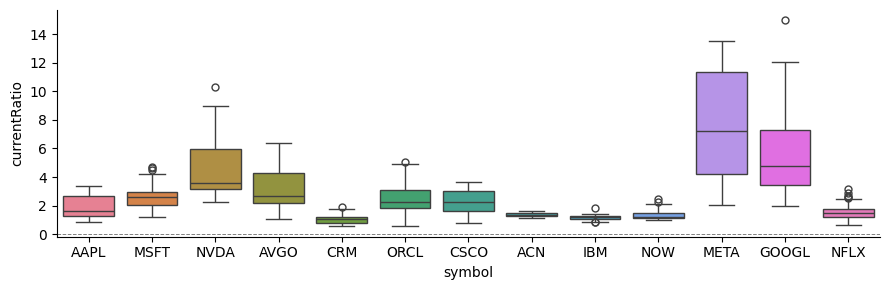

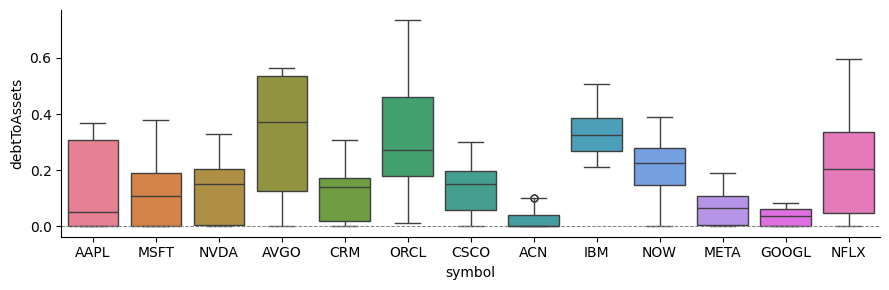

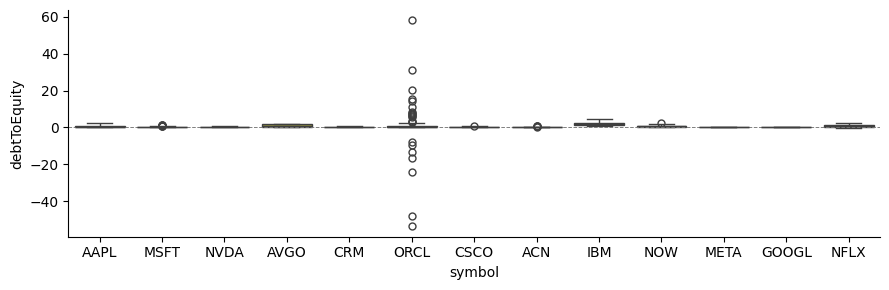

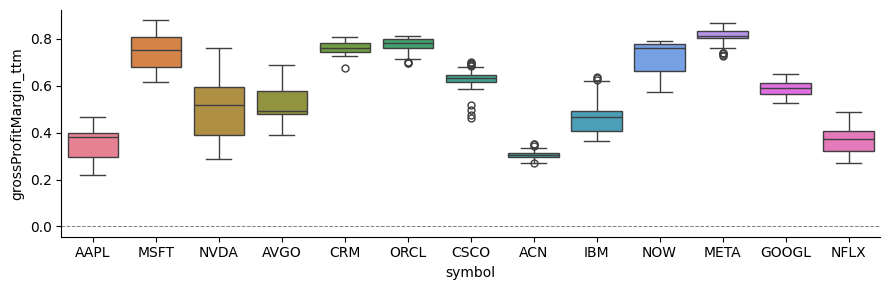

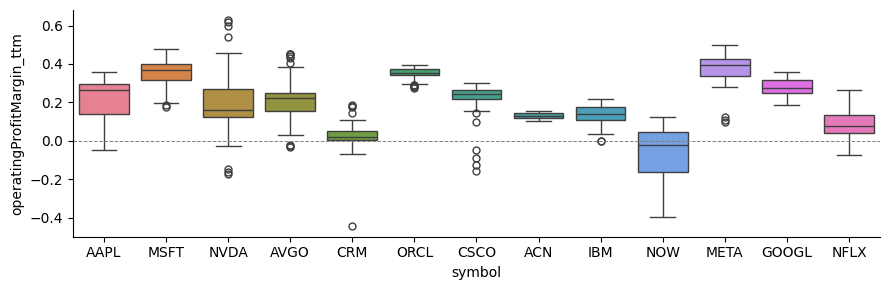

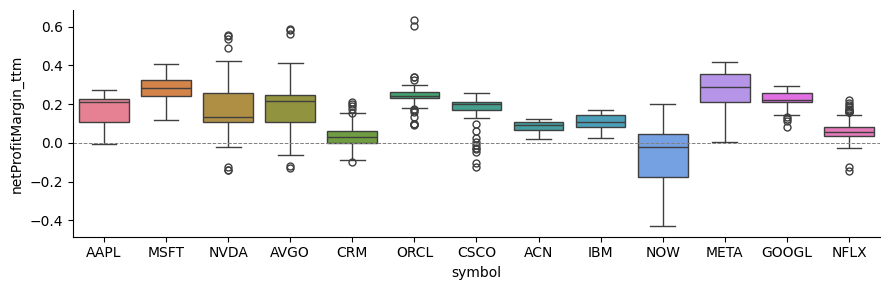

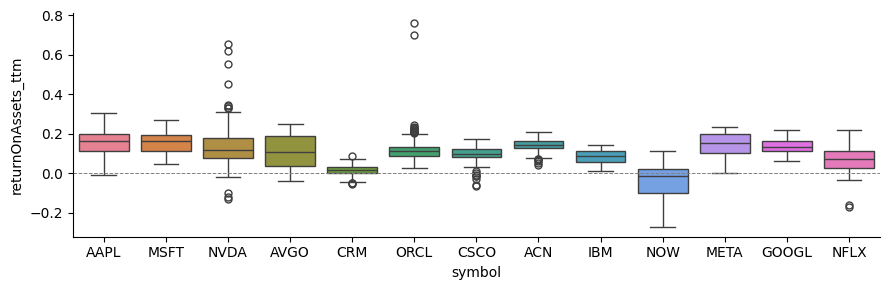

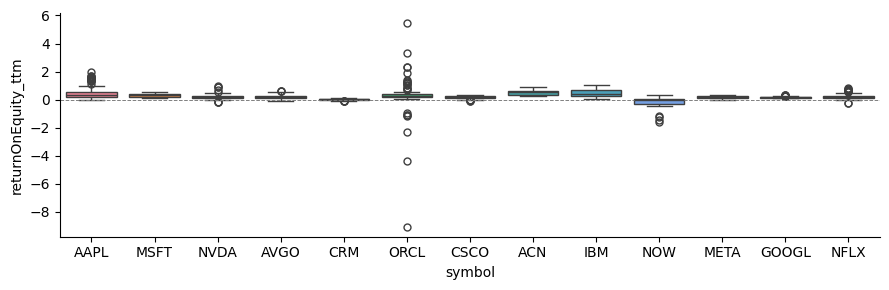

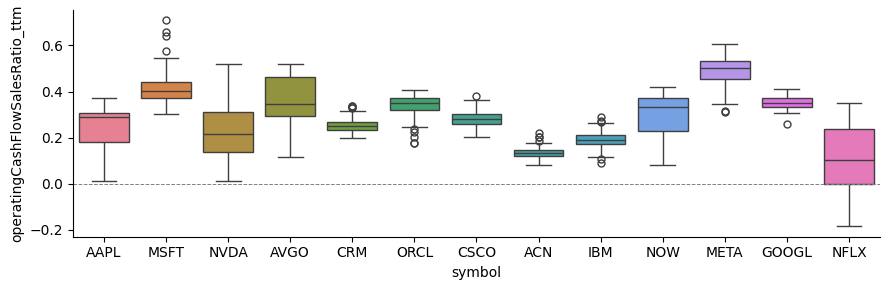

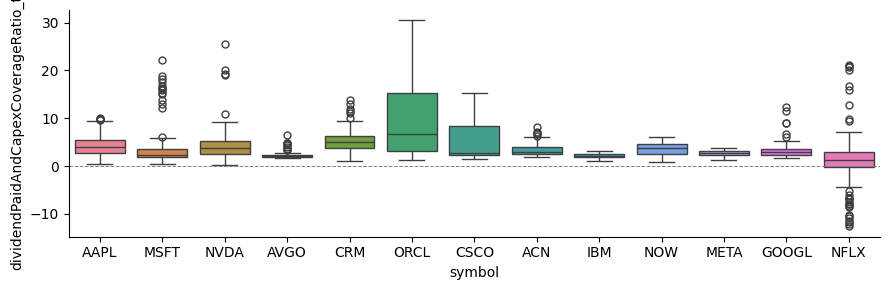

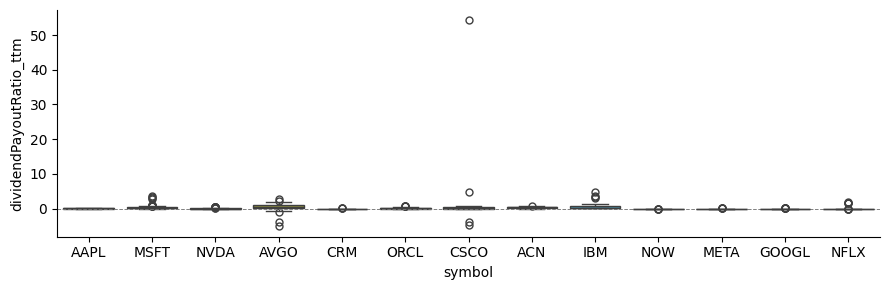

In [74]:
metrics_to_plot = ['currentRatio', 'debtToAssets', 'debtToEquity', \
                    'grossProfitMargin_ttm', 'operatingProfitMargin_ttm', 'netProfitMargin_ttm', \
                    'returnOnAssets_ttm', 'returnOnEquity_ttm', 'operatingCashFlowSalesRatio_ttm', \
                    'dividendPaidAndCapexCoverageRatio_ttm', 'dividendPayoutRatio_ttm']

for metric in metrics_to_plot:
    g = sns.catplot(
        data=financial_metrics_processed,
        y=metric,
        x='symbol',
        hue='symbol',
        kind='box',
        height=3,
        aspect=3
    )
    # Add a horizontal line at y = 0 for each subplot
    g.map(plt.axhline, y=0, color="grey", linestyle="--", linewidth=0.7)

In [75]:
financial_metrics_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype          
---  ------                                         --------------  -----          
 0   fiscalDateEnding                               1125 non-null   datetime64[ns] 
 1   symbol                                         1125 non-null   object         
 2   fillingDate                                    1125 non-null   datetime64[ns] 
 3   period                                         1125 non-null   object         
 4   daysInPeriod                                   1112 non-null   timedelta64[ns]
 5   currentRatio                                   1125 non-null   float64        
 6   debtToAssets                                   1125 non-null   float64        
 7   debtToEquity                                   1125 non-null   float64        
 8   grossProfitMargin_ttm                          1

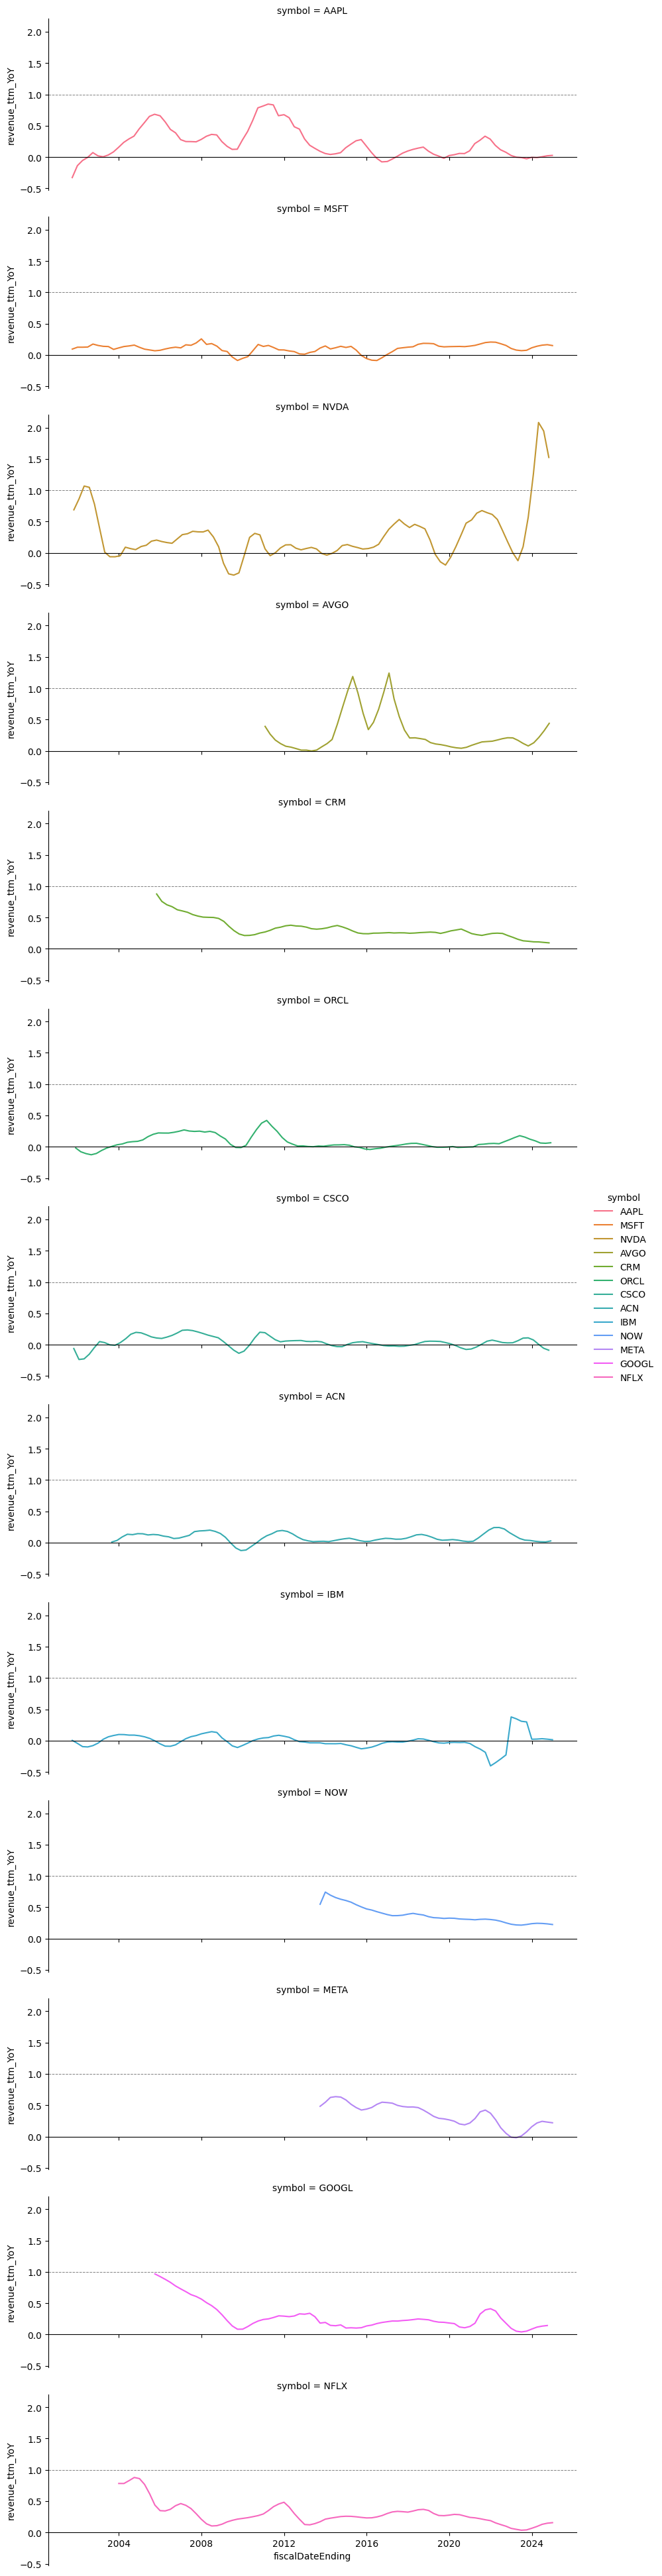

In [76]:
g = sns.relplot(
    data=financial_metrics_processed,
    y='revenue_ttm_YoY',
    x='fiscalDateEnding',
    row='symbol',
    hue='symbol',
    kind='line',
    height=3,
    aspect=3
)

# Apply formatting to each facet
for ax in g.axes.flat:
    ax.spines['bottom'].set_position(('data', 0))

# Add a horizontal line at y = 0 for each subplot
g.map(plt.axhline, y=1, color="grey", linestyle="--", linewidth=0.7)

**Notes:**

Highlevel analysis indicates a lot of opportunities for data clean up

1. remove outliers / reassess the number of features
2. check revenue growth rates
3. plot market caps


In [77]:
# drop redundant column
financial_metrics_processed.drop(columns=['daysInPeriod'], inplace=True)

In [78]:
display(financial_metrics_processed.isna().sum())

fiscalDateEnding                                  0
symbol                                            0
fillingDate                                       0
period                                            0
currentRatio                                      0
debtToAssets                                      0
debtToEquity                                      0
grossProfitMargin_ttm                            39
operatingProfitMargin_ttm                        39
netProfitMargin_ttm                              39
returnOnAssets_ttm                               39
returnOnEquity_ttm                               39
revenue_ttm                                      39
netIncome_ttm                                    39
operatingCashFlowSalesRatio_ttm                  41
dividendPaidAndCapexCoverageRatio_ttm            41
dividendPayoutRatio_ttm                          41
currentRatio_YoY_bps                             52
debtToAssets_YoY_bps                             52
debtToEquity_YoY_bps                             52
grossProfitMargin_ttm_YoY_bps                    91
operatingProfitMargin_ttm_YoY_bps                91
netProfitMargin_ttm_YoY_bps                      91
returnOnAssets_ttm_YoY_bps                       91
returnOnEquity_ttm_YoY_bps                       91
operatingCashFlowSalesRatio_ttm_YoY_bps          93
dividendPaidAndCapexCoverageRatio_ttm_YoY_bps    93
dividendPayoutRatio_ttm_YoY_bps                  93
totalAssets_YoY                                  52
revenue_qtly_YoY                                 52
operatingCashFlow_qtly_YoY                       54
revenue_ttm_YoY                                  91
operatingCashFlow_ttm_YoY                        93
eps_is                                            0
dtype: int64

#### Earnings history

In [79]:
# fetch earnings history for all tickers
all_data = []

for ticker in tickers:
    df = get_earnings_history(ticker)

    if not df.empty:
        all_data.append(df)
        print(f"Import completed for {ticker}.")
    else:
        print(f"Warning: No data retrieved for {ticker}.")

# Combine all DataFrames
earnings_history_raw = pd.concat(all_data, ignore_index=True)

# view
display(earnings_history_raw.info())
display(earnings_history_raw.head())

Import completed for AAPL.
Import completed for MSFT.
Import completed for NVDA.
Import completed for AVGO.
Import completed for CRM.
Import completed for ORCL.
Import completed for CSCO.
Import completed for ACN.
Import completed for IBM.
Import completed for NOW.
Import completed for META.
Import completed for GOOGL.
Import completed for NFLX.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1406 non-null   object 
 1   symbol            1406 non-null   object 
 2   eps               1367 non-null   float64
 3   epsEstimated      1170 non-null   float64
 4   time              1406 non-null   object 
 5   revenue           1366 non-null   float64
 6   revenueEstimated  1113 non-null   float64
 7   updatedFromDate   1406 non-null   object 
 8   fiscalDateEnding  1406 non-null   object 
dtypes: float64(4), object(5)

None

date symbol  eps  epsEstimated time         revenue  \
0  2025-10-29   AAPL  NaN           NaN  amc             NaN   
1  2025-07-30   AAPL  NaN           NaN  amc             NaN   
2  2025-05-01   AAPL  NaN          1.61  amc             NaN   
3  2025-01-30   AAPL 2.40          2.36  amc 124300000000.00   
4  2024-10-31   AAPL 1.64          1.60  amc  94930000000.00   

   revenueEstimated updatedFromDate fiscalDateEnding  
0               NaN      2025-02-23       2025-09-27  
1               NaN      2025-02-23       2025-06-27  
2    94076168920.00      2025-02-23       2025-03-27  
3   124257393152.00      2025-02-23       2024-12-28  
4    94511953345.00      2025-02-23       2024-09-28

In [80]:
# Drop unnecessary columns
earnings_history_raw.drop(columns=['updatedFromDate'], errors='ignore', inplace=True)

# Convert date column to datetime
earnings_history_raw['date'] = pd.to_datetime(earnings_history_raw['date'])
earnings_history_raw['fiscalDateEnding'] = pd.to_datetime(earnings_history_raw['fiscalDateEnding'])

# Filter data by date range
earnings_history_raw = earnings_history_raw[
    (earnings_history_raw['fiscalDateEnding'] >= start_date.strftime("%Y-%m-%d")) &
    (earnings_history_raw['fiscalDateEnding'] <= end_date.strftime("%Y-%m-%d")) &
    (earnings_history_raw['date'] <= end_date.strftime("%Y-%m-%d"))
]

# Sort data chronologically
earnings_history_raw.sort_values(by=['symbol', 'fiscalDateEnding'], ascending=True, inplace=True)
earnings_history_raw['daysInPeriod'] = earnings_history_raw.groupby('symbol')['fiscalDateEnding'].diff(periods=1)

# view
display(earnings_history_raw.info())
display(earnings_history_raw.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1083 entries, 103 to 528
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   date              1083 non-null   datetime64[ns] 
 1   symbol            1083 non-null   object         
 2   eps               1083 non-null   float64        
 3   epsEstimated      1036 non-null   float64        
 4   time              1083 non-null   object         
 5   revenue           1082 non-null   float64        
 6   revenueEstimated  1031 non-null   float64        
 7   fiscalDateEnding  1083 non-null   datetime64[ns] 
 8   daysInPeriod      1070 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(4), object(2), timedelta64[ns](1)
memory usage: 84.6+ KB


None

date     eps  epsEstimated         revenue  \
count                           1083 1083.00       1036.00         1082.00   
mean   2013-12-16 18:52:51.191135744    0.89          0.88  14007280825.32   
min              2000-01-18 00:00:00   -0.31         -0.10     16600000.00   
25%              2008-03-26 12:00:00    0.13          0.15   2499000000.00   
50%              2014-08-21 00:00:00    0.51          0.52   8201150500.00   
75%              2019-11-13 12:00:00    1.21          1.15  16879000000.00   
max              2025-01-30 00:00:00    8.02         10.37 124300000000.00   
std                              NaN    1.08          1.07  18661737627.00   

       revenueEstimated               fiscalDateEnding  \
count           1031.00                           1083   
mean     14136832992.26  2013-11-24 05:27:05.484764672   
min         52369475.00            1999-12-31 00:00:00   
25%       2885513887.50            2008-02-29 00:00:00   
50%       8410775320.00            2014-07-31 00:00:00   
75%      17313105072.00            2019-10-26 12:00:00   
max     124257393152.00            2024-12-31 00:00:00   
std      18501736827.41                            NaN   

                     daysInPeriod  
count                        1070  
mean   95 days 09:57:31.962616822  
min              62 days 00:00:00  
25%              91 days 00:00:00  
50%              91 days 00:00:00  
75%              92 days 00:00:00  
max            1463 days 00:00:00  
std    62 days 17:12:59.437138443

In [81]:
earnings_history_raw.daysInPeriod.value_counts()

daysInPeriod
91 days      479
92 days      422
90 days      129
89 days       18
98 days       11
185 days       1
95 days        1
183 days       1
546 days       1
1008 days      1
1463 days      1
1183 days      1
364 days       1
182 days       1
62 days        1
120 days       1
Name: count, dtype: int64

In [82]:
# view records with unexpected period length
display(
    earnings_history_raw[(earnings_history_raw['daysInPeriod'].dt.days > 100) ^
    (earnings_history_raw['daysInPeriod'].dt.days < 80)]
    .sort_values(by=['symbol', 'date'])
)


date symbol   eps  epsEstimated time        revenue  \
934  2002-01-09    ACN  0.25          0.24  bmo  3408510000.00   
1151 2012-08-01    NOW -0.06           NaN  amc    47431000.00   
373  2002-08-15   NVDA  0.00          0.00  bmo   427285000.00   
367  2006-11-09   NVDA  0.07          0.06  bmo   687519000.00   
366  2010-08-12   NVDA -0.01         -0.00  amc   811208000.00   
365  2013-11-07   NVDA  0.01          0.01  amc  1053967000.00   
364  2014-11-06   NVDA  0.01          0.01  amc  1225382000.00   
361  2015-11-05   NVDA  0.01          0.01  amc  1305000000.00   
571  2014-03-18   ORCL  0.68          0.70  amc  9307000000.00   
570  2014-06-19   ORCL  0.92          0.95  amc 11320000000.00   

      revenueEstimated fiscalDateEnding daysInPeriod  
934      3266488749.00       2001-11-30     185 days  
1151               NaN       2012-03-31     183 days  
373       427300000.00       2002-07-28     546 days  
367       820600000.00       2006-07-30    1008 days  
366      2974400000.00       2010-08-01    1463 days  
365      1054000000.00       2013-10-27    1183 days  
364      1106812903.00       2014-10-26     364 days  
361      1162755000.00       2015-10-25     182 days  
571      9581764705.00       2014-01-31      62 days  
570     11689130434.00       2014-05-31     120 days

In [83]:
# adjust the fiscal date ending from 2014-01-31 to 2014-02-28 for ORCL
earnings_history_raw.loc[
(earnings_history_raw['fiscalDateEnding'] == '2014-01-31') &
(earnings_history_raw['symbol'] == 'ORCL'), 'fiscalDateEnding'] = '2014-02-28'

In [84]:
# drill down
display(
    earnings_history_raw[(earnings_history_raw['symbol'] == 'NOW') &
    (earnings_history_raw['date'] < '2013-12-31')]
    .sort_values(by=['date'])
)


display(
    earnings_history_raw[(earnings_history_raw['symbol'] == 'NVDA') &
    (earnings_history_raw['date'] < '2015-12-31')]
    .sort_values(by=['date'])
)

date symbol   eps  epsEstimated time      revenue  \
1156 2010-09-29    NOW  0.02           NaN  amc  16600000.00   
1155 2010-12-30    NOW  0.02           NaN  amc  21400000.00   
1154 2011-03-30    NOW  0.02           NaN  amc  25200000.00   
1153 2011-06-29    NOW  0.02           NaN  amc  29500000.00   
1152 2011-12-30    NOW -0.06           NaN  amc  73375000.00   
1151 2012-08-01    NOW -0.06           NaN  amc  47431000.00   
1150 2012-08-10    NOW -0.31           NaN  amc  56774000.00   
1149 2012-10-24    NOW -0.06         -0.10  amc  64345000.00   
1148 2013-01-30    NOW -0.08         -0.05  amc  75162000.00   
1147 2013-04-24    NOW -0.01         -0.01  amc  85939000.00   
1146 2013-07-31    NOW -0.06         -0.05  amc 102222000.00   
1145 2013-10-23    NOW  0.01          0.00  amc 111259000.00   

      revenueEstimated fiscalDateEnding daysInPeriod  
1156               NaN       2010-09-30          NaT  
1155               NaN       2010-12-31      92 days  
1154               NaN       2011-03-31      90 days  
1153               NaN       2011-06-30      91 days  
1152               NaN       2011-09-30      92 days  
1151               NaN       2012-03-31     183 days  
1150               NaN       2012-06-30      91 days  
1149      107166666.00       2012-09-30      92 days  
1148       74410380.00       2012-12-31      92 days  
1147      257699999.00       2013-03-31      90 days  
1146       85166666.00       2013-06-30      91 days  
1145      222600000.00       2013-09-30      92 days

date symbol   eps  epsEstimated time       revenue  \
378 2000-02-15   NVDA  0.00          0.00  bmo  128400000.00   
377 2000-05-16   NVDA  0.00          0.00  bmo  148483000.00   
376 2000-08-21   NVDA  0.00          0.00  bmo  170398000.00   
375 2000-11-09   NVDA  0.00          0.05  bmo  198165000.00   
374 2001-02-15   NVDA  0.00          0.01  bmo  218218000.00   
373 2002-08-15   NVDA  0.00          0.00  bmo  427285000.00   
372 2002-11-07   NVDA -0.00         -0.00  bmo  430304000.00   
371 2003-02-13   NVDA  0.00          0.00  bmo  468953000.00   
370 2003-05-08   NVDA  0.00          0.00  bmo  404983000.00   
369 2003-08-07   NVDA  0.00          0.00  bmo  459774000.00   
368 2003-11-06   NVDA  0.00          0.00  bmo  486069000.00   
367 2006-11-09   NVDA  0.07          0.06  bmo  687519000.00   
366 2010-08-12   NVDA -0.01         -0.00  amc  811208000.00   
365 2013-11-07   NVDA  0.01          0.01  amc 1053967000.00   
364 2014-11-06   NVDA  0.01          0.01  amc 1225382000.00   
363 2015-02-11   NVDA  0.01          0.01  amc 1250514000.00   
362 2015-05-07   NVDA  0.01          0.01  amc 1151000000.00   
361 2015-11-05   NVDA  0.01          0.01  amc 1305000000.00   

     revenueEstimated fiscalDateEnding daysInPeriod  
378      128500000.00       2000-01-30          NaT  
377      111375000.00       2000-04-30      91 days  
376      136320000.00       2000-07-30      91 days  
375      165166666.00       2000-10-29      91 days  
374      360030000.00       2001-01-28      91 days  
373      427300000.00       2002-07-28     546 days  
372      645450000.00       2002-10-27      91 days  
371      386925000.00       2003-01-26      91 days  
370      405000000.00       2003-04-27      91 days  
369      613066666.00       2003-07-27      91 days  
368      388879999.00       2003-10-26      91 days  
367      820600000.00       2006-07-30    1008 days  
366     2974400000.00       2010-08-01    1463 days  
365     1054000000.00       2013-10-27    1183 days  
364     1106812903.00       2014-10-26     364 days  
363     1000400000.00       2015-01-25      91 days  
362     1246916666.00       2015-04-26      91 days  
361     1162755000.00       2015-10-25     182 days

**Decision:**

- NOW: Periods prior to 2012-10-24 have been removed due to the absence of estimates.
- NVDA: Periods before 2015-12-31 have been excluded due to the low frequency of observations.
  

In [85]:
# drop NOW records prior to '2012-10-24'
earnings_history_raw = earnings_history_raw.drop(
    earnings_history_raw[(earnings_history_raw['date'] < '2012-10-24') & (earnings_history_raw['symbol'] == 'NOW')].index
)

# drop NVDA records prior to '2015-12-31'
earnings_history_raw = earnings_history_raw.drop(
    earnings_history_raw[(earnings_history_raw['date'] < '2015-12-31') & (earnings_history_raw['symbol'] == 'NVDA')].index
)

In [86]:
earnings_history_raw.columns

Index(['date', 'symbol', 'eps', 'epsEstimated', 'time', 'revenue',
       'revenueEstimated', 'fiscalDateEnding', 'daysInPeriod'],
      dtype='object')

**Note**:

1. AMC: After Market Close (closing price as at the announcement day in in the pre-window)
2. BMO: Before Market Open

In [87]:
# Convert earnings announcement date to AMC-equivalent convention for ease of data-manipulation
earnings_history_raw['amcEquivalentEarnReportedDate'] = np.where(
    earnings_history_raw['time'] == 'amc',
    earnings_history_raw['date'],  # If 'amc', keep the same date
    earnings_history_raw['date'] - pd.Timedelta(days=1)  # If 'bmo' or other, subtract 1 day
)

In [88]:
# if revenue estimate = to revenue actual most likely no estimate was provided = not meaningfull
earnings_history_raw.loc[earnings_history_raw['revenueEstimated'] == earnings_history_raw['revenue'], 'revenueEstimated'] = np.nan

In [89]:
earnings_history_raw

date symbol   eps  epsEstimated time        revenue  \
103 2000-01-19   AAPL  0.01          0.01  amc  2343000000.00   
102 2000-04-19   AAPL  0.01          0.01  amc  1945000000.00   
101 2000-07-18   AAPL  0.01          0.01  amc  1825000000.00   
100 2000-10-18   AAPL  0.01           NaN  amc  1870000000.00   
99  2001-04-18   AAPL -0.01           NaN  amc  1007000000.00   
..         ...    ...   ...           ...  ...            ...   
532 2023-12-11   ORCL  1.34          1.32  amc 12941000000.00   
531 2024-03-11   ORCL  1.41          1.38  amc 13280000000.00   
530 2024-06-11   ORCL  1.63          1.65  amc 14287000000.00   
529 2024-09-09   ORCL  1.39          1.33  amc 13307000000.00   
528 2024-12-09   ORCL  1.47          1.48  amc 14059000000.00   

     revenueEstimated fiscalDateEnding daysInPeriod  \
103               NaN       2000-01-01          NaT   
102               NaN       2000-04-01      91 days   
101               NaN       2000-07-01      91 days   
100               NaN       2000-09-30      91 days   
99                NaN       2000-12-30      91 days   
..                ...              ...          ...   
532    13048000000.00       2023-11-30      91 days   
531    13286481142.00       2024-02-29      91 days   
530    14562253539.00       2024-05-31      92 days   
529    13233301542.00       2024-08-31      92 days   
528    14117796631.00       2024-11-30      91 days   

    amcEquivalentEarnReportedDate  
103                    2000-01-19  
102                    2000-04-19  
101                    2000-07-18  
100                    2000-10-18  
99                     2001-04-18  
..                            ...  
532                    2023-12-11  
531                    2024-03-11  
530                    2024-06-11  
529                    2024-09-09  
528                    2024-12-09  

[1058 rows x 10 columns]

In [90]:
earnings_history_raw.loc[earnings_history_raw['epsEstimated'] <= 0]

date symbol   eps  epsEstimated time      revenue  \
1404 2002-10-18   NFLX -0.09         -0.05  bmo  36360000.00   
1402 2003-01-15   NFLX -0.01         -0.00  bmo  45188000.00   
1401 2003-04-17   NFLX -0.01         -0.01  bmo  55669000.00   
1393 2005-04-21   NFLX -0.02         -0.02  bmo 154140000.00   
1365 2012-04-23   NFLX -0.01         -0.01  amc 869791000.00   
1149 2012-10-24    NOW -0.06         -0.10  amc  64345000.00   
1148 2013-01-30    NOW -0.08         -0.05  amc  75162000.00   
1147 2013-04-24    NOW -0.01         -0.01  amc  85939000.00   
1146 2013-07-31    NOW -0.06         -0.05  amc 102222000.00   
1144 2014-01-29    NOW -0.02         -0.01  amc 125230000.00   
1143 2014-04-23    NOW -0.08         -0.08  amc 139090000.00   
1142 2014-07-30    NOW -0.07         -0.07  amc 166757000.00   

      revenueEstimated fiscalDateEnding daysInPeriod  \
1404       52369475.00       2002-06-30      91 days   
1402       57512567.00       2002-12-31      92 days   
1401       52485289.00       2003-03-31      90 days   
1393      462419999.00       2005-03-31      90 days   
1365     3479164000.00       2012-03-31      91 days   
1149      107166666.00       2012-09-30      92 days   
1148       74410380.00       2012-12-31      92 days   
1147      257699999.00       2013-03-31      90 days   
1146       85166666.00       2013-06-30      91 days   
1144       62600000.00       2013-12-31      92 days   
1143      139100000.00       2014-03-31      90 days   
1142      166800000.00       2014-06-30      91 days   

     amcEquivalentEarnReportedDate  
1404                    2002-10-17  
1402                    2003-01-14  
1401                    2003-04-16  
1393                    2005-04-20  
1365                    2012-04-23  
1149                    2012-10-24  
1148                    2013-01-30  
1147                    2013-04-24  
1146                    2013-07-31  
1144                    2014-01-29  
1143                    2014-04-23  
1142                    2014-07-30

In [91]:
# Apply preprocessing function to each ticker group
earnings_history_processed = (
    earnings_history_raw.groupby('symbol', group_keys=False)
    .apply(preprocess_earnings_data)
    .reset_index(drop=True)
)

print("Preprocessing completed for all tickers.")

# view
display(earnings_history_processed.head())
display(earnings_history_processed.info())

Preprocessing completed for all tickers.


earnReportedDate symbol  epsAct  epsEst earnReportedTime    revenueAct  \
0       2000-01-19   AAPL    0.01    0.01              amc 2343000000.00   
1       2000-04-19   AAPL    0.01    0.01              amc 1945000000.00   
2       2000-07-18   AAPL    0.01    0.01              amc 1825000000.00   
3       2000-10-18   AAPL    0.01     NaN              amc 1870000000.00   
4       2001-04-18   AAPL   -0.01     NaN              amc 1007000000.00   

   revenueEst fiscalDateEnding_ea daysInPeriod amcEquivalentEarnReportedDate  \
0         NaN          2000-01-01          NaT                    2000-01-19   
1         NaN          2000-04-01      91 days                    2000-04-19   
2         NaN          2000-07-01      91 days                    2000-07-18   
3         NaN          2000-09-30      91 days                    2000-10-18   
4         NaN          2000-12-30      91 days                    2001-04-18   

   ...  revSurpriseAbs  revSurprise_pct  standEpsSurpriseScore  \
0  ...             NaN              NaN                    NaN   
1  ...             NaN              NaN                    NaN   
2  ...             NaN              NaN                    NaN   
3  ...             NaN              NaN                    NaN   
4  ...             NaN              NaN                    NaN   

   epsSurpriseChange_QoQ  epsEst_YoY  epsAct_YoY  standRevSurpriseScore  \
0                    NaN         NaN         NaN                    NaN   
1                  -0.02         NaN         NaN                    NaN   
2                  -0.07         NaN         NaN                    NaN   
3                    NaN         NaN         NaN                    NaN   
4                    NaN         NaN       -2.20                    NaN   

   revSurpriseChange_QoQ  revenueEst_YoY  revenueAct_YoY  
0                    NaN             NaN             NaN  
1                    NaN             NaN             NaN  
2                    NaN             NaN             NaN  
3                    NaN             NaN             NaN  
4                    NaN             NaN           -0.57  

[5 rows x 22 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   earnReportedDate               1058 non-null   datetime64[ns] 
 1   symbol                         1058 non-null   object         
 2   epsAct                         1058 non-null   float64        
 3   epsEst                         1018 non-null   float64        
 4   earnReportedTime               1058 non-null   object         
 5   revenueAct                     1057 non-null   float64        
 6   revenueEst                     945 non-null    float64        
 7   fiscalDateEnding_ea            1058 non-null   datetime64[ns] 
 8   daysInPeriod                   1045 non-null   timedelta64[ns]
 9   amcEquivalentEarnReportedDate  1058 non-null   datetime64[ns] 
 10  epsSurpriseAbs                 1018 non-null   float64        
 11  epsS

None

In [92]:
# drop non-informative records
earnings_history_processed = earnings_history_processed.dropna(
    subset=['epsEst', 'revenueEst'],
    how='all'
)

In [93]:
display(earnings_history_processed.describe().T)
display(earnings_history_processed.isna().sum())

count                           mean  \
earnReportedDate                 1018  2014-06-21 04:48:33.948919552   
epsAct                        1018.00                           0.94   
epsEst                        1018.00                           0.89   
revenueAct                    1017.00                 14866175486.73   
revenueEst                     945.00                 14997941353.57   
fiscalDateEnding_ea              1018  2014-05-29 11:44:26.404715008   
daysInPeriod                     1009     91 days 09:46:33.657086224   
amcEquivalentEarnReportedDate    1018  2014-06-20 22:29:28.172888064   
epsSurpriseAbs                1018.00                           0.05   
epsSurprise_pct               1018.00                           0.12   
revSurpriseAbs                 945.00                   568551471.83   
revSurprise_pct                945.00                           0.11   
standEpsSurpriseScore          964.00               1294682717270.90   
epsSurpriseChange_QoQ          995.00                          -0.01   
epsEst_YoY                     981.00                           0.26   
epsAct_YoY                     981.00                           0.39   
standRevSurpriseScore          890.00                           1.05   
revSurpriseChange_QoQ          872.00                           0.00   
revenueEst_YoY                 913.00                           0.13   
revenueAct_YoY                 980.00                           0.21   

                                               min                  25%  \
earnReportedDate               2000-01-18 00:00:00  2009-01-21 06:00:00   
epsAct                                       -0.09                 0.19   
epsEst                                       -0.10                 0.17   
revenueAct                             36360000.00        3410102000.00   
revenueEst                             52369475.00        3390744000.00   
fiscalDateEnding_ea            1999-12-31 00:00:00  2008-12-31 00:00:00   
daysInPeriod                      89 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2000-01-18 00:00:00  2009-01-21 00:00:00   
epsSurpriseAbs                               -9.27                 0.01   
epsSurprise_pct                              -0.89                 0.02   
revSurpriseAbs                     -36325517621.00          64217622.00   
revSurprise_pct                              -0.77                 0.01   
standEpsSurpriseScore                      -855.46                 0.30   
epsSurpriseChange_QoQ                        -2.06                -0.06   
epsEst_YoY                                  -10.20                -0.01   
epsAct_YoY                                  -11.07                 0.04   
standRevSurpriseScore                       -49.91                 0.17   
revSurpriseChange_QoQ                        -5.90                -0.05   
revenueEst_YoY                               -0.75                -0.03   
revenueAct_YoY                               -0.84                 0.04   

                                               50%                  75%  \
earnReportedDate               2015-04-05 00:00:00  2020-03-12 00:00:00   
epsAct                                        0.56                 1.29   
epsEst                                        0.53                 1.18   
revenueAct                           8832825000.00       18059000000.00   
revenueEst                           8895846962.00       18182457831.00   
fiscalDateEnding_ea            2015-03-14 00:00:00  2020-02-22 06:00:00   
daysInPeriod                      91 days 00:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2015-04-04 12:00:00  2020-03-12 00:00:00   
epsSurpriseAbs                                0.02                 0.06   
epsSurprise_pct                               0.06                 0.13   
revSurpriseAbs                        269000001.00         823126970.00   
revSurprise_pct                            

earnReportedDate                   0
symbol                             0
epsAct                             0
epsEst                             0
earnReportedTime                   0
revenueAct                         1
revenueEst                        73
fiscalDateEnding_ea                0
daysInPeriod                       9
amcEquivalentEarnReportedDate      0
epsSurpriseAbs                     0
epsSurprise_pct                    0
revSurpriseAbs                    73
revSurprise_pct                   73
standEpsSurpriseScore             54
epsSurpriseChange_QoQ             23
epsEst_YoY                        37
epsAct_YoY                        37
standRevSurpriseScore            128
revSurpriseChange_QoQ            146
revenueEst_YoY                   105
revenueAct_YoY                    38
dtype: int64

In [94]:
tickers = list(earnings_history_processed['symbol'].unique())
display(tickers)

['AAPL',
 'ACN',
 'AVGO',
 'CRM',
 'CSCO',
 'GOOGL',
 'IBM',
 'META',
 'MSFT',
 'NFLX',
 'NOW',
 'NVDA',
 'ORCL']

In [95]:
for ticker in tickers:
    display(ticker)
    display(earnings_history_processed[earnings_history_processed['symbol'] == ticker].describe().T)

'AAPL'

count                        mean  \
earnReportedDate                 90         2013-10-24 23:44:00   
epsAct                        90.00                        0.55   
epsEst                        90.00                        0.52   
revenueAct                    90.00              44054766666.67   
revenueEst                    82.00              46257490158.11   
fiscalDateEnding_ea              90         2013-09-26 08:48:00   
daysInPeriod                     89  91 days 07:33:02.022471910   
amcEquivalentEarnReportedDate    90         2013-10-24 23:44:00   
epsSurpriseAbs                90.00                        0.04   
epsSurprise_pct               90.00                        0.14   
revSurpriseAbs                82.00               1825046427.26   
revSurprise_pct               82.00                        0.06   
standEpsSurpriseScore         84.00                        1.80   
epsSurpriseChange_QoQ         86.00                       -0.00   
epsEst_YoY                    87.00                        0.19   
epsAct_YoY                    87.00                        0.39   
standRevSurpriseScore         76.00                        0.82   
revSurpriseChange_QoQ         77.00                        0.00   
revenueEst_YoY                82.00                        0.17   
revenueAct_YoY                87.00                        0.23   

                                               min                  25%  \
earnReportedDate               2000-01-19 00:00:00  2008-05-15 06:00:00   
epsAct                                        0.00                 0.04   
epsEst                                        0.00                 0.04   
revenueAct                           1450000000.00        7607750000.00   
revenueEst                           1375000000.00        9942265624.75   
fiscalDateEnding_ea            2000-01-01 00:00:00  2008-04-20 18:00:00   
daysInPeriod                      91 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2000-01-19 00:00:00  2008-05-15 06:00:00   
epsSurpriseAbs                               -0.06                 0.00   
epsSurprise_pct                              -0.11                 0.03   
revSurpriseAbs                     -34626000000.00         323822496.25   
revSurprise_pct                              -0.37                 0.01   
standEpsSurpriseScore                        -1.01                 0.39   
epsSurpriseChange_QoQ                        -0.52                -0.05   
epsEst_YoY                                  -10.20                -0.02   
epsAct_YoY                                  -11.07                 0.05   
standRevSurpriseScore                        -5.16                 0.10   
revSurpriseChange_QoQ                        -0.62                -0.05   
revenueEst_YoY                               -0.26                -0.01   
revenueAct_YoY                               -0.22                 0.04   

                                               50%                  75%  \
earnReportedDate               2013-12-12 12:00:00  2019-07-07 06:00:00   
epsAct                                        0.39                 0.77   
epsEst                                        0.36                 0.71   
revenueAct                          42980500000.00       72123750000.00   
revenueEst                          44935825244.50       74818744283.50   
fiscalDateEnding_ea            2013-11-12 12:00:00  2019-06-06 06:00:00   
daysInPeriod                      91 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2013-12-12 12:00:00  2019-07-07 06:00:00   
epsSurpriseAbs                                0.02                 0.04   
epsSurprise_pct                               0.07                 0.19   
revSurpriseAbs                       1293118644.50        3258337804.00   
revSurprise_pct                               0.04                 0.13   
standEpsSurpriseScore                         0.94                 2.25

'ACN'

count                           mean  \
earnReportedDate                 94  2013-05-11 19:24:15.319149056   
epsAct                        94.00                           1.25   
epsEst                        94.00                           1.20   
revenueAct                    93.00                  8408252225.81   
revenueEst                    88.00                  8339714326.45   
fiscalDateEnding_ea              94  2013-04-14 07:39:34.468084992   
daysInPeriod                     93     92 days 07:44:30.967741935   
amcEquivalentEarnReportedDate    94  2013-05-10 23:44:40.851063808   
epsSurpriseAbs                94.00                           0.05   
epsSurprise_pct               94.00                           0.04   
revSurpriseAbs                88.00                   315381548.55   
revSurprise_pct               88.00                           0.04   
standEpsSurpriseScore         90.00                           1.41   
epsSurpriseChange_QoQ         93.00                          -0.00   
epsEst_YoY                    90.00                           0.09   
epsAct_YoY                    90.00                           0.13   
standRevSurpriseScore         84.00                           1.70   
revSurpriseChange_QoQ         82.00                           0.00   
revenueEst_YoY                85.00                           0.03   
revenueAct_YoY                89.00                           0.08   

                                               min                  25%  \
earnReportedDate               2001-10-11 00:00:00  2007-07-20 18:00:00   
epsAct                                        0.12                 0.51   
epsEst                                        0.11                 0.50   
revenueAct                           3084605000.00        5537348000.00   
revenueEst                           3008217519.00        5567475722.75   
fiscalDateEnding_ea            2001-05-29 00:00:00  2007-06-23 00:00:00   
daysInPeriod                      90 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2001-10-10 00:00:00  2007-07-19 18:00:00   
epsSurpriseAbs                               -0.03                 0.01   
epsSurprise_pct                              -0.04                 0.01   
revSurpriseAbs                       -732342000.00          97370084.00   
revSurprise_pct                              -0.04                 0.01   
standEpsSurpriseScore                        -1.15                 0.40   
epsSurpriseChange_QoQ                        -0.16                -0.04   
epsEst_YoY                                   -0.14                 0.02   
epsAct_YoY                                   -0.09                 0.06   
standRevSurpriseScore                        -1.24                 0.27   
revSurpriseChange_QoQ                        -0.15                -0.04   
revenueEst_YoY                               -0.21                -0.00   
revenueAct_YoY                               -0.16                 0.03   

                                               50%                  75%  \
earnReportedDate               2013-05-12 12:00:00  2019-03-03 12:00:00   
epsAct                                        1.03                 1.78   
epsEst                                        1.02                 1.72   
revenueAct                           7640790000.00       10835271000.00   
revenueEst                           7582692982.00       10300329325.50   
fiscalDateEnding_ea            2013-04-15 00:00:00  2019-02-05 12:00:00   
daysInPeriod                      92 days 00:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2013-05-12 00:00:00  2019-03-02 12:00:00   
epsSurpriseAbs                                0.03                 0.07   
epsSurprise_pct                               0.04                 0.06   
revSurpriseAbs                        234660296.00         484599183.25   
revSurprise_pct                               0.04                 0.07   
standEps

'AVGO'

count                           mean  \
earnReportedDate                 49  2018-12-03 13:13:28.163265280   
epsAct                        49.00                           0.54   
epsEst                        49.00                           0.72   
revenueAct                    49.00                  5316040816.33   
revenueEst                    48.00                  5207406285.25   
fiscalDateEnding_ea              49  2018-10-31 20:04:53.877551104   
daysInPeriod                     48               91 days 09:00:00   
amcEquivalentEarnReportedDate    49  2018-12-03 13:13:28.163265280   
epsSurpriseAbs                49.00                          -0.18   
epsSurprise_pct               49.00                           0.03   
revSurpriseAbs                48.00                    99760381.42   
revSurprise_pct               48.00                           0.04   
standEpsSurpriseScore         45.00              27734980876618.84   
epsSurpriseChange_QoQ         48.00                          -0.00   
epsEst_YoY                    45.00                           0.47   
epsAct_YoY                    45.00                           0.32   
standRevSurpriseScore         44.00                           1.77   
revSurpriseChange_QoQ         46.00                          -0.00   
revenueEst_YoY                44.00                           0.31   
revenueAct_YoY                45.00                           0.36   

                                               min                  25%  \
earnReportedDate               2012-11-29 00:00:00  2015-12-02 00:00:00   
epsAct                                        0.06                 0.24   
epsEst                                        0.05                 0.23   
revenueAct                            562000000.00        1771000000.00   
revenueEst                            540384615.00        1678206307.50   
fiscalDateEnding_ea            2012-10-31 00:00:00  2015-10-31 00:00:00   
daysInPeriod                      89 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2012-11-29 00:00:00  2015-12-02 00:00:00   
epsSurpriseAbs                               -9.27                 0.01   
epsSurprise_pct                              -0.89                 0.01   
revSurpriseAbs                       -399250000.00          39890547.50   
revSurprise_pct                              -0.04                 0.01   
standEpsSurpriseScore                      -855.46                 0.80   
epsSurpriseChange_QoQ                        -0.90                -0.02   
epsEst_YoY                                   -0.08                 0.10   
epsAct_YoY                                   -0.08                 0.12   
standRevSurpriseScore                        -2.83                 0.41   
revSurpriseChange_QoQ                        -0.13                -0.02   
revenueEst_YoY                                0.02                 0.09   
revenueAct_YoY                                0.01                 0.12   

                                               50%                  75%  \
earnReportedDate               2018-12-06 00:00:00  2021-12-09 00:00:00   
epsAct                                        0.51                 0.78   
epsEst                                        0.51                 0.78   
revenueAct                           5444000000.00        7407000000.00   
revenueEst                           5222949428.50        7586226207.50   
fiscalDateEnding_ea            2018-11-04 00:00:00  2021-10-31 00:00:00   
daysInPeriod                      91 days 00:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2018-12-06 00:00:00  2021-12-09 00:00:00   
epsSurpriseAbs                                0.01                 0.02   
epsSurprise_pct                               0.03                 0.05   
revSurpriseAbs                         83856579.50         173956849.50   
revSurprise_pct                               0.03                 0.06   
standEps

'CRM'

count                           mean  \
earnReportedDate                 78  2015-03-29 17:32:18.461538560   
epsAct                        78.00                           0.54   
epsEst                        78.00                           0.45   
revenueAct                    78.00                  2885134384.62   
revenueEst                    77.00                  2642353247.87   
fiscalDateEnding_ea              78  2015-03-06 05:13:50.769230848   
daysInPeriod                     78     91 days 07:04:36.923076923   
amcEquivalentEarnReportedDate    78  2015-03-29 13:13:50.769230848   
epsSurpriseAbs                78.00                           0.09   
epsSurprise_pct               78.00                           0.19   
revSurpriseAbs                77.00                   278141167.71   
revSurprise_pct               77.00                           0.45   
standEpsSurpriseScore         74.00                           1.80   
epsSurpriseChange_QoQ         76.00                          -0.03   
epsEst_YoY                    78.00                           0.46   
epsAct_YoY                    78.00                           0.73   
standRevSurpriseScore         73.00                           1.22   
revSurpriseChange_QoQ         75.00                           0.00   
revenueEst_YoY                77.00                           0.10   
revenueAct_YoY                78.00                           0.39   

                                               min                  25%  \
earnReportedDate               2005-05-18 00:00:00  2010-06-11 18:00:00   
epsAct                                        0.00                 0.07   
epsEst                                        0.00                 0.06   
revenueAct                             64177000.00         555566500.00   
revenueEst                             59050000.00         376800000.00   
fiscalDateEnding_ea            2005-04-30 00:00:00  2010-05-23 00:00:00   
daysInPeriod                      89 days 00:00:00     90 days 06:00:00   
amcEquivalentEarnReportedDate  2005-05-17 00:00:00  2010-06-11 18:00:00   
epsSurpriseAbs                               -0.03                 0.00   
epsSurprise_pct                              -0.47                 0.03   
revSurpriseAbs                       -374500000.00             34000.00   
revSurprise_pct                              -0.05                 0.00   
standEpsSurpriseScore                        -1.04                 0.21   
epsSurpriseChange_QoQ                        -0.96                -0.13   
epsEst_YoY                                   -0.71                -0.04   
epsAct_YoY                                   -0.85                 0.10   
standRevSurpriseScore                        -0.89                 0.00   
revSurpriseChange_QoQ                        -5.90                -0.10   
revenueEst_YoY                               -0.74                 0.04   
revenueAct_YoY                               -0.69                 0.23   

                                               50%                  75%  \
earnReportedDate               2015-04-08 00:00:00  2020-02-04 00:00:00   
epsAct                                        0.15                 0.75   
epsEst                                        0.14                 0.65   
revenueAct                           1684553000.00        4766500000.00   
revenueEst                           1444600000.00        4116000000.00   
fiscalDateEnding_ea            2015-03-16 12:00:00  2020-01-08 00:00:00   
daysInPeriod                      92 days 00:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2015-04-08 00:00:00  2020-02-04 00:00:00   
epsSurpriseAbs                                0.01                 0.09   
epsSurprise_pct                               0.11                 0.25   
revSurpriseAbs                         76822231.00         218757000.00   
revSurprise_pct                               0.05                 0.20   
standEps

'CSCO'

count                        mean  \
earnReportedDate                 100         2012-06-26 03:21:36   
epsAct                        100.00                        0.49   
epsEst                        100.00                        0.47   
revenueAct                    100.00              10090420000.00   
revenueEst                     92.00               9773966483.90   
fiscalDateEnding_ea              100         2012-06-11 22:33:36   
daysInPeriod                      99  91 days 06:47:16.363636364   
amcEquivalentEarnReportedDate    100         2012-06-25 18:28:48   
epsSurpriseAbs                100.00                        0.02   
epsSurprise_pct               100.00                        0.08   
revSurpriseAbs                 92.00                515826994.36   
revSurprise_pct                92.00                        0.09   
standEpsSurpriseScore          96.00                        1.67   
epsSurpriseChange_QoQ          99.00                        0.00   
epsEst_YoY                     96.00                        0.12   
epsAct_YoY                     96.00                        0.19   
standRevSurpriseScore          88.00                        1.74   
revSurpriseChange_QoQ          84.00                        0.01   
revenueEst_YoY                 88.00                       -0.02   
revenueAct_YoY                 96.00                        0.05   

                                               min                  25%  \
earnReportedDate               2000-02-08 00:00:00  2006-04-16 06:00:00   
epsAct                                        0.02                 0.28   
epsEst                                        0.01                 0.25   
revenueAct                           4298000000.00        7178500000.00   
revenueEst                           1576000000.00        7604933333.25   
fiscalDateEnding_ea            2000-01-29 00:00:00  2006-04-06 06:00:00   
daysInPeriod                      91 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2000-02-07 00:00:00  2006-04-15 06:00:00   
epsSurpriseAbs                               -0.01                 0.01   
epsSurprise_pct                              -0.15                 0.02   
revSurpriseAbs                       -532326943.00         234695134.50   
revSurprise_pct                              -0.05                 0.02   
standEpsSurpriseScore                        -2.00                 0.86   
epsSurpriseChange_QoQ                        -1.19                -0.03   
epsEst_YoY                                   -0.90                -0.02   
epsAct_YoY                                   -0.88                 0.02   
standRevSurpriseScore                        -1.92                 0.61   
revSurpriseChange_QoQ                        -0.65                -0.03   
revenueEst_YoY                               -0.68                -0.06   
revenueAct_YoY                               -0.32                -0.02   

                                               50%                  75%  \
earnReportedDate               2012-06-27 00:00:00  2018-09-06 18:00:00   
epsAct                                        0.47                 0.71   
epsEst                                        0.46                 0.69   
revenueAct                          11536000000.00       12424250000.00   
revenueEst                          10912086929.50       12072417291.00   
fiscalDateEnding_ea            2012-06-12 12:00:00  2018-08-19 18:00:00   
daysInPeriod                      91 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2012-06-27 00:00:00  2018-09-06 18:00:00   
epsSurpriseAbs                                0.02                 0.03   
epsSurprise_pct                               0.04                 0.07   
revSurpriseAbs                        435199043.50         646894068.25   
revSurprise_pct                               0.04                 0.07   
standEpsSurpriseScore                         1.26 

'GOOGL'

count                           mean  \
earnReportedDate                 81  2014-10-23 02:22:13.333333248   
epsAct                        81.00                           0.51   
epsEst                        81.00                           0.47   
revenueAct                    81.00                 26942003555.56   
revenueEst                    81.00                 26340376038.09   
fiscalDateEnding_ea              81  2014-09-28 21:37:46.666666752   
daysInPeriod                     81     91 days 07:24:26.666666667   
amcEquivalentEarnReportedDate    81            2014-10-22 15:06:40   
epsSurpriseAbs                81.00                           0.04   
epsSurprise_pct               81.00                           0.08   
revSurpriseAbs                81.00                   601627517.47   
revSurprise_pct               81.00                           0.05   
standEpsSurpriseScore         77.00                           0.93   
epsSurpriseChange_QoQ         79.00                          -0.00   
epsEst_YoY                    81.00                           0.46   
epsAct_YoY                    81.00                           0.62   
standRevSurpriseScore         77.00                           0.57   
revSurpriseChange_QoQ         79.00                          -0.00   
revenueEst_YoY                81.00                           0.26   
revenueAct_YoY                81.00                           0.31   

                                               min                  25%  \
earnReportedDate               2004-10-21 00:00:00  2009-10-15 00:00:00   
epsAct                                        0.02                 0.15   
epsEst                                        0.02                 0.14   
revenueAct                            700212000.00        5944851000.00   
revenueEst                            604500000.00        5540084677.00   
fiscalDateEnding_ea            2004-06-30 00:00:00  2009-09-30 00:00:00   
daysInPeriod                      90 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2004-10-20 00:00:00  2009-10-14 00:00:00   
epsSurpriseAbs                               -0.19                 0.00   
epsSurprise_pct                              -0.15                 0.00   
revSurpriseAbs                     -36325517621.00        -113015848.00   
revSurprise_pct                              -0.53                -0.01   
standEpsSurpriseScore                        -3.35                 0.00   
epsSurpriseChange_QoQ                        -0.40                -0.08   
epsEst_YoY                                   -0.48                 0.08   
epsAct_YoY                                   -0.40                 0.09   
standRevSurpriseScore                       -12.65                -0.15   
revSurpriseChange_QoQ                        -0.96                -0.07   
revenueEst_YoY                               -0.22                 0.10   
revenueAct_YoY                               -0.02                 0.13   

                                               50%                  75%  \
earnReportedDate               2014-10-16 00:00:00  2019-10-28 00:00:00   
epsAct                                        0.31                 0.64   
epsEst                                        0.32                 0.54   
revenueAct                          16858000000.00       39276000000.00   
revenueEst                          16959711940.00       37610407166.00   
fiscalDateEnding_ea            2014-09-30 00:00:00  2019-09-30 00:00:00   
daysInPeriod                      91 days 00:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2014-10-16 00:00:00  2019-10-28 00:00:00   
epsSurpriseAbs                                0.01                 0.05   
epsSurprise_pct                               0.06                 0.14   
revSurpriseAbs                        309756766.00        1088615783.00   
revSurprise_pct                               0.04                 0.13   
standEps

'IBM'

count                           mean  \
earnReportedDate                 101  2012-07-18 11:52:52.277227776   
epsAct                        101.00                           2.49   
epsEst                        101.00                           2.42   
revenueAct                    101.00                 21254881188.12   
revenueEst                     97.00                 20925787648.98   
fiscalDateEnding_ea              101  2012-06-30 05:42:10.693069312   
daysInPeriod                     100               91 days 07:40:48   
amcEquivalentEarnReportedDate    101  2012-07-18 02:36:49.900990208   
epsSurpriseAbs                101.00                           0.06   
epsSurprise_pct               101.00                           0.03   
revSurpriseAbs                 97.00                   344676268.55   
revSurprise_pct                97.00                           0.01   
standEpsSurpriseScore          97.00                           1.10   
epsSurpriseChange_QoQ         100.00                          -0.00   
epsEst_YoY                     97.00                           0.02   
epsAct_YoY                     97.00                           0.05   
standRevSurpriseScore          93.00                           0.57   
revSurpriseChange_QoQ          92.00                          -0.00   
revenueEst_YoY                 94.00                           0.01   
revenueAct_YoY                 97.00                           0.03   

                                               min                  25%  \
earnReportedDate               2000-01-19 00:00:00  2006-04-18 00:00:00   
epsAct                                        0.68                 1.40   
epsEst                                        0.68                 1.34   
revenueAct                           3259000000.00       19071000000.00   
revenueEst                          13516538653.00       18182457831.00   
fiscalDateEnding_ea            1999-12-31 00:00:00  2006-03-31 00:00:00   
daysInPeriod                      90 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2000-01-18 00:00:00  2006-04-17 00:00:00   
epsSurpriseAbs                               -0.62                 0.03   
epsSurprise_pct                              -0.14                 0.01   
revSurpriseAbs                     -10627500000.00         116078788.00   
revSurprise_pct                              -0.77                 0.01   
standEpsSurpriseScore                        -7.39                 0.28   
epsSurpriseChange_QoQ                        -0.15                -0.03   
epsEst_YoY                                   -0.62                -0.05   
epsAct_YoY                                   -0.56                -0.04   
standRevSurpriseScore                        -5.69                 0.09   
revSurpriseChange_QoQ                        -0.51                -0.03   
revenueEst_YoY                               -0.32                -0.08   
revenueAct_YoY                               -0.84                -0.05   

                                               50%                  75%  \
earnReportedDate               2012-07-08 00:00:00  2018-10-16 00:00:00   
epsAct                                        2.32                 3.29   
epsEst                                        2.22                 3.23   
revenueAct                          21711000000.00       24113000000.00   
revenueEst                          21200152941.00       23483858921.00   
fiscalDateEnding_ea            2012-06-30 00:00:00  2018-09-30 00:00:00   
daysInPeriod                      91 days 12:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2012-07-08 00:00:00  2018-10-16 00:00:00   
epsSurpriseAbs                                0.05                 0.09   
epsSurprise_pct                               0.02                 0.04   
revSurpriseAbs                        451434752.00         908261839.00   
revSurprise_pct                               0.02             

'META'

count                           mean  \
earnReportedDate                 51  2018-10-28 02:21:10.588235264   
epsAct                        51.00                           2.05   
epsEst                        51.00                           1.82   
revenueAct                    51.00                 16801980392.16   
revenueEst                    51.00                 16556763396.10   
fiscalDateEnding_ea              51  2018-09-28 06:35:17.647058944   
daysInPeriod                     51               91 days 08:00:00   
amcEquivalentEarnReportedDate    51  2018-10-28 02:21:10.588235264   
epsSurpriseAbs                51.00                           0.22   
epsSurprise_pct               51.00                           0.14   
revSurpriseAbs                51.00                   245216996.06   
revSurprise_pct               51.00                           0.08   
standEpsSurpriseScore         47.00                           2.04   
epsSurpriseChange_QoQ         49.00                           0.00   
epsEst_YoY                    51.00                           0.21   
epsAct_YoY                    51.00                           0.37   
standRevSurpriseScore         47.00                           0.65   
revSurpriseChange_QoQ         49.00                          -0.00   
revenueEst_YoY                51.00                           0.30   
revenueAct_YoY                51.00                           0.35   

                                               min                  25%  \
earnReportedDate               2012-07-26 00:00:00  2015-09-16 00:00:00   
epsAct                                        0.12                 0.55   
epsEst                                        0.11                 0.51   
revenueAct                           1058000000.00        4271500000.00   
revenueEst                           1156833333.00        3952827719.00   
fiscalDateEnding_ea            2012-03-31 00:00:00  2015-08-15 00:00:00   
daysInPeriod                      90 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2012-07-26 00:00:00  2015-09-16 00:00:00   
epsSurpriseAbs                               -0.25                 0.03   
epsSurprise_pct                              -0.13                 0.06   
revSurpriseAbs                     -17999362637.00         160397373.00   
revSurprise_pct                              -0.52                 0.01   
standEpsSurpriseScore                        -0.72                 0.80   
epsSurpriseChange_QoQ                        -0.33                -0.10   
epsEst_YoY                                   -2.68                 0.01   
epsAct_YoY                                   -3.27                 0.11   
standRevSurpriseScore                        -7.43                 0.10   
revSurpriseChange_QoQ                        -0.57                -0.10   
revenueEst_YoY                               -0.15                 0.17   
revenueAct_YoY                               -0.04                 0.23   

                                               50%                  75%  \
earnReportedDate               2018-10-30 00:00:00  2021-12-14 00:00:00   
epsAct                                        1.74                 2.85   
epsEst                                        1.63                 2.54   
revenueAct                          13727000000.00       28358500000.00   
revenueEst                          14430516666.00       28593691100.50   
fiscalDateEnding_ea            2018-09-30 00:00:00  2021-11-15 00:00:00   
daysInPeriod                      92 days 00:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2018-10-30 00:00:00  2021-12-14 00:00:00   
epsSurpriseAbs                                0.12                 0.32   
epsSurprise_pct                               0.12                 0.20   
revSurpriseAbs                        477105264.00        1195050325.00   
revSurprise_pct                               0.08                 0.16   
standEps

'MSFT'

count                           mean  \
earnReportedDate                 101  2012-07-23 07:21:58.811881216   
epsAct                        101.00                           0.93   
epsEst                        101.00                           0.86   
revenueAct                    101.00                 23525019801.98   
revenueEst                     92.00                 23039937339.20   
fiscalDateEnding_ea              101  2012-06-30 05:42:10.693069312   
daysInPeriod                     100               91 days 07:40:48   
amcEquivalentEarnReportedDate    101  2012-07-23 07:07:43.366336512   
epsSurpriseAbs                101.00                           0.07   
epsSurprise_pct               101.00                           0.09   
revSurpriseAbs                 92.00                  1483019182.54   
revSurprise_pct                92.00                           0.08   
standEpsSurpriseScore          97.00                           1.27   
epsSurpriseChange_QoQ         100.00                          -0.00   
epsEst_YoY                     97.00                           0.04   
epsAct_YoY                     97.00                           0.13   
standRevSurpriseScore          88.00                           1.30   
revSurpriseChange_QoQ          84.00                          -0.01   
revenueEst_YoY                 88.00                           0.04   
revenueAct_YoY                 97.00                           0.11   

                                               min                  25%  \
earnReportedDate               2000-01-18 00:00:00  2006-04-27 00:00:00   
epsAct                                        0.21                 0.34   
epsEst                                        0.20                 0.31   
revenueAct                           5656000000.00       10900000000.00   
revenueEst                           5141818181.00       10905134614.75   
fiscalDateEnding_ea            1999-12-31 00:00:00  2006-03-31 00:00:00   
daysInPeriod                      90 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2000-01-18 00:00:00  2006-04-27 00:00:00   
epsSurpriseAbs                               -0.09                 0.01   
epsSurprise_pct                              -0.12                 0.03   
revSurpriseAbs                      -2713090909.00         342932641.50   
revSurprise_pct                              -0.12                 0.03   
standEpsSurpriseScore                        -2.32                 0.39   
epsSurpriseChange_QoQ                        -0.86                -0.06   
epsEst_YoY                                   -0.44                -0.05   
epsAct_YoY                                   -0.22                 0.00   
standRevSurpriseScore                        -2.69                 0.43   
revSurpriseChange_QoQ                        -0.21                -0.06   
revenueEst_YoY                               -0.31                -0.03   
revenueAct_YoY                               -0.17                 0.06   

                                               50%                  75%  \
earnReportedDate               2012-07-19 00:00:00  2018-10-24 00:00:00   
epsAct                                        0.62                 1.13   
epsEst                                        0.58                 1.00   
revenueAct                          19022000000.00       30085000000.00   
revenueEst                          17783258867.50       29819716928.25   
fiscalDateEnding_ea            2012-06-30 00:00:00  2018-09-30 00:00:00   
daysInPeriod                      91 days 12:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2012-07-19 00:00:00  2018-10-24 00:00:00   
epsSurpriseAbs                                0.04                 0.10   
epsSurprise_pct                               0.07                 0.13   
revSurpriseAbs                       1250438096.00        2401457390.75   
revSurprise_pct                               0.08             

'NFLX'

count                           mean  \
earnReportedDate                 88  2014-02-17 02:27:16.363636480   
epsAct                        88.00                           0.80   
epsEst                        88.00                           0.73   
revenueAct                    88.00                  2814037852.27   
revenueEst                    68.00                  3263142025.75   
fiscalDateEnding_ea              88  2014-01-27 02:43:38.181818112   
daysInPeriod                     88     91 days 07:54:32.727272727   
amcEquivalentEarnReportedDate    88  2014-02-16 19:38:10.909090816   
epsSurpriseAbs                88.00                           0.07   
epsSurprise_pct               88.00                           0.34   
revSurpriseAbs                68.00                   134432356.60   
revSurprise_pct               68.00                           0.26   
standEpsSurpriseScore         84.00                           1.12   
epsSurpriseChange_QoQ         84.00                          -0.01   
epsEst_YoY                    86.00                           0.60   
epsAct_YoY                    86.00                           0.83   
standRevSurpriseScore         63.00                          -0.28   
revSurpriseChange_QoQ         53.00                           0.01   
revenueEst_YoY                66.00                           0.20   
revenueAct_YoY                86.00                           0.29   

                                               min                  25%  \
earnReportedDate               2002-10-18 00:00:00  2008-09-28 06:00:00   
epsAct                                       -0.09                 0.03   
epsEst                                       -0.05                 0.02   
revenueAct                             36360000.00         340355250.00   
revenueEst                             52369475.00         450553750.00   
fiscalDateEnding_ea            2002-06-30 00:00:00  2008-09-07 00:00:00   
daysInPeriod                      90 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2002-10-17 00:00:00  2008-09-27 06:00:00   
epsSurpriseAbs                               -0.40                 0.00   
epsSurprise_pct                              -0.73                 0.01   
revSurpriseAbs                      -2609373000.00         -12840750.25   
revSurprise_pct                              -0.75                -0.01   
standEpsSurpriseScore                        -1.53                 0.00   
epsSurpriseChange_QoQ                        -1.76                -0.15   
epsEst_YoY                                   -3.12                -0.33   
epsAct_YoY                                   -4.39                -0.08   
standRevSurpriseScore                       -49.91                -0.02   
revSurpriseChange_QoQ                        -3.00                -0.07   
revenueEst_YoY                               -0.75                -0.03   
revenueAct_YoY                                0.02                 0.17   

                                               50%                  75%  \
earnReportedDate               2014-03-07 12:00:00  2019-08-08 18:00:00   
epsAct                                        0.11                 0.86   
epsEst                                        0.08                 0.65   
revenueAct                           1222659500.00        5003563250.00   
revenueEst                           1366470361.00        7220777500.00   
fiscalDateEnding_ea            2014-02-14 00:00:00  2019-07-23 00:00:00   
daysInPeriod                      92 days 00:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2014-03-07 12:00:00  2019-08-08 18:00:00   
epsSurpriseAbs                                0.01                 0.04   
epsSurprise_pct                               0.17                 0.45   
revSurpriseAbs                         82068133.50         224256199.00   
revSurprise_pct                               0.08                 0.31   
standEps

'NOW'

count                           mean  \
earnReportedDate                 49  2019-01-06 20:34:17.142857216   
epsAct                        49.00                           1.03   
epsEst                        49.00                           0.93   
revenueAct                    49.00                  1000969632.65   
revenueEst                    49.00                   947992128.47   
fiscalDateEnding_ea              49  2018-12-11 18:07:20.816326656   
daysInPeriod                     48               91 days 08:30:00   
amcEquivalentEarnReportedDate    49  2019-01-06 20:34:17.142857216   
epsSurpriseAbs                49.00                           0.11   
epsSurprise_pct               49.00                           0.33   
revSurpriseAbs                49.00                    52977504.18   
revSurprise_pct               49.00                           0.18   
standEpsSurpriseScore         45.00                           1.98   
epsSurpriseChange_QoQ         47.00                          -0.04   
epsEst_YoY                    45.00                           0.52   
epsAct_YoY                    45.00                           0.89   
standRevSurpriseScore         45.00                           1.12   
revSurpriseChange_QoQ         47.00                          -0.00   
revenueEst_YoY                45.00                           0.20   
revenueAct_YoY                45.00                           0.36   

                                               min                  25%  \
earnReportedDate               2012-10-24 00:00:00  2016-01-27 00:00:00   
epsAct                                       -0.08                 0.15   
epsEst                                       -0.10                 0.08   
revenueAct                             64345000.00         285650000.00   
revenueEst                             59566666.00         227533333.00   
fiscalDateEnding_ea            2012-09-30 00:00:00  2015-12-31 00:00:00   
daysInPeriod                      90 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2012-10-24 00:00:00  2016-01-27 00:00:00   
epsSurpriseAbs                               -0.03                 0.02   
epsSurprise_pct                              -0.40                 0.09   
revSurpriseAbs                       -171760999.00          14290000.00   
revSurprise_pct                              -0.67                 0.01   
standEpsSurpriseScore                        -0.22                 0.67   
epsSurpriseChange_QoQ                        -2.06                -0.10   
epsEst_YoY                                   -1.94                 0.14   
epsAct_YoY                                   -2.50                 0.22   
standRevSurpriseScore                        -1.30                 0.30   
revSurpriseChange_QoQ                        -1.50                -0.08   
revenueEst_YoY                               -0.46                 0.09   
revenueAct_YoY                                0.20                 0.27   

                                               50%                  75%  \
earnReportedDate               2019-01-30 00:00:00  2022-01-26 00:00:00   
epsAct                                        0.68                 1.55   
epsEst                                        0.60                 1.43   
revenueAct                            715441000.00        1614000000.00   
revenueEst                            594618181.00        1599710000.00   
fiscalDateEnding_ea            2018-12-31 00:00:00  2021-12-31 00:00:00   
daysInPeriod                      92 days 00:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2019-01-30 00:00:00  2022-01-26 00:00:00   
epsSurpriseAbs                                0.07                 0.18   
epsSurprise_pct                               0.14                 0.29   
revSurpriseAbs                         49090000.00          93961015.00   
revSurprise_pct                               0.10                 0.20   
standEps

'NVDA'

count                 mean                  min  \
earnReportedDate                 36  2020-07-02 08:40:00  2016-02-17 00:00:00   
epsAct                        36.00                 0.14                 0.01   
epsEst                        36.00                 0.12                 0.01   
revenueAct                    36.00        7314166666.67        1305000000.00   
revenueEst                    36.00        6756579341.97        1265454545.00   
fiscalDateEnding_ea              36  2020-06-13 14:40:00  2016-01-31 00:00:00   
daysInPeriod                     35     91 days 04:48:00     91 days 00:00:00   
amcEquivalentEarnReportedDate    36  2020-07-02 08:40:00  2016-02-17 00:00:00   
epsSurpriseAbs                36.00                 0.01                -0.01   
epsSurprise_pct               36.00                 0.13                -0.17   
revSurpriseAbs                36.00         557587324.69        -310390000.00   
revSurprise_pct               36.00                 0.12                -0.05   
standEpsSurpriseScore         32.00                 1.63                -2.40   
epsSurpriseChange_QoQ         35.00                -0.00                -0.29   
epsEst_YoY                    32.00                 0.86                -0.63   
epsAct_YoY                    32.00                 1.12                -0.60   
standRevSurpriseScore         32.00                 1.39                -1.85   
revSurpriseChange_QoQ         35.00                -0.00                -0.26   
revenueEst_YoY                32.00                 0.42                -0.36   
revenueAct_YoY                32.00                 0.57                -0.31   

                                               25%                  50%  \
earnReportedDate               2018-04-17 06:00:00  2020-07-05 00:00:00   
epsAct                                        0.03                 0.05   
epsEst                                        0.02                 0.05   
revenueAct                           2491750000.00        3536500000.00   
revenueEst                           2010909345.50        3363225642.50   
fiscalDateEnding_ea            2018-04-06 06:00:00  2020-06-10 12:00:00   
daysInPeriod                      91 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2018-04-17 06:00:00  2020-07-05 00:00:00   
epsSurpriseAbs                                0.00                 0.01   
epsSurprise_pct                               0.07                 0.10   
revSurpriseAbs                        147124152.00         330658418.00   
revSurprise_pct                               0.04                 0.08   
standEpsSurpriseScore                         0.52                 1.70   
epsSurpriseChange_QoQ                        -0.06                -0.00   
epsEst_YoY                                   -0.02                 0.63   
epsAct_YoY                                    0.32                 0.73   
standRevSurpriseScore                         0.58                 1.17   
revSurpriseChange_QoQ                        -0.05                 0.00   
revenueEst_YoY                               -0.08                 0.29   
revenueAct_YoY                                0.16                 0.49   

                                               75%                  max  \
earnReportedDate               2022-09-14 00:00:00  2024-11-20 00:00:00   
epsAct                                        0.11                 0.81   
epsEst                                        0.10                 0.75   
revenueAct                           7125250000.00       35082000000.00   
revenueEst                           6965872500.00       33171592429.00   
fiscalDateEnding_ea            2022-08-22 18:00:00  2024-10-27 00:00:00   
daysInPeriod                      91 days 00:00:00     98 days 00:00:00   
amcEquivalentEarnReportedDate  2022-09-14 00:00:00  2024-11-20 00:00:00   
epsSurpriseAbs                                0.01                 0.06   
ep

'ORCL'

count                        mean  \
earnReportedDate                 100         2012-07-31 20:38:24   
epsAct                        100.00                        0.61   
epsEst                        100.00                        0.59   
revenueAct                    100.00               7554694000.00   
revenueEst                     84.00               7790485111.07   
fiscalDateEnding_ea              100         2012-07-15 09:21:36   
daysInPeriod                      99  91 days 07:45:27.272727273   
amcEquivalentEarnReportedDate    100         2012-07-31 11:45:36   
epsSurpriseAbs                100.00                        0.02   
epsSurprise_pct               100.00                        0.06   
revSurpriseAbs                 84.00                277292924.64   
revSurprise_pct                84.00                        0.06   
standEpsSurpriseScore          96.00                        0.99   
epsSurpriseChange_QoQ          99.00                       -0.00   
epsEst_YoY                     96.00                        0.07   
epsAct_YoY                     96.00                        0.12   
standRevSurpriseScore          80.00                        1.09   
revSurpriseChange_QoQ          69.00                       -0.00   
revenueEst_YoY                 80.00                        0.03   
revenueAct_YoY                 96.00                        0.08   

                                               min                  25%  \
earnReportedDate               2000-03-14 00:00:00  2006-05-29 12:00:00   
epsAct                                        0.07                 0.21   
epsEst                                        0.06                 0.20   
revenueAct                           2028000000.00        3806250000.00   
revenueEst                           1731750000.00        4668931868.00   
fiscalDateEnding_ea            2000-02-29 00:00:00  2006-05-08 00:00:00   
daysInPeriod                      90 days 00:00:00     91 days 00:00:00   
amcEquivalentEarnReportedDate  2000-03-13 00:00:00  2006-05-28 12:00:00   
epsSurpriseAbs                               -0.08                 0.00   
epsSurprise_pct                              -0.09                 0.00   
revSurpriseAbs                      -1358200000.00         112843957.25   
revSurprise_pct                              -0.10                 0.01   
standEpsSurpriseScore                        -3.58                 0.00   
epsSurpriseChange_QoQ                        -0.40                -0.05   
epsEst_YoY                                   -0.22                 0.02   
epsAct_YoY                                   -0.22                 0.04   
standRevSurpriseScore                        -5.59                 0.23   
revSurpriseChange_QoQ                        -0.22                -0.04   
revenueEst_YoY                               -0.27                -0.04   
revenueAct_YoY                               -0.17                 0.00   

                                               50%                  75%  \
earnReportedDate               2012-08-04 00:00:00  2018-10-09 18:00:00   
epsAct                                        0.59                 0.88   
epsEst                                        0.56                 0.86   
revenueAct                           8778000000.00        9871250000.00   
revenueEst                           8699046875.00       10100933333.25   
fiscalDateEnding_ea            2012-07-16 00:00:00  2018-09-22 18:00:00   
daysInPeriod                      92 days 00:00:00     92 days 00:00:00   
amcEquivalentEarnReportedDate  2012-08-04 00:00:00  2018-10-09 18:00:00   
epsSurpriseAbs                                0.02                 0.03   
epsSurprise_pct                               0.05                 0.09   
revSurpriseAbs                        274062595.50         453477496.25   
revSurprise_pct                               0.05                 0.10   
standEpsSurpriseScore                         0.85 

In [96]:
earnings_history_processed = pd.merge(
    earnings_history_processed,
    financial_metrics_long[['fiscalDateEnding', 'symbol', 'netProfitMargin']],
    left_on=['fiscalDateEnding_ea', 'symbol'],
    right_on=['fiscalDateEnding', 'symbol'],
    how='left'
)

earnings_history_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   earnReportedDate               1018 non-null   datetime64[ns] 
 1   symbol                         1018 non-null   object         
 2   epsAct                         1018 non-null   float64        
 3   epsEst                         1018 non-null   float64        
 4   earnReportedTime               1018 non-null   object         
 5   revenueAct                     1017 non-null   float64        
 6   revenueEst                     945 non-null    float64        
 7   fiscalDateEnding_ea            1018 non-null   datetime64[ns] 
 8   daysInPeriod                   1009 non-null   timedelta64[ns]
 9   amcEquivalentEarnReportedDate  1018 non-null   datetime64[ns] 
 10  epsSurpriseAbs                 1018 non-null   float64        
 11  epsS

In [97]:
financial_metrics_processed.columns

Index(['fiscalDateEnding', 'symbol', 'fillingDate', 'period', 'currentRatio',
       'debtToAssets', 'debtToEquity', 'grossProfitMargin_ttm',
       'operatingProfitMargin_ttm', 'netProfitMargin_ttm',
       'returnOnAssets_ttm', 'returnOnEquity_ttm', 'revenue_ttm',
       'netIncome_ttm', 'operatingCashFlowSalesRatio_ttm',
       'dividendPaidAndCapexCoverageRatio_ttm', 'dividendPayoutRatio_ttm',
       'currentRatio_YoY_bps', 'debtToAssets_YoY_bps', 'debtToEquity_YoY_bps',
       'grossProfitMargin_ttm_YoY_bps', 'operatingProfitMargin_ttm_YoY_bps',
       'netProfitMargin_ttm_YoY_bps', 'returnOnAssets_ttm_YoY_bps',
       'returnOnEquity_ttm_YoY_bps', 'operatingCashFlowSalesRatio_ttm_YoY_bps',
       'dividendPaidAndCapexCoverageRatio_ttm_YoY_bps',
       'dividendPayoutRatio_ttm_YoY_bps', 'totalAssets_YoY',
       'revenue_qtly_YoY', 'operatingCashFlow_qtly_YoY', 'revenue_ttm_YoY',
       'operatingCashFlow_ttm_YoY', 'eps_is'],
      dtype='object')

In [98]:
earnings_history_processed = pd.merge(
    earnings_history_processed,
    financial_metrics_processed[['fiscalDateEnding', 'symbol', 'netProfitMargin_ttm']],
    left_on=['fiscalDateEnding_ea', 'symbol'],
    right_on=['fiscalDateEnding', 'symbol'],
    how='left'
)

earnings_history_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   earnReportedDate               1018 non-null   datetime64[ns] 
 1   symbol                         1018 non-null   object         
 2   epsAct                         1018 non-null   float64        
 3   epsEst                         1018 non-null   float64        
 4   earnReportedTime               1018 non-null   object         
 5   revenueAct                     1017 non-null   float64        
 6   revenueEst                     945 non-null    float64        
 7   fiscalDateEnding_ea            1018 non-null   datetime64[ns] 
 8   daysInPeriod                   1009 non-null   timedelta64[ns]
 9   amcEquivalentEarnReportedDate  1018 non-null   datetime64[ns] 
 10  epsSurpriseAbs                 1018 non-null   float64        
 11  epsS

In [99]:
financial_metrics_long[['fiscalDateEnding', 'symbol', 'netProfitMargin']]

fiscalDateEnding symbol  netProfitMargin
0          2000-01-01   AAPL             0.08
1          2000-04-01   AAPL             0.12
2          2000-07-01   AAPL             0.11
3          2000-09-30   AAPL             0.09
4          2000-12-30   AAPL            -0.21
...               ...    ...              ...
1122       2023-12-31   NFLX             0.11
1123       2024-03-31   NFLX             0.25
1124       2024-06-30   NFLX             0.23
1125       2024-09-30   NFLX             0.24
1126       2024-12-31   NFLX             0.18

[1125 rows x 3 columns]

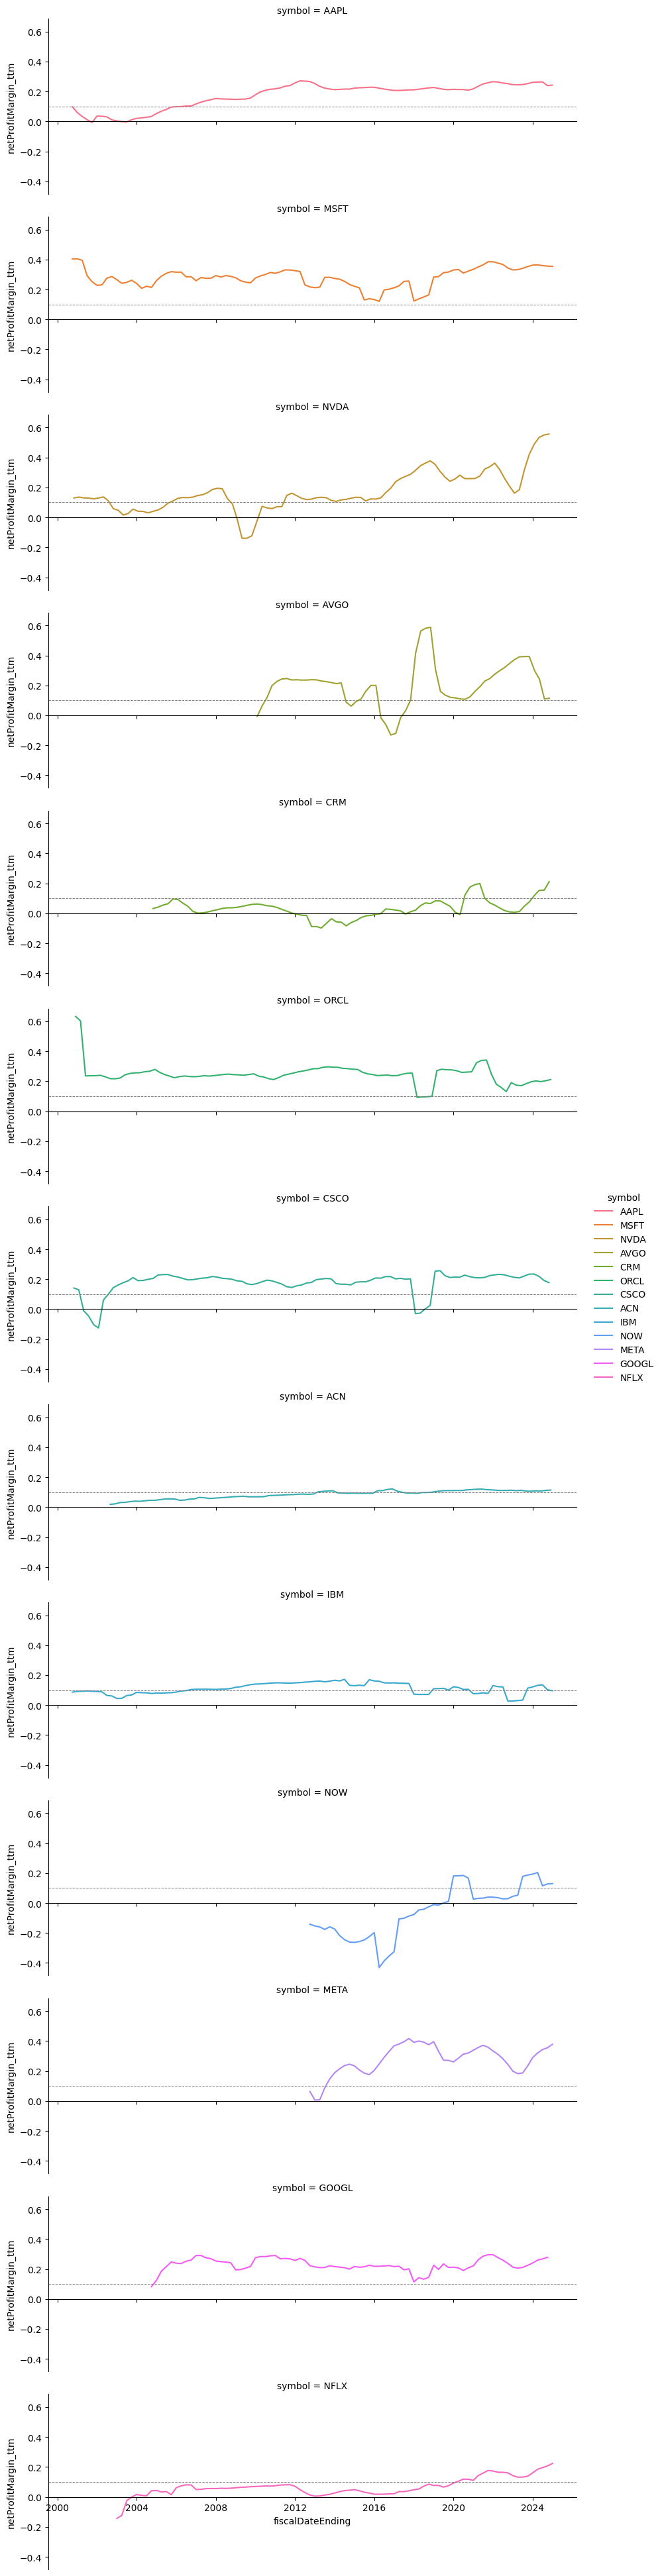

In [100]:
g = sns.relplot(
    data=financial_metrics_processed,
    y='netProfitMargin_ttm',
    x='fiscalDateEnding',
    row='symbol',
    hue='symbol',
    kind='line',
    height=3,
    aspect=3
)

# Apply formatting to each facet
for ax in g.axes.flat:
    ax.spines['bottom'].set_position(('data', 0))

# Add a horizontal line at y = 0 for each subplot
g.map(plt.axhline, y=0.1, color="grey", linestyle="--", linewidth=0.7)

#### Data consolidation

In [101]:
# initiate a dataframe records to store calendar days in the period for each ticker
data = []

for ticker in tickers:
    data.append(pd.DataFrame({'date': date_range, 'symbol': ticker}))
cons_data = pd.concat(data, ignore_index=True)

# Populate with stock data & marketCap
cons_data = pd.merge(cons_data, stock_df, left_on=['date', 'symbol'], right_on=['date', 'symbol'], how='outer')
cons_data = pd.merge(cons_data, marketcap_df, left_on=['date', 'symbol'], right_on=['date', 'symbol'], how='outer')
cons_data.sort_values(by=['symbol', 'date'], ascending=True, inplace=True)

# populate NaN within each symbol group with the latest available data
cons_data = cons_data.groupby('symbol').apply(lambda group: group.ffill()).reset_index(drop=True)

# view
display(cons_data.head())
display(cons_data.info())

date symbol  close  high  low  open       volume  dailyReturn   BOP  \
0 1999-12-31   AAPL   0.77  0.77 0.75  0.76 163811200.00          NaN  0.56   
1 2000-01-01   AAPL   0.77  0.77 0.75  0.76 163811200.00          NaN  0.56   
2 2000-01-02   AAPL   0.77  0.77 0.75  0.76 163811200.00          NaN  0.56   
3 2000-01-03   AAPL   0.84  0.85 0.77  0.79 535796800.00         0.09  0.65   
4 2000-01-04   AAPL   0.77  0.83 0.76  0.81 512377600.00        -0.08 -0.61   

   returnPre_5d  ...  BOP_SMA_15d  returnPost_1d  returnPost_2d  \
0           NaN  ...          NaN           0.09          -0.00   
1           NaN  ...          NaN           0.09          -0.00   
2           NaN  ...          NaN           0.09          -0.00   
3           NaN  ...          NaN          -0.08          -0.07   
4           NaN  ...          NaN           0.01          -0.07   

   returnPost_3d  returnPost_4d  returnPost_5d  returnPost_10d  \
0           0.01          -0.08          -0.03           -0.02   
1           0.01          -0.08          -0.03           -0.02   
2           0.01          -0.08          -0.03           -0.02   
3          -0.15          -0.11          -0.13           -0.07   
4          -0.03          -0.05          -0.10            0.04   

   returnPost_15d  returnPost_20d      marketCap  
0            0.03            0.01 16556793326.00  
1            0.03            0.01 16556793326.00  
2            0.03            0.01 16556793326.00  
3            0.00           -0.10 18153036603.00  
4            0.07           -0.04 16622604697.00  

[5 rows x 27 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119132 entries, 0 to 119131
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            119132 non-null  datetime64[ns]
 1   symbol          119132 non-null  object        
 2   close           101771 non-null  float64       
 3   high            101771 non-null  float64       
 4   low             101771 non-null  float64       
 5   open            101771 non-null  float64       
 6   volume          101771 non-null  float64       
 7   dailyReturn     101742 non-null  float64       
 8   BOP             101771 non-null  float64       
 9   returnPre_5d    101676 non-null  float64       
 10  closeCV_5d      101691 non-null  float64       
 11  BOP_SMA_5d      101691 non-null  float64       
 12  returnPre_10d   101581 non-null  float64       
 13  closeCV_10d     101598 non-null  float64       
 14  BOP_SMA_10d     101598 non-null  flo

None

In [102]:
macro_data.rename(columns={'periodEnd': 'date'}, inplace=True)

In [103]:
for ticker in tickers:
    macro_data = pd.merge(
        macro_data, cons_data[cons_data['symbol'] == ticker][['date', 'close']],
        how='left',
        left_on='date',
        right_on='date'
    )
    macro_data[f'{ticker}'] = macro_data['close'].pct_change(4)
    macro_data.drop(columns = ['close'], inplace=True)

display(macro_data.head(2))
display(macro_data.info())

date  RealGDP_pct_YoY  FedDebt_pct_YoY  CPI_pct_YoY  \
0 1999-03-31              NaN              NaN          NaN   
1 1999-06-30              NaN              NaN          NaN   

   Unemployment_bps_YoY  USTYield_10y_bps_YoY  AAPL  ACN  AVGO  CRM  CSCO  \
0                   NaN                   NaN   NaN  NaN   NaN  NaN   NaN   
1                   NaN                   NaN   NaN  NaN   NaN  NaN   NaN   

   GOOGL  IBM  META  MSFT  NFLX  NOW  NVDA  ORCL  
0    NaN  NaN   NaN   NaN   NaN  NaN   NaN   NaN  
1    NaN  NaN   NaN   NaN   NaN  NaN   NaN   NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  104 non-null    datetime64[ns]
 1   RealGDP_pct_YoY       100 non-null    float64       
 2   FedDebt_pct_YoY       99 non-null     float64       
 3   CPI_pct_YoY           100 non-null    float64       
 4   Unemployment_bps_YoY  96 non-null     float64       
 5   USTYield_10y_bps_YoY  97 non-null     float64       
 6   AAPL                  97 non-null     float64       
 7   ACN                   90 non-null     float64       
 8   AVGO                  58 non-null     float64       
 9   CRM                   79 non-null     float64       
 10  CSCO                  97 non-null     float64       
 11  GOOGL                 78 non-null     float64       
 12  IBM                   97 non-null     float64       
 13  META                

None

In [104]:
macro_data = pd.melt(
    macro_data, id_vars=['date', 'RealGDP_pct_YoY', 'FedDebt_pct_YoY', 'CPI_pct_YoY', 'Unemployment_bps_YoY', 'USTYield_10y_bps_YoY'],
    value_vars=['AAPL', 'MSFT', 'NVDA', 'AVGO', 'CRM', 'ORCL', 'CSCO', 'ACN', 'IBM', 'NOW', 'META', 'GOOGL', 'NFLX'],
    var_name='symbol', value_name='Return_pct_YoY')

macro_data.sort_values(by=['symbol', 'date'], ascending=True, inplace=True)

display(macro_data.head(2))
display(macro_data.info())

date  RealGDP_pct_YoY  FedDebt_pct_YoY  CPI_pct_YoY  \
0 1999-03-31              NaN              NaN          NaN   
1 1999-06-30              NaN              NaN          NaN   

   Unemployment_bps_YoY  USTYield_10y_bps_YoY symbol  Return_pct_YoY  
0                   NaN                   NaN   AAPL             NaN  
1                   NaN                   NaN   AAPL             NaN

<class 'pandas.core.frame.DataFrame'>
Index: 1352 entries, 0 to 623
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1352 non-null   datetime64[ns]
 1   RealGDP_pct_YoY       1300 non-null   float64       
 2   FedDebt_pct_YoY       1287 non-null   float64       
 3   CPI_pct_YoY           1300 non-null   float64       
 4   Unemployment_bps_YoY  1248 non-null   float64       
 5   USTYield_10y_bps_YoY  1261 non-null   float64       
 6   symbol                1352 non-null   object        
 7   Return_pct_YoY        1068 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 95.1+ KB


None

In [105]:
# Populate with financial metrics - merge on fiscalDateEnding
temp_data = pd.merge(
    cons_data, financial_metrics_processed,
    left_on=['date', 'symbol'],
    right_on=['fiscalDateEnding', 'symbol'],
    how='left',
    indicator=True
)

# populate NaN in newly added financial metrics columns within each symbol group with the latest available data
temp_data.sort_values(by=['symbol', 'date', 'fiscalDateEnding'], ascending=True, inplace=True)
temp_data[financial_metrics_processed.columns] = temp_data.groupby('symbol')[financial_metrics_processed.columns].fillna(method='ffill')

temp_data.columns

Index(['date', 'symbol', 'close', 'high', 'low', 'open', 'volume',
       'dailyReturn', 'BOP', 'returnPre_5d', 'closeCV_5d', 'BOP_SMA_5d',
       'returnPre_10d', 'closeCV_10d', 'BOP_SMA_10d', 'returnPre_15d',
       'closeCV_15d', 'BOP_SMA_15d', 'returnPost_1d', 'returnPost_2d',
       'returnPost_3d', 'returnPost_4d', 'returnPost_5d', 'returnPost_10d',
       'returnPost_15d', 'returnPost_20d', 'marketCap', 'fiscalDateEnding',
       'fillingDate', 'period', 'currentRatio', 'debtToAssets', 'debtToEquity',
       'grossProfitMargin_ttm', 'operatingProfitMargin_ttm',
       'netProfitMargin_ttm', 'returnOnAssets_ttm', 'returnOnEquity_ttm',
       'revenue_ttm', 'netIncome_ttm', 'operatingCashFlowSalesRatio_ttm',
       'dividendPaidAndCapexCoverageRatio_ttm', 'dividendPayoutRatio_ttm',
       'currentRatio_YoY_bps', 'debtToAssets_YoY_bps', 'debtToEquity_YoY_bps',
       'grossProfitMargin_ttm_YoY_bps', 'operatingProfitMargin_ttm_YoY_bps',
       'netProfitMargin_ttm_YoY_bps', 'returnO

In [106]:
macro_data = pd.merge(
    macro_data, temp_data[['date', 'symbol', 'revenue_qtly_YoY', 'operatingCashFlow_qtly_YoY', 'eps_is']],
    how='left',
    left_on=['date', 'symbol'],
    right_on=['date', 'symbol']
)

macro_data['eps_qtly_pct_YoY'] = macro_data['eps_is'].pct_change(4)
macro_data.drop(columns='eps_is', inplace=True)

display(macro_data.head(2))
display(macro_data.info())

date  RealGDP_pct_YoY  FedDebt_pct_YoY  CPI_pct_YoY  \
0 1999-03-31              NaN              NaN          NaN   
1 1999-06-30              NaN              NaN          NaN   

   Unemployment_bps_YoY  USTYield_10y_bps_YoY symbol  Return_pct_YoY  \
0                   NaN                   NaN   AAPL             NaN   
1                   NaN                   NaN   AAPL             NaN   

   revenue_qtly_YoY  operatingCashFlow_qtly_YoY  eps_qtly_pct_YoY  
0               NaN                         NaN               NaN  
1               NaN                         NaN               NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        1352 non-null   datetime64[ns]
 1   RealGDP_pct_YoY             1300 non-null   float64       
 2   FedDebt_pct_YoY             1287 non-null   float64       
 3   CPI_pct_YoY                 1300 non-null   float64       
 4   Unemployment_bps_YoY        1248 non-null   float64       
 5   USTYield_10y_bps_YoY        1261 non-null   float64       
 6   symbol                      1352 non-null   object        
 7   Return_pct_YoY              1068 non-null   float64       
 8   revenue_qtly_YoY            1074 non-null   float64       
 9   operatingCashFlow_qtly_YoY  1072 non-null   float64       
 10  eps_qtly_pct_YoY            1336 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage

None

In [107]:
macro_data

date  RealGDP_pct_YoY  FedDebt_pct_YoY  CPI_pct_YoY  \
0    1999-03-31              NaN              NaN          NaN   
1    1999-06-30              NaN              NaN          NaN   
2    1999-09-30              NaN              NaN          NaN   
3    1999-12-31              NaN              NaN          NaN   
4    2000-03-31             4.22             2.15         3.76   
...         ...              ...              ...          ...   
1347 2023-12-31             3.20             8.22         3.32   
1348 2024-03-31             2.90             9.94         3.47   
1349 2024-06-30             3.04             7.73         2.97   
1350 2024-09-30             2.72             6.93         2.43   
1351 2024-12-31             2.48              NaN         2.87   

      Unemployment_bps_YoY  USTYield_10y_bps_YoY symbol  Return_pct_YoY  \
0                      NaN                   NaN   AAPL             NaN   
1                      NaN                   NaN   AAPL             NaN   
2                      NaN                   NaN   AAPL             NaN   
3                      NaN                   NaN   AAPL             NaN   
4                      NaN                   NaN   AAPL             NaN   
...                    ...                   ...    ...             ...   
1347                  0.30                  0.00   ORCL            0.31   
1348                  0.40                  0.72   ORCL            0.37   
1349                  0.50                  0.55   ORCL            0.20   
1350                  0.30                 -0.78   ORCL            0.63   
1351                  0.30                  0.70   ORCL            0.60   

      revenue_qtly_YoY  operatingCashFlow_qtly_YoY  eps_qtly_pct_YoY  
0                  NaN                         NaN               NaN  
1                  NaN                         NaN               NaN  
2                  NaN                         NaN               NaN  
3                  NaN                         NaN               NaN  
4                  NaN                         NaN               NaN  
...                ...                         ...               ...  
1347              0.05                       -0.83              0.40  
1348              0.07                        0.28              0.24  
1349              0.03                        0.08             -0.07  
1350              0.07                        0.06              0.19  
1351              0.09                        8.12              0.24  

[1352 rows x 11 columns]

In [108]:
macro_data.columns

Index(['date', 'RealGDP_pct_YoY', 'FedDebt_pct_YoY', 'CPI_pct_YoY',
       'Unemployment_bps_YoY', 'USTYield_10y_bps_YoY', 'symbol',
       'Return_pct_YoY', 'revenue_qtly_YoY', 'operatingCashFlow_qtly_YoY',
       'eps_qtly_pct_YoY'],
      dtype='object')

In [109]:
macro_data = macro_data[['date', 'symbol', 'RealGDP_pct_YoY', 'FedDebt_pct_YoY', 'CPI_pct_YoY', \
                         'Unemployment_bps_YoY', 'USTYield_10y_bps_YoY', 'revenue_qtly_YoY', 'operatingCashFlow_qtly_YoY', 'Return_pct_YoY', 'eps_qtly_pct_YoY']]

In [110]:
macro_data['revenue_qtly_YoY'] = macro_data['revenue_qtly_YoY'] * 100
macro_data['eps_qtly_pct_YoY'] = macro_data['eps_qtly_pct_YoY'] * 100
macro_data['operatingCashFlow_qtly_YoY'] = macro_data['operatingCashFlow_qtly_YoY'] * 100

In [111]:
macro_data = macro_data.dropna()

In [112]:
# Populate with financial metrics - merge on fillingDate
cons_data = pd.merge(
    cons_data, financial_metrics_processed,
    left_on=['date', 'symbol'],
    right_on=['fillingDate', 'symbol'],
    how='left',
    indicator=True
)

cons_data['rep_flag'] = (cons_data['_merge'] == 'both').astype(int)
cons_data = cons_data.drop(columns=['_merge'])

# view
display(cons_data[cons_data.columns[0:10]].iloc[30:35])
display(cons_data.info())

date symbol  close  high  low  open       volume  dailyReturn   BOP  \
30 2000-01-30   AAPL   0.76  0.83 0.76  0.81 423348800.00        -0.08 -0.64   
31 2000-01-31   AAPL   0.78  0.78 0.71  0.76 701680000.00         0.02  0.29   
32 2000-02-01   AAPL   0.75  0.79 0.75  0.78 318035200.00        -0.03 -0.75   
33 2000-02-02   AAPL   0.74  0.77 0.73  0.76 464195200.00        -0.01 -0.38   
34 2000-02-03   AAPL   0.78  0.78 0.75  0.75 475193600.00         0.05  0.75   

    returnPre_5d  
30         -0.09  
31         -0.02  
32         -0.11  
33         -0.10  
34         -0.06

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119134 entries, 0 to 119133
Data columns (total 61 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   date                                           119134 non-null  datetime64[ns]
 1   symbol                                         119134 non-null  object        
 2   close                                          101773 non-null  float64       
 3   high                                           101773 non-null  float64       
 4   low                                            101773 non-null  float64       
 5   open                                           101773 non-null  float64       
 6   volume                                         101773 non-null  float64       
 7   dailyReturn                                    101744 non-null  float64       
 8   BOP                                         

None

**Note**:

Due to delayed quarterly reporting filings, where MSFT in 2021 and AAPL in 2026 submitted two consecutive quarter reports on the same date, the merged DataFrame contains two extra rows.

In [113]:
# populate NaN in newly added financial metrics columns within each symbol group with the latest available data
cons_data.sort_values(by=['symbol', 'date', 'fiscalDateEnding'], ascending=True, inplace=True)
cons_data[financial_metrics_processed.columns] = cons_data.groupby('symbol')[financial_metrics_processed.columns].fillna(method='ffill')

# view
display(cons_data[cons_data.columns[0:10]].iloc[30:35])
display(cons_data.info())

date symbol  close  high  low  open       volume  dailyReturn   BOP  \
30 2000-01-30   AAPL   0.76  0.83 0.76  0.81 423348800.00        -0.08 -0.64   
31 2000-01-31   AAPL   0.78  0.78 0.71  0.76 701680000.00         0.02  0.29   
32 2000-02-01   AAPL   0.75  0.79 0.75  0.78 318035200.00        -0.03 -0.75   
33 2000-02-02   AAPL   0.74  0.77 0.73  0.76 464195200.00        -0.01 -0.38   
34 2000-02-03   AAPL   0.78  0.78 0.75  0.75 475193600.00         0.05  0.75   

    returnPre_5d  
30         -0.09  
31         -0.02  
32         -0.11  
33         -0.10  
34         -0.06

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119134 entries, 0 to 119133
Data columns (total 61 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   date                                           119134 non-null  datetime64[ns]
 1   symbol                                         119134 non-null  object        
 2   close                                          101773 non-null  float64       
 3   high                                           101773 non-null  float64       
 4   low                                            101773 non-null  float64       
 5   open                                           101773 non-null  float64       
 6   volume                                         101773 non-null  float64       
 7   dailyReturn                                    101744 non-null  float64       
 8   BOP                                         

None

In [114]:
# derive PE and Price-to-Sales
cons_data['peRatio'] = cons_data['marketCap'] / cons_data['netIncome_ttm']
cons_data['pSalesRatio'] = cons_data['marketCap'] / cons_data['revenue_ttm']
# drop redundant columns
cons_data.drop(columns=['netIncome_ttm', 'revenue_ttm'], inplace=True)


In [115]:
# Extract weekday and month
cons_data['weekday'] = cons_data['date'].dt.day_name()
cons_data['month'] = cons_data['date'].dt.month_name()

In [116]:
# Populate with earnings data - merge on amcEquivalentReportedDate
cons_data = pd.merge(
    cons_data, earnings_history_processed,
    left_on=['date', 'symbol'],
    right_on=['amcEquivalentEarnReportedDate', 'symbol'],
    how='outer',
    indicator=True
)

cons_data['ea_flag'] = (cons_data['_merge'] == 'both').astype(int)
cons_data = cons_data.drop(columns=['_merge'])
cons_data.sort_values(by=['symbol', 'date', 'fiscalDateEnding'], ascending=True, inplace=True)

# populate NaN within each symbol group with the latest available data
cons_data = cons_data.groupby('symbol').apply(lambda group: group.ffill()).reset_index(drop=True)

# Compute Earnings Filing Gap
cons_data['EarningsFilingGap'] = (cons_data['fillingDate'] - cons_data['amcEquivalentEarnReportedDate']).dt.days

# view
display(cons_data[cons_data.columns[0:10]].iloc[30:35])
display(cons_data.info())

date symbol  close  high  low  open       volume  dailyReturn   BOP  \
30 2000-01-30   AAPL   0.76  0.83 0.76  0.81 423348800.00        -0.08 -0.64   
31 2000-01-31   AAPL   0.78  0.78 0.71  0.76 701680000.00         0.02  0.29   
32 2000-02-01   AAPL   0.75  0.79 0.75  0.78 318035200.00        -0.03 -0.75   
33 2000-02-02   AAPL   0.74  0.77 0.73  0.76 464195200.00        -0.01 -0.38   
34 2000-02-03   AAPL   0.78  0.78 0.75  0.75 475193600.00         0.05  0.75   

    returnPre_5d  
30         -0.09  
31         -0.02  
32         -0.11  
33         -0.10  
34         -0.06

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119134 entries, 0 to 119133
Data columns (total 90 columns):
 #   Column                                         Non-Null Count   Dtype          
---  ------                                         --------------   -----          
 0   date                                           119134 non-null  datetime64[ns] 
 1   symbol                                         119134 non-null  object         
 2   close                                          101773 non-null  float64        
 3   high                                           101773 non-null  float64        
 4   low                                            101773 non-null  float64        
 5   open                                           101773 non-null  float64        
 6   volume                                         101773 non-null  float64        
 7   dailyReturn                                    101744 non-null  float64        
 8   BOP                               

None

In [117]:
cons_data

date symbol  close   high    low   open       volume  \
0      1999-12-31   AAPL   0.77   0.77   0.75   0.76 163811200.00   
1      2000-01-01   AAPL   0.77   0.77   0.75   0.76 163811200.00   
2      2000-01-02   AAPL   0.77   0.77   0.75   0.76 163811200.00   
3      2000-01-03   AAPL   0.84   0.85   0.77   0.79 535796800.00   
4      2000-01-04   AAPL   0.77   0.83   0.76   0.81 512377600.00   
...           ...    ...    ...    ...    ...    ...          ...   
119129 2025-01-27   ORCL 158.28 172.52 152.66 168.90  42201600.00   
119130 2025-01-28   ORCL 164.00 165.83 156.75 162.99  20319300.00   
119131 2025-01-29   ORCL 162.02 164.03 160.01 164.03   9866600.00   
119132 2025-01-30   ORCL 170.38 171.49 164.10 164.78  14981700.00   
119133 2025-01-31   ORCL 170.06 173.00 169.13 170.41   8722500.00   

        dailyReturn   BOP  returnPre_5d  ...  standRevSurpriseScore  \
0               NaN  0.56           NaN  ...                    NaN   
1               NaN  0.56           NaN  ...                    NaN   
2               NaN  0.56           NaN  ...                    NaN   
3              0.09  0.65           NaN  ...                    NaN   
4             -0.08 -0.61           NaN  ...                    NaN   
...             ...   ...           ...  ...                    ...   
119129        -0.14 -0.53         -0.02  ...                  -0.14   
119130         0.04  0.11         -0.05  ...                  -0.14   
119131        -0.01 -0.50         -0.12  ...                  -0.14   
119132         0.05  0.76         -0.09  ...                  -0.14   
119133        -0.00 -0.09         -0.07  ...                  -0.14   

        revSurpriseChange_QoQ  revenueEst_YoY  revenueAct_YoY  \
0                         NaN             NaN             NaN   
1                         NaN             NaN             NaN   
2                         NaN             NaN             NaN   
3                         NaN             NaN             NaN   
4                         NaN             NaN             NaN   
...                       ...             ...             ...   
119129                  -0.01            0.09            0.09   
119130                  -0.01            0.09            0.09   
119131                  -0.01            0.09            0.09   
119132                  -0.01            0.09            0.09   
119133                  -0.01            0.09            0.09   

        fiscalDateEnding_x  netProfitMargin  fiscalDateEnding_y  \
0                      NaT              NaN                 NaT   
1                      NaT              NaN                 NaT   
2                      NaT              NaN                 NaT   
3                      NaT              NaN                 NaT   
4                      NaT              NaN                 NaT   
...                    ...              ...                 ...   
119129          2024-11-30             0.22          2024-11-30   
119130          2024-11-30             0.22          2024-11-30   
119131          2024-11-30             0.22          2024-11-30   
119132          2024-11-30             0.22          2024-11-30   
119133          2024-11-30             0.22          2024-11-30   

        netProfitMargin_ttm_y  ea_flag  EarningsFilingGap  
0                         NaN        0                NaN  
1                         NaN        0                NaN  
2                         NaN        0                NaN  
3                         NaN        0                NaN  
4                         NaN        0                NaN  
...                       ...      ...                ...  
119129                   0.21        0               1.00  
119130                   0.21        0               1.00  
119131                   0.21        0               1.00  
119132                   0.21        0               1.00  
119133                   0.21        0               1.00  

[119134 rows x 90 column

### Data Extraction

#### Export Macro Data for EDA

In [118]:
macro_data.to_csv('macro_metrics_dataset.csv', index=False)

#### Export Earnings Dataset for EDA

In [119]:
# Subset features for earnings announcement date analysis
ea_features = ['symbol', 'amcEquivalentEarnReportedDate', 'earnReportedDate', 'earnReportedTime', 'fiscalDateEnding_ea', \
               'weekday', 'month', \
               'netProfitMargin', 'netProfitMargin_ttm_y', \
               'epsEst', 'epsAct', \
               'epsSurpriseAbs', 'epsSurprise_pct', 'standEpsSurpriseScore', 'epsSurpriseChange_QoQ', 'epsAct_YoY', \
               'revenueEst', 'revenueAct',
               'revSurpriseAbs', 'revSurprise_pct', 'standRevSurpriseScore', 'revSurpriseChange_QoQ', 'revenueAct_YoY', \
               'returnPre_5d', 'returnPre_15d', 'returnPre_10d', \
               'closeCV_5d', 'closeCV_15d', 'closeCV_10d', \
               'BOP_SMA_5d', 'BOP_SMA_15d', 'BOP_SMA_10d', \
               'returnPost_1d', 'returnPost_2d', 'returnPost_3d', 'returnPost_4d', 'returnPost_5d']

earnings_dataset = cons_data[cons_data['ea_flag'] == 1][ea_features].reset_index(drop=True)
display(earnings_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   symbol                         1018 non-null   object        
 1   amcEquivalentEarnReportedDate  1018 non-null   datetime64[ns]
 2   earnReportedDate               1018 non-null   datetime64[ns]
 3   earnReportedTime               1018 non-null   object        
 4   fiscalDateEnding_ea            1018 non-null   datetime64[ns]
 5   weekday                        1018 non-null   object        
 6   month                          1018 non-null   object        
 7   netProfitMargin                1017 non-null   float64       
 8   netProfitMargin_ttm_y          996 non-null    float64       
 9   epsEst                         1018 non-null   float64       
 10  epsAct                         1018 non-null   float64       
 11  epsSurpriseAbs   

None

In [120]:
earnings_dataset.isna().sum()

symbol                            0
amcEquivalentEarnReportedDate     0
earnReportedDate                  0
earnReportedTime                  0
fiscalDateEnding_ea               0
weekday                           0
month                             0
netProfitMargin                   1
netProfitMargin_ttm_y            22
epsEst                            0
epsAct                            0
epsSurpriseAbs                    0
epsSurprise_pct                   0
standEpsSurpriseScore            52
epsSurpriseChange_QoQ            16
epsAct_YoY                       37
revenueEst                        4
revenueAct                        1
revSurpriseAbs                    4
revSurprise_pct                   4
standRevSurpriseScore            69
revSurpriseChange_QoQ            25
revenueAct_YoY                   38
returnPre_5d                      0
returnPre_15d                     3
returnPre_10d                     0
closeCV_5d                        0
closeCV_15d                       3
closeCV_10d                       0
BOP_SMA_5d                        0
BOP_SMA_15d                       3
BOP_SMA_10d                       0
returnPost_1d                     0
returnPost_2d                     0
returnPost_3d                     0
returnPost_4d                     0
returnPost_5d                     0
dtype: int64

In [121]:
earnings_dataset.to_csv('earnings_dataset_export.csv', index=False)

# Phase 2 Define and Prep Data

## Phase 2 Context Definition

#### Import libraries and set settings

In [122]:
import warnings
import pandas as pd
import numpy as np
from urllib.request import urlopen
import certifi
import json
from datetime import timedelta
import yfinance as yf
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import datetime

In [123]:
# suppress all warning notifications
warnings.filterwarnings('ignore')

In [124]:
# disable scientific notation
np.set_printoptions(suppress=True)

# display all numeric values in the DataFrame in standard numeric format
pd.set_option('display.float_format', '{:.2f}'.format)

#### Define variables & set import and processing parameters

In [125]:
API_key = 'BhWCbXUvKrJaEf72uKrgxs30a8DT5Cgy'
statements = ['balance-sheet-statement', 'income-statement', 'cash-flow-statement']

In [126]:
# Define tickers
tickers = ['AAPL', 'MSFT', 'NVDA', 'AVGO', 'CRM', 'ORCL', 'CSCO', 'ACN', 'IBM', 'NOW', 'META', 'GOOGL', 'NFLX']

# Time range
#start_date = '1999-12-31'
#end_date = '2025-01-31'
start_date = datetime.date(1999, 12, 31)
end_date = datetime.date(2025, 1, 31)

# Create a date range from start_date to end_date
date_range = pd.date_range(start=start_date, end=end_date)

#### User-defined functions

##### General

In [127]:
def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

##### Ingest Daily MarketCap

In [128]:
# Ingest Daily Market cap data using recursive call to FMP

def get_daily_marketcap_extended(ticker, start_date, end_date, api_key):
    """
    Fetches market cap data for a given ticker by breaking the date range
    into 5-year chunks to handle API limitations.

    Parameters:
    ticker (str): Stock ticker symbol
    start_date (datetime.date): Start date
    end_date (datetime.date): End date
    api_key (str): API key for Financial Modeling Prep

    Returns:
    pandas.DataFrame: Combined market cap data for the entire date range
    """
    all_data = []
    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + datetime.timedelta(days=365 * 5), end_date)  # 5-year window
        url_marketcap = f"https://financialmodelingprep.com/api/v3/historical-market-capitalization/{ticker}?from={current_start.strftime('%Y-%m-%d')}&to={current_end.strftime('%Y-%m-%d')}&apikey={api_key}"
        marketcap_data = pd.DataFrame(get_jsonparsed_data(url_marketcap))

        if not marketcap_data.empty:
            marketcap_data['date'] = pd.to_datetime(marketcap_data['date'])
            marketcap_data = marketcap_data[['date', 'symbol', 'marketCap']]
            all_data.append(marketcap_data)
            print(f"MarketCap Data for {ticker} retrieved from {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}")
        else:
            print(f"Warning: No data found for {ticker} from {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}")

        current_start = current_end + datetime.timedelta(days=1)

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df = combined_df[(combined_df['date'] >= pd.Timestamp(start_date)) & (combined_df['date'] <= pd.Timestamp(end_date))]
        return combined_df
    else:
        print(f"No market cap data found for {ticker} within the specified date range.")
        return pd.DataFrame()

##### Ingest Financial statemensts (BS, IS, CF)

In [129]:
# Quarterly Financial Reports
def get_fin_statements(ticker, statement):
    url_statement = f"https://financialmodelingprep.com/api/v3/{statement}/{ticker}?period=quarter&apikey={API_key}"
    try:
        data_statement = get_jsonparsed_data(url_statement)
        finstatement = pd.DataFrame(data_statement)
    except:
        print(f"Error fetching {statement} data for {ticker}")
        return None, None

    if finstatement is None:
        return None, None

    finstatement['date'] = pd.to_datetime(finstatement['date'])
    finstatement['fillingDate'] = pd.to_datetime(finstatement['fillingDate'])
    finstatement.drop(columns = ['cik','acceptedDate','reportedCurrency','calendarYear','link','finalLink'],inplace=True)
    finstatement = finstatement[(finstatement['date'] >= start_date.strftime("%Y-%m-%d")) & \
    (finstatement['fillingDate'] <= end_date.strftime("%Y-%m-%d"))]
    finstatement.set_index('date', inplace=True)
    finstatement.sort_index(ascending=True, inplace=True)

    return finstatement, ticker, statement

##### Ingest Financial metrics & ratios

In [130]:
# Financial Metrics and Ratios
def get_financial_data(ticker):
    # Metrics
    url_metrics = f"https://financialmodelingprep.com/api/v3/key-metrics/{ticker}?period=quarter&apikey={API_key}"
    try:
      data_metrics = get_jsonparsed_data(url_metrics)
      finmetrics = pd.DataFrame(data_metrics)
      print(f"Import is completed for {ticker} key-metrics")
    except:
      print(f"Error fetching metrics data for {ticker}")
      return None, None

    # Ratios
    url_ratios = f"https://financialmodelingprep.com/api/v3/ratios/{ticker}?period=quarter&apikey={API_key}"
    try:
      data_ratios = get_jsonparsed_data(url_ratios)
      finratios = pd.DataFrame(data_ratios)
      print(f"Import is completed for {ticker} ratios")
    except:
      print(f"Error fetching ratios data for {ticker}")
      return None, None

    if finmetrics is None or finratios is None:
      return None, None

    # Combine and process data
    finmetrics['date'] = pd.to_datetime(finmetrics['date'])
    finratios['date'] = pd.to_datetime(finratios['date'])
    finmetrics = finmetrics[(finmetrics['date'] >= start_date.strftime("%Y-%m-%d")) & (finmetrics['date'] <= end_date.strftime("%Y-%m-%d"))]
    finratios = finratios[(finratios['date'] >= start_date.strftime("%Y-%m-%d")) & (finratios['date'] <= end_date.strftime("%Y-%m-%d"))]
    financials = pd.merge(finmetrics, finratios, on='date', how='left')
    financials.set_index('date', inplace=True)
    financials.sort_index(ascending=True, inplace=True)

    return financials, ticker

##### Financial data processing

In [131]:
def combine_financial_data(ticker_data):
    # Data Ingestion
    bal = ticker_data[0].reset_index().add_suffix('_bs').rename(columns={'date_bs': 'date'})
    is_ = ticker_data[1].reset_index().add_suffix('_is').rename(columns={'date_is': 'date'})
    cf = ticker_data[2].reset_index().add_suffix('_cf').rename(columns={'date_cf': 'date'})
    ratios = ticker_data[3].reset_index()

    # Merged base Dataframe creation
    df = pd.merge(bal, is_, how='left', on='date')
    df = pd.merge(df, cf, how='left', on='date')
    df = pd.merge(df, ratios, on='date')

    # rename columns
    df.rename(columns={'currentRatio_x': 'currentRatio', 'symbol_bs': 'symbol', 'fillingDate_bs': 'fillingDate', \
                       'period_bs': 'period', 'date': 'fiscalDateEnding'}, inplace=True)

    # Sort data chronologically
    df.sort_values(by='fiscalDateEnding', ascending=True, inplace=True)
    df['daysInPeriod'] = df['fiscalDateEnding'] - df['fiscalDateEnding'].shift(1)

    return df

**Summary**: In essence, the process_financial_data function takes raw financial data and transforms it into a more informative dataset by adding features that capture key financial trends and ratios, making it potentially more valuable for financial analysis or modeling.

It calculates trailing twelve months (TTM) values for margins, profitability, cash flow, and growth metrics. Additionally, it derives year-over-year (YoY) changes and creates TTM revenue and net income for subsequent daily valuation calculations. These derived features aim to provide a more comprehensive view of financial performance for analysis and modeling


In [132]:
def process_financial_data(df):

    # Sort data chronologically
    df.sort_values(by='fiscalDateEnding', ascending=True, inplace=True)
    df['daysInPeriod'] = df['fiscalDateEnding'] - df['fiscalDateEnding'].shift(1)

    # Margins, ttm
    df['grossProfitMargin_ttm'] = (
        df['grossProfit_is'].rolling(window=4).sum() /
        df['revenue_is'].rolling(window=4).sum()
    )

    df['operatingProfitMargin_ttm'] = (
        df['operatingIncome_is'].rolling(window=4).sum() /
        df['revenue_is'].rolling(window=4).sum()
    )

    df['netProfitMargin_ttm'] = (
        df['netIncome_is'].rolling(window=4).sum() /
        df['revenue_is'].rolling(window=4).sum()
    )


    # ROA, ROE; ttm
    df['returnOnAssets_ttm'] = (
        df['netIncome_is'].rolling(window=4).sum() /
        df['totalAssets_bs']
    )

    df['returnOnEquity_ttm'] = (
        df['netIncome_is'].rolling(window=4).sum() /
        df['totalStockholdersEquity_bs']
    )

    # CF metrics
    df['operatingCashFlowSalesRatio_ttm'] = (
        df['operatingCashFlow_cf'].rolling(window=4).sum() /
        df['revenue_is'].rolling(window=4).sum()
    )


    df['dividendPaidAndCapexCoverageRatio_ttm'] = (
        -df['netCashProvidedByOperatingActivities_cf'].rolling(window=4).sum() /
        (
            df['dividendsPaid_cf'].rolling(window=4).sum() +
            df['investmentsInPropertyPlantAndEquipment_cf'].rolling(window=4).sum()
        )
    )


    df['dividendPayoutRatio_ttm'] = (
        -df['dividendsPaid_cf'].rolling(window=4).sum() /
        df['netIncome_is'].rolling(window=4).sum()
    )

    # growth rates
    df['totalAssets_YoY'] = df['totalAssets_bs'].pct_change(periods=4)

    df['revenue_qtly_YoY'] = df['revenue_is'].pct_change(periods=4)

    df['revenue_ttm_YoY'] = (
        df['revenue_is'].rolling(window=4).sum() /
        df['revenue_is'].shift(4).rolling(window=4).sum() - 1
    )

    df['operatingCashFlow_qtly_YoY'] = df['operatingCashFlow_cf'].pct_change(periods=4)

    df['operatingCashFlow_ttm_YoY'] = (
        df['operatingCashFlow_cf'].rolling(window=4).sum() /
        df['operatingCashFlow_cf'].shift(4).rolling(window=4).sum() - 1
    )

    # change, bps
    metrics = ['grossProfitMargin_ttm', 'operatingProfitMargin_ttm', 'netProfitMargin_ttm', 'netProfitMargin', 'returnOnAssets_ttm', \
               'returnOnEquity_ttm', 'operatingCashFlowSalesRatio_ttm', 'dividendPaidAndCapexCoverageRatio_ttm', \
               'dividendPayoutRatio_ttm', 'currentRatio', 'debtToAssets', 'debtToEquity']

    for metric in metrics:
        df[f'{metric}_YoY_bps'] = (df[metric] - df[metric].shift(4)) * 100

    # ttm pl items to be used to derive daily p/e, p/sales
    df['revenue_ttm'] = df['revenue_is'].rolling(window=4).sum()
    df['netIncome_ttm'] = df['netIncome_is'].rolling(window=4).sum()

    return df

##### Ingest Earnings data

In [133]:
def get_earnings_history(ticker):
    """
    Fetches raw earnings history data from the Financial Modeling Prep API.

    Args:
        ticker (str): Stock ticker symbol.
        api_key (str): API key for authentication.

    Returns:
        pd.DataFrame: Raw earnings data.
    """
    url_earn = f"https://financialmodelingprep.com/api/v3/historical/earning_calendar/{ticker}?apikey={API_key}"
    return pd.DataFrame(get_jsonparsed_data(url_earn))

**Summary**: the preprocess_earnings_data function transforms raw earnings data into a more informative dataset by adding features capturing key financial trends and surprises, making it more valuable for financial modeling and analysis. This enhanced dataset can be further utilized for tasks such as stock price prediction or investment strategy development.



In [134]:
def preprocess_earnings_data(earn_statement):
    """
    Preprocesses earnings history data by adding derived features.

    Args:
        earn_statement (pd.DataFrame): Raw earnings data.

    Returns:
        pd.DataFrame: Preprocessed earnings data (without renaming columns or filtering dates).
    """

    # Calculate earnings and revenue surprises
    earn_statement['epsSurpriseAbs'] = earn_statement['eps'] - earn_statement['epsEstimated']

    # Apply condition to set epsSurpriseAbs to NaN (negative estimations result in non-meaningful surprise %)
    # If -100 was expected, and actual is -120; surprise percentage derived is -120/-100 -1 = 20%
    #earn_statement.loc[earn_statement['epsEstimated'] <= 0, 'epsSurpriseAbs'] = np.nan

    earn_statement['epsSurprise_pct'] = earn_statement['epsSurpriseAbs'] / earn_statement['epsEstimated'].abs()
    earn_statement['revSurpriseAbs'] = earn_statement['revenue'] - earn_statement['revenueEstimated']
    earn_statement['revSurprise_pct'] = earn_statement['revSurpriseAbs'] / earn_statement['revenueEstimated'].abs()

    # Sort data chronologically
    earn_statement.sort_values(by=['symbol', 'fiscalDateEnding'], ascending=True, inplace=True)
    earn_statement['daysInPeriod'] = earn_statement.groupby('symbol')['fiscalDateEnding'].diff(periods=1)

    # Standardised EPS Surprise Score
    earn_statement['standEpsSurpriseScore'] = earn_statement.groupby('symbol', group_keys=False).apply(
        lambda group: group[['epsSurpriseAbs']].assign(
            standEpsSurpriseScore=group['epsSurpriseAbs'] /
            group['epsSurpriseAbs'].rolling(window=12, min_periods=4).std().shift(1)
        ),
        include_groups=False
    )['standEpsSurpriseScore']

    # EPS surprise change QoQ
    earn_statement['epsSurpriseChange_QoQ'] = earn_statement.groupby('symbol')['epsSurprise_pct'].diff(periods=1)

    # Expected EPS growth rate from the same quarter one year ago
    earn_statement['epsEst_YoY'] = earn_statement.groupby('symbol', group_keys=False).apply(
        lambda group: group[['epsEstimated']].assign(epsEst_YoY=group['epsEstimated'] / group['eps'].shift(4) - 1),
        include_groups=False
    )['epsEst_YoY']

    # Actual EPS growth rate from the same quarter one year ago
    earn_statement['epsAct_YoY'] = earn_statement.groupby('symbol')['eps'].pct_change(periods=4)

    # Standardised Revenue Surprise Score
    earn_statement['standRevSurpriseScore'] = earn_statement.groupby('symbol', group_keys=False).apply(
        lambda group: group[['revSurpriseAbs']].assign(
            standRevSurpriseScore=group['revSurpriseAbs'] /
            group['revSurpriseAbs'].rolling(window=12, min_periods=4).std().shift(1)
        ),
        include_groups=False
    )['standRevSurpriseScore']

    # Revenue surprise change QoQ
    earn_statement['revSurpriseChange_QoQ'] = earn_statement.groupby('symbol')['revSurprise_pct'].diff(periods=1)

    # Expected revenue growth rate from the same quarter one year ago
    earn_statement['revenueEst_YoY'] = earn_statement.groupby('symbol', group_keys=False).apply(
        lambda group: group[['revenueEstimated']].assign(revenueEst_YoY=group['revenueEstimated'] / group['revenue'].shift(4) - 1),
        include_groups=False
    )['revenueEst_YoY']

    # Actual revenue growth rate from the same quarter one year ago
    earn_statement['revenueAct_YoY'] = earn_statement.groupby('symbol')['revenue'].pct_change(periods=4)

    # Rename columns
    earn_statement.rename(columns={
        'date': 'earnReportedDate',
        'time': 'earnReportedTime',
        'eps': 'epsAct',
        'epsEstimated': 'epsEst',
        'revenueEstimated': 'revenueEst',
        'revenue': 'revenueAct',
        'fiscalDateEnding': 'fiscalDateEnding_ea'
    }, inplace=True)


    return earn_statement

## Phase 2 Data Preparation

#### Stock data

In [135]:
# Create an empty list to store data for each ticker
all_data = []

# Loop through each ticker
for ticker in tickers:
    # Download data using yfinance
    data = yf.download(ticker, start=start_date, end=end_date + timedelta(days=1))

    # Reset index to make 'Date' a column
    data = data.reset_index()

    # Flatten Multiindex columns
    data.columns = ['_'.join(col).strip() for col in data.columns.values]

    # Rename columns to desired format
    data.columns = [col.replace(f'_{ticker}', '').replace('Date_', 'date') for col in data.columns]

    # Add a 'Ticker' column
    data['symbol'] = ticker

    # Reorder columns as desired and rename
    data = data[['date', 'symbol', 'Close', 'High', 'Low', 'Open', 'Volume']]
    data.columns = ['date', 'symbol', 'close', 'high', 'low', 'open', 'volume']

    # Convert float columns to 2 decimal points
    float_cols = data.select_dtypes(include=['float']).columns

    # Append data to the list
    all_data.append(data)

# Concatenate all data into a single DataFrame
stock_df = pd.concat(all_data, ignore_index=True)

# Display the first few rows of the DataFrame
display(stock_df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


date symbol  close  high  low  open     volume
0 1999-12-31   AAPL   0.77  0.77 0.75  0.76  163811200
1 2000-01-03   AAPL   0.84  0.85 0.77  0.79  535796800
2 2000-01-04   AAPL   0.77  0.83 0.76  0.81  512377600
3 2000-01-05   AAPL   0.78  0.83 0.77  0.78  778321600
4 2000-01-06   AAPL   0.71  0.81 0.71  0.80  767972800

In [136]:
# Ensure data is sorted chronologically & derive features
stock_df = stock_df.sort_values(by=['symbol', 'date'], ascending=True)

# return
stock_df['dailyReturn'] = stock_df.groupby('symbol')['close'].pct_change(periods=1)

# Balance of Power (BOP)
stock_df['BOP'] = (stock_df['close'] - stock_df['open']) / (stock_df['high'] - stock_df['low'])

#
pre_windows = [1, 2, 3, 4, 5, 10, 15]
for window in pre_windows:
    # return
    stock_df[f'returnPre_{window}d'] = stock_df.groupby('symbol')['close'].pct_change(periods=window)

    # Coefficient of variation
    stock_df[f'closeCV_{window}d'] = (
        stock_df.groupby('symbol')['close'].transform(
            lambda x: x.rolling(window=window).std() / x.rolling(window=window).mean()
        )
    )
    # Balance of Power (BOP)
    stock_df[f'BOP_SMA_{window}d'] = (
        stock_df.groupby('symbol')['BOP'].transform(
            lambda x: x.rolling(window=window).mean()
        )
    )

# calculate ReturnPost
post_windows = [1, 2, 3, 4, 5, 10, 15, 20]
for window in post_windows:
    stock_df[f'returnPost_{window}d'] = (
        stock_df.groupby('symbol')['close'].transform(
            lambda x: x.shift(periods=-window) / x - 1
        )
    )

# Display the first few rows of the DataFrame
display(stock_df.head(10))
print(stock_df.info())

date symbol  close  high  low  open      volume  dailyReturn   BOP  \
0 1999-12-31   AAPL   0.77  0.77 0.75  0.76   163811200          NaN  0.56   
1 2000-01-03   AAPL   0.84  0.85 0.77  0.79   535796800         0.09  0.65   
2 2000-01-04   AAPL   0.77  0.83 0.76  0.81   512377600        -0.08 -0.61   
3 2000-01-05   AAPL   0.78  0.83 0.77  0.78   778321600         0.01  0.03   
4 2000-01-06   AAPL   0.71  0.81 0.71  0.80   767972800        -0.09 -0.93   
5 2000-01-07   AAPL   0.75  0.76 0.72  0.73   460734400         0.05  0.55   
6 2000-01-10   AAPL   0.74  0.77 0.71  0.77   505064000        -0.02 -0.57   
7 2000-01-11   AAPL   0.70  0.75 0.68  0.72   441548800        -0.05 -0.36   
8 2000-01-12   AAPL   0.66  0.72 0.65  0.71   976068800        -0.06 -0.87   
9 2000-01-13   AAPL   0.73  0.74 0.70  0.71  1032684800         0.11  0.36   

   returnPre_1d  ...  closeCV_15d  BOP_SMA_15d  returnPost_1d  returnPost_2d  \
0           NaN  ...          NaN          NaN           0.09          -0.00   
1          0.09  ...          NaN          NaN          -0.08          -0.07   
2         -0.08  ...          NaN          NaN           0.01          -0.07   
3          0.01  ...          NaN          NaN          -0.09          -0.04   
4         -0.09  ...          NaN          NaN           0.05           0.03   
5          0.05  ...          NaN          NaN          -0.02          -0.07   
6         -0.02  ...          NaN          NaN          -0.05          -0.11   
7         -0.05  ...          NaN          NaN          -0.06           0.04   
8         -0.06  ...          NaN          NaN           0.11           0.15   
9          0.11  ...          NaN          NaN           0.04           0.07   

   returnPost_3d  returnPost_4d  returnPost_5d  returnPost_10d  \
0           0.01          -0.08          -0.03           -0.02   
1          -0.15          -0.11          -0.13           -0.07   
2          -0.03          -0.05          -0.10            0.04   
3          -0.06          -0.11          -0.16            0.09   
4          -0.02          -0.08           0.02            0.17   
5          -0.12          -0.03           0.01            0.07   
6          -0.01           0.03           0.06            0.15   
7           0.08           0.12           0.15            0.19   
8           0.19           0.22           0.30            0.26   
9           0.10           0.17           0.15            0.05   

   returnPost_15d  returnPost_20d  
0            0.03            0.01  
1            0.00           -0.10  
2            0.07           -0.04  
3            0.06           -0.01  
4            0.07            0.14  
5            0.04            0.15  
6            0.03            0.18  
7            0.07            0.21  
8            0.18            0.30  
9            0.12            0.12  

[10 rows x 38 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 70083 entries, 0 to 34323
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            70083 non-null  datetime64[ns]
 1   symbol          70083 non-null  object        
 2   close           70083 non-null  float64       
 3   high            70083 non-null  float64       
 4   low             70083 non-null  float64       
 5   open            70083 non-null  float64       
 6   volume          70083 non-null  int64         
 7   dailyReturn     70070 non-null  float64       
 8   BOP             70083 non-null  float64       
 9   returnPre_1d    70070 non-null  float64       
 10  closeCV_1d      0 non-null      float64       
 11  BOP_SMA_1d      70083 non-null  float64       
 12  returnPre_2d    70057 non-null  float64       
 13  closeCV_2d      70070 non-null  float64       
 14  BOP_SMA_2d      70070 non-null  float64       
 15  returnP

#### MarketCap data

In [137]:
# get marketcap data
marketcap_list = []
for ticker in tickers:
    marketcap_data = get_daily_marketcap_extended(ticker, start_date, end_date, API_key)
    if not marketcap_data.empty:
        marketcap_list.append(marketcap_data)
    else:
        print(f"Skipping {ticker} due to lack of data")

marketcap_df = pd.concat(marketcap_list, ignore_index=True)

# Sort by Date and Ticker
marketcap_df.sort_values(by=['symbol', 'date'], inplace=True)

# Reset Index
marketcap_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the DataFrame
display(marketcap_df)

MarketCap Data for AAPL retrieved from 1999-12-31 to 2004-12-29
MarketCap Data for AAPL retrieved from 2004-12-30 to 2009-12-29
MarketCap Data for AAPL retrieved from 2009-12-30 to 2014-12-29
MarketCap Data for AAPL retrieved from 2014-12-30 to 2019-12-29
MarketCap Data for AAPL retrieved from 2019-12-30 to 2024-12-28
MarketCap Data for AAPL retrieved from 2024-12-29 to 2025-01-31
MarketCap Data for MSFT retrieved from 1999-12-31 to 2004-12-29
MarketCap Data for MSFT retrieved from 2004-12-30 to 2009-12-29
MarketCap Data for MSFT retrieved from 2009-12-30 to 2014-12-29
MarketCap Data for MSFT retrieved from 2014-12-30 to 2019-12-29
MarketCap Data for MSFT retrieved from 2019-12-30 to 2024-12-28
MarketCap Data for MSFT retrieved from 2024-12-29 to 2025-01-31
MarketCap Data for NVDA retrieved from 1999-12-31 to 2004-12-29
MarketCap Data for NVDA retrieved from 2004-12-30 to 2009-12-29
MarketCap Data for NVDA retrieved from 2009-12-30 to 2014-12-29
MarketCap Data for NVDA retrieved from 2

date symbol     marketCap
0     1999-12-31   AAPL   16556793326
1     2000-01-03   AAPL   18153036603
2     2000-01-04   AAPL   16622604697
3     2000-01-05   AAPL   16865810052
4     2000-01-06   AAPL   15406214657
...          ...    ...           ...
70078 2025-01-27   ORCL  441601200000
70079 2025-01-28   ORCL  457560000000
70080 2025-01-29   ORCL  452035800000
70081 2025-01-30   ORCL  475360200000
70082 2025-01-31   ORCL  474467400000

[70083 rows x 3 columns]

#### Macro

**Note**:

According to the Federal Reserve Economic Data (FRED) guidelines, economic data for a given period are represented by the first day of that period. Quarterly data are assigned to the first day of the respective quarter, monthly data to the first day of the month, and annual data to January 1 of the corresponding year.

https://fredhelp.stlouisfed.org/fred/data/understanding-the-data/date-format/?utm_source=chatgpt.com
C1/

Real Gross Domestic Product (GDPC1): https://fred.stlouisfed.org/series/GDPC1/

In [138]:
# GDP Data
gdp_df = pdr.get_data_fred('GDPC1', start=start_date-datetime.timedelta(days=366), end=end_date)

# GDP Growth QoQ and YoY
gdp_df['Real_GDP_GrowthPCT_QoQ'] = gdp_df['GDPC1'].pct_change(1) * 100
gdp_df['Real_GDP_GrowthPCT_YoY'] = gdp_df['GDPC1'].pct_change(4) * 100  # 4 quarters in a year

# Reorder and Rename Columns
gdp_df = gdp_df[['GDPC1', 'Real_GDP_GrowthPCT_QoQ', 'Real_GDP_GrowthPCT_YoY']]
gdp_df = gdp_df.reset_index()
gdp_df = gdp_df.rename(columns={'DATE': 'periodStart', 'GDPC1': 'Real_GDP'})

# Compute periodEnd (last day of the respective quarter)
gdp_df['periodEnd'] = gdp_df['periodStart'] + pd.offsets.QuarterEnd(0)

# Print the GDP dataframe
display(gdp_df)

periodStart  Real_GDP  Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY  \
0    1999-01-01  13315.60                     NaN                     NaN   
1    1999-04-01  13426.75                    0.83                     NaN   
2    1999-07-01  13604.77                    1.33                     NaN   
3    1999-10-01  13827.98                    1.64                     NaN   
4    2000-01-01  13878.15                    0.36                    4.22   
..          ...       ...                     ...                     ...   
99   2023-10-01  22960.60                    0.79                    3.20   
100  2024-01-01  23053.54                    0.40                    2.90   
101  2024-04-01  23223.91                    0.74                    3.04   
102  2024-07-01  23400.29                    0.76                    2.72   
103  2024-10-01  23530.91                    0.56                    2.48   

     periodEnd  
0   1999-03-31  
1   1999-06-30  
2   1999-09-30  
3   1999-12-31  
4   2000-03-31  
..         ...  
99  2023-12-31  
100 2024-03-31  
101 2024-06-30  
102 2024-09-30  
103 2024-12-31  

[104 rows x 5 columns]

In [139]:
gdp_df.columns

Index(['periodStart', 'Real_GDP', 'Real_GDP_GrowthPCT_QoQ',
       'Real_GDP_GrowthPCT_YoY', 'periodEnd'],
      dtype='object')

In [140]:
macro_data = gdp_df[['Real_GDP_GrowthPCT_QoQ','Real_GDP_GrowthPCT_YoY', 'periodEnd']]

Federal Debt: Total Public Debt (GFDEBTN): https://fred.stlouisfed.org/series/GFDEBTN/

In [141]:
# Federal Debt Data
debt_df = pdr.get_data_fred('GFDEBTN', start=start_date-datetime.timedelta(days=366), end=end_date)

# Federal Debt Growth QoQ and YoY
debt_df['Fed_debt_GrowthPCT_QoQ'] = debt_df['GFDEBTN'].pct_change(1) * 100
debt_df['Fed_debt_GrowthPCT_YoY'] = debt_df['GFDEBTN'].pct_change(4) * 100  # 4 quarters in a year

# Reorder and Rename Columns
debt_df = debt_df[['GFDEBTN', 'Fed_debt_GrowthPCT_QoQ', 'Fed_debt_GrowthPCT_YoY']]
debt_df = debt_df.reset_index()
debt_df = debt_df.rename(columns={'DATE': 'periodStart', 'GFDEBTN': 'Fed_debt'})

# Compute periodEnd (last day of the respective quarter)
debt_df['periodEnd'] = debt_df['periodStart'] + pd.offsets.QuarterEnd(0)

# Print
display(debt_df)

periodStart  Fed_debt  Fed_debt_GrowthPCT_QoQ  Fed_debt_GrowthPCT_YoY  \
0    1999-01-01   5651615                     NaN                     NaN   
1    1999-04-01   5638780                   -0.23                     NaN   
2    1999-07-01   5656271                    0.31                     NaN   
3    1999-10-01   5776091                    2.12                     NaN   
4    2000-01-01   5773392                   -0.05                    2.15   
..          ...       ...                     ...                     ...   
98   2023-07-01  33167334                    2.58                    7.24   
99   2023-10-01  34001494                    2.52                    8.22   
100  2024-01-01  34586533                    1.72                    9.94   
101  2024-04-01  34831634                    0.71                    7.73   
102  2024-07-01  35464674                    1.82                    6.93   

     periodEnd  
0   1999-03-31  
1   1999-06-30  
2   1999-09-30  
3   1999-12-31  
4   2000-03-31  
..         ...  
98  2023-09-30  
99  2023-12-31  
100 2024-03-31  
101 2024-06-30  
102 2024-09-30  

[103 rows x 5 columns]

In [142]:
debt_df.columns

Index(['periodStart', 'Fed_debt', 'Fed_debt_GrowthPCT_QoQ',
       'Fed_debt_GrowthPCT_YoY', 'periodEnd'],
      dtype='object')

In [143]:
macro_data = pd.merge(
    macro_data, debt_df[['Fed_debt_GrowthPCT_QoQ', 'Fed_debt_GrowthPCT_YoY', 'periodEnd']],
    how='left',
    left_on='periodEnd',
    right_on='periodEnd'
)

display(macro_data.head())
display(macro_data.info())

Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY  periodEnd  \
0                     NaN                     NaN 1999-03-31   
1                    0.83                     NaN 1999-06-30   
2                    1.33                     NaN 1999-09-30   
3                    1.64                     NaN 1999-12-31   
4                    0.36                    4.22 2000-03-31   

   Fed_debt_GrowthPCT_QoQ  Fed_debt_GrowthPCT_YoY  
0                     NaN                     NaN  
1                   -0.23                     NaN  
2                    0.31                     NaN  
3                    2.12                     NaN  
4                   -0.05                    2.15

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Real_GDP_GrowthPCT_QoQ  103 non-null    float64       
 1   Real_GDP_GrowthPCT_YoY  100 non-null    float64       
 2   periodEnd               104 non-null    datetime64[ns]
 3   Fed_debt_GrowthPCT_QoQ  102 non-null    float64       
 4   Fed_debt_GrowthPCT_YoY  99 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.2 KB


None

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL): https://fred.stlouisfed.org/series/CPIAUCSL

In [144]:
# CPI Data
cpi_df = pdr.get_data_fred('CPIAUCSL', start=start_date-datetime.timedelta(days=366), end=end_date)

# CPI Inflation MoM and YoY
cpi_df['CPI_InflationPCT_MoM'] = cpi_df['CPIAUCSL'].pct_change(1) * 100
cpi_df['CPI_InflationPCT_YoY'] = cpi_df['CPIAUCSL'].pct_change(12) * 100

# Reorder and Rename Columns
cpi_df = cpi_df[['CPIAUCSL', 'CPI_InflationPCT_MoM', 'CPI_InflationPCT_YoY']]
cpi_df = cpi_df.reset_index()
cpi_df = cpi_df.rename(columns={'DATE': 'periodStart', 'CPIAUCSL': 'CPI'})

cpi_df['periodEnd'] = cpi_df['periodStart'] + pd.offsets.MonthEnd(1)

# Convert float columns to 2 decimal points
float_cols = cpi_df.select_dtypes(include=['float']).columns
cpi_df[float_cols] = cpi_df[float_cols].round(2)

# Print the CPI dataframe
display(cpi_df)

periodStart    CPI  CPI_InflationPCT_MoM  CPI_InflationPCT_YoY  periodEnd
0    1999-01-01 164.70                   NaN                   NaN 1999-01-31
1    1999-02-01 164.70                  0.00                   NaN 1999-02-28
2    1999-03-01 164.80                  0.06                   NaN 1999-03-31
3    1999-04-01 165.90                  0.67                   NaN 1999-04-30
4    1999-05-01 166.00                  0.06                   NaN 1999-05-31
..          ...    ...                   ...                   ...        ...
308  2024-09-01 314.85                  0.23                  2.43 2024-09-30
309  2024-10-01 315.56                  0.23                  2.57 2024-10-31
310  2024-11-01 316.45                  0.28                  2.71 2024-11-30
311  2024-12-01 317.60                  0.36                  2.87 2024-12-31
312  2025-01-01 319.09                  0.47                  3.00 2025-01-31

[313 rows x 5 columns]

In [145]:
cpi_df.columns

Index(['periodStart', 'CPI', 'CPI_InflationPCT_MoM', 'CPI_InflationPCT_YoY',
       'periodEnd'],
      dtype='object')

In [146]:
macro_data = pd.merge(
    macro_data, cpi_df[['CPI', 'periodEnd']],
    how='left',
    left_on='periodEnd',
    right_on='periodEnd'
)

display(macro_data.head())
display(macro_data.info())

Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY  periodEnd  \
0                     NaN                     NaN 1999-03-31   
1                    0.83                     NaN 1999-06-30   
2                    1.33                     NaN 1999-09-30   
3                    1.64                     NaN 1999-12-31   
4                    0.36                    4.22 2000-03-31   

   Fed_debt_GrowthPCT_QoQ  Fed_debt_GrowthPCT_YoY    CPI  
0                     NaN                     NaN 164.80  
1                   -0.23                     NaN 166.00  
2                    0.31                     NaN 167.80  
3                    2.12                     NaN 168.80  
4                   -0.05                    2.15 171.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Real_GDP_GrowthPCT_QoQ  103 non-null    float64       
 1   Real_GDP_GrowthPCT_YoY  100 non-null    float64       
 2   periodEnd               104 non-null    datetime64[ns]
 3   Fed_debt_GrowthPCT_QoQ  102 non-null    float64       
 4   Fed_debt_GrowthPCT_YoY  99 non-null     float64       
 5   CPI                     104 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 5.0 KB


None

In [147]:
macro_data.columns

Index(['Real_GDP_GrowthPCT_QoQ', 'Real_GDP_GrowthPCT_YoY', 'periodEnd',
       'Fed_debt_GrowthPCT_QoQ', 'Fed_debt_GrowthPCT_YoY', 'CPI'],
      dtype='object')

In [148]:
macro_data['CPI_pct_QoQ'] = macro_data['CPI'].pct_change(1) * 100
macro_data['CPI_pct_YoY'] = macro_data['CPI'].pct_change(4) * 100  # 4 quarters in a year
display(macro_data.head())
display(macro_data.info())

Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY  periodEnd  \
0                     NaN                     NaN 1999-03-31   
1                    0.83                     NaN 1999-06-30   
2                    1.33                     NaN 1999-09-30   
3                    1.64                     NaN 1999-12-31   
4                    0.36                    4.22 2000-03-31   

   Fed_debt_GrowthPCT_QoQ  Fed_debt_GrowthPCT_YoY    CPI  CPI_pct_QoQ  \
0                     NaN                     NaN 164.80          NaN   
1                   -0.23                     NaN 166.00         0.73   
2                    0.31                     NaN 167.80         1.08   
3                    2.12                     NaN 168.80         0.60   
4                   -0.05                    2.15 171.00         1.30   

   CPI_pct_YoY  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4         3.76

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Real_GDP_GrowthPCT_QoQ  103 non-null    float64       
 1   Real_GDP_GrowthPCT_YoY  100 non-null    float64       
 2   periodEnd               104 non-null    datetime64[ns]
 3   Fed_debt_GrowthPCT_QoQ  102 non-null    float64       
 4   Fed_debt_GrowthPCT_YoY  99 non-null     float64       
 5   CPI                     104 non-null    float64       
 6   CPI_pct_QoQ             103 non-null    float64       
 7   CPI_pct_YoY             100 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.6 KB


None

Unemployment Rate (UNRATE): https://fred.stlouisfed.org/series/UNRATE/

In [149]:
# Unemployment Rate
unemployment_df = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
unemployment_df = unemployment_df.reset_index()
unemployment_df = unemployment_df.rename(columns={'DATE': 'periodStart', 'UNRATE': 'Unemployment_Rate'})
unemployment_df['periodEnd'] = unemployment_df['periodStart'] + pd.offsets.MonthEnd(1)
display(unemployment_df)

periodStart  Unemployment_Rate  periodEnd
0    2000-01-01               4.00 2000-01-31
1    2000-02-01               4.10 2000-02-29
2    2000-03-01               4.00 2000-03-31
3    2000-04-01               3.80 2000-04-30
4    2000-05-01               4.00 2000-05-31
..          ...                ...        ...
296  2024-09-01               4.10 2024-09-30
297  2024-10-01               4.10 2024-10-31
298  2024-11-01               4.20 2024-11-30
299  2024-12-01               4.10 2024-12-31
300  2025-01-01               4.00 2025-01-31

[301 rows x 3 columns]

In [150]:
macro_data = pd.merge(
    macro_data, unemployment_df[['Unemployment_Rate', 'periodEnd']],
    how='left',
    left_on='periodEnd',
    right_on='periodEnd'
)

display(macro_data.head(2))
display(macro_data.info())

Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY  periodEnd  \
0                     NaN                     NaN 1999-03-31   
1                    0.83                     NaN 1999-06-30   

   Fed_debt_GrowthPCT_QoQ  Fed_debt_GrowthPCT_YoY    CPI  CPI_pct_QoQ  \
0                     NaN                     NaN 164.80          NaN   
1                   -0.23                     NaN 166.00         0.73   

   CPI_pct_YoY  Unemployment_Rate  
0          NaN                NaN  
1          NaN                NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Real_GDP_GrowthPCT_QoQ  103 non-null    float64       
 1   Real_GDP_GrowthPCT_YoY  100 non-null    float64       
 2   periodEnd               104 non-null    datetime64[ns]
 3   Fed_debt_GrowthPCT_QoQ  102 non-null    float64       
 4   Fed_debt_GrowthPCT_YoY  99 non-null     float64       
 5   CPI                     104 non-null    float64       
 6   CPI_pct_QoQ             103 non-null    float64       
 7   CPI_pct_YoY             100 non-null    float64       
 8   Unemployment_Rate       100 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 7.4 KB


None

Federal Funds Target Range - Upper Limit (DFEDTARU): https://fred.stlouisfed.org/series/DFEDTARU

In [151]:
# Federal Funds Target Range - Upper Limit
fed_funds_rate_df = pdr.get_data_fred('DFEDTARU', start=start_date, end=end_date)
fed_funds_rate_df = fed_funds_rate_df.reset_index()
fed_funds_rate_df = fed_funds_rate_df.rename(columns={'DATE': 'date', 'DFEDTARU': 'FedFundsRate'})

display(fed_funds_rate_df)

date  FedFundsRate
0    2008-12-16          0.25
1    2008-12-17          0.25
2    2008-12-18          0.25
3    2008-12-19          0.25
4    2008-12-20          0.25
...         ...           ...
5886 2025-01-27          4.50
5887 2025-01-28          4.50
5888 2025-01-29          4.50
5889 2025-01-30          4.50
5890 2025-01-31          4.50

[5891 rows x 2 columns]

Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (DGS3MO): https://fred.stlouisfed.org/series/DGS3MO

In [152]:
# 3-Month Treasury Constant Maturity Rate
interest_3m_df = pdr.get_data_fred('DGS3MO', start=start_date, end=end_date)
interest_3m_df = interest_3m_df.rename(columns={'DGS3MO': 'ustYield_3m'})

# 2-Year Treasury Constant Maturity Rate
interest_2y_df = pdr.get_data_fred('DGS2', start=start_date, end=end_date)
interest_2y_df = interest_2y_df.rename(columns={'DGS2': 'ustYield_2y'})

# 5-Year Treasury Constant Maturity Rate
interest_5y_df = pdr.get_data_fred('DGS5', start=start_date, end=end_date)
interest_5y_df = interest_5y_df.rename(columns={'DGS5': 'ustYield_5y'})

# 10-Year Treasury Constant Maturity Rate (Existing code)
interest_10y_df = pdr.get_data_fred('DGS10', start=start_date, end=end_date)
interest_10y_df = interest_10y_df.rename(columns={'DGS10': 'ustYield_10y'})

# Merge the interest rate DataFrames
interest_df = pd.merge(interest_3m_df, interest_2y_df, on='DATE', how='outer')
interest_df = pd.merge(interest_df, interest_5y_df, on='DATE', how='outer')
interest_df = pd.merge(interest_df, interest_10y_df, on='DATE', how='outer')

# Reset Index
interest_df = interest_df.reset_index()

# Rename the 'DATE' column to 'Date' for consistency
interest_df = interest_df.rename(columns={'DATE': 'date'})

# Print Interest Rates
display(interest_df)

date  ustYield_3m  ustYield_2y  ustYield_5y  ustYield_10y
0    1999-12-31         5.33         6.24         6.36          6.45
1    2000-01-03         5.48         6.38         6.50          6.58
2    2000-01-04         5.43         6.30         6.40          6.49
3    2000-01-05         5.44         6.38         6.51          6.62
4    2000-01-06         5.41         6.35         6.46          6.57
...         ...          ...          ...          ...           ...
6541 2025-01-27         4.32         4.17         4.32          4.53
6542 2025-01-28         4.31         4.19         4.33          4.55
6543 2025-01-29         4.31         4.21         4.35          4.55
6544 2025-01-30         4.30         4.18         4.31          4.52
6545 2025-01-31         4.31         4.22         4.36          4.58

[6546 rows x 5 columns]

In [153]:
yield_df = pd.DataFrame({'date': date_range})

yield_df = pd.merge(
    yield_df, interest_df[['date', 'ustYield_3m', 'ustYield_2y', 'ustYield_5y', 'ustYield_10y']],
    how='left',
    left_on='date',
    right_on='date'
)

yield_df = yield_df.ffill()

display(yield_df.head(2))
display(yield_df.info())

date  ustYield_3m  ustYield_2y  ustYield_5y  ustYield_10y
0 1999-12-31         5.33         6.24         6.36          6.45
1 2000-01-01         5.33         6.24         6.36          6.45

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9164 entries, 0 to 9163
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          9164 non-null   datetime64[ns]
 1   ustYield_3m   9164 non-null   float64       
 2   ustYield_2y   9164 non-null   float64       
 3   ustYield_5y   9164 non-null   float64       
 4   ustYield_10y  9164 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 358.1 KB


None

In [154]:
yield_df.columns

Index(['date', 'ustYield_3m', 'ustYield_2y', 'ustYield_5y', 'ustYield_10y'], dtype='object')

In [155]:
macro_data = pd.merge(
    macro_data, yield_df[['date', 'ustYield_3m', 'ustYield_2y', 'ustYield_5y', 'ustYield_10y']],
    how='left',
    left_on='periodEnd',
    right_on='date'
)

display(macro_data.head(2))
display(macro_data.info())

Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY  periodEnd  \
0                     NaN                     NaN 1999-03-31   
1                    0.83                     NaN 1999-06-30   

   Fed_debt_GrowthPCT_QoQ  Fed_debt_GrowthPCT_YoY    CPI  CPI_pct_QoQ  \
0                     NaN                     NaN 164.80          NaN   
1                   -0.23                     NaN 166.00         0.73   

   CPI_pct_YoY  Unemployment_Rate date  ustYield_3m  ustYield_2y  ustYield_5y  \
0          NaN                NaN  NaT          NaN          NaN          NaN   
1          NaN                NaN  NaT          NaN          NaN          NaN   

   ustYield_10y  
0           NaN  
1           NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Real_GDP_GrowthPCT_QoQ  103 non-null    float64       
 1   Real_GDP_GrowthPCT_YoY  100 non-null    float64       
 2   periodEnd               104 non-null    datetime64[ns]
 3   Fed_debt_GrowthPCT_QoQ  102 non-null    float64       
 4   Fed_debt_GrowthPCT_YoY  99 non-null     float64       
 5   CPI                     104 non-null    float64       
 6   CPI_pct_QoQ             103 non-null    float64       
 7   CPI_pct_YoY             100 non-null    float64       
 8   Unemployment_Rate       100 non-null    float64       
 9   date                    101 non-null    datetime64[ns]
 10  ustYield_3m             101 non-null    float64       
 11  ustYield_2y             101 non-null    float64       
 12  ustYield_5y             101 non-null    float64   

None

In [156]:
macro_data = macro_data[['periodEnd', 'Real_GDP_GrowthPCT_QoQ', 'Real_GDP_GrowthPCT_YoY', \
                         'Fed_debt_GrowthPCT_QoQ', 'Fed_debt_GrowthPCT_YoY', \
                         'CPI_pct_QoQ', 'CPI_pct_YoY', \
                         'Unemployment_Rate', \
                         'ustYield_3m', 'ustYield_2y', 'ustYield_5y', 'ustYield_10y']]

In [157]:
macro_data

periodEnd  Real_GDP_GrowthPCT_QoQ  Real_GDP_GrowthPCT_YoY  \
0   1999-03-31                     NaN                     NaN   
1   1999-06-30                    0.83                     NaN   
2   1999-09-30                    1.33                     NaN   
3   1999-12-31                    1.64                     NaN   
4   2000-03-31                    0.36                    4.22   
..         ...                     ...                     ...   
99  2023-12-31                    0.79                    3.20   
100 2024-03-31                    0.40                    2.90   
101 2024-06-30                    0.74                    3.04   
102 2024-09-30                    0.76                    2.72   
103 2024-12-31                    0.56                    2.48   

     Fed_debt_GrowthPCT_QoQ  Fed_debt_GrowthPCT_YoY  CPI_pct_QoQ  CPI_pct_YoY  \
0                       NaN                     NaN          NaN          NaN   
1                     -0.23                     NaN         0.73          NaN   
2                      0.31                     NaN         1.08          NaN   
3                      2.12                     NaN         0.60          NaN   
4                     -0.05                    2.15         1.30         3.76   
..                      ...                     ...          ...          ...   
99                     2.52                    8.22         0.45         3.32   
100                    1.72                    9.94         1.09         3.47   
101                    0.71                    7.73         0.33         2.97   
102                    1.82                    6.93         0.55         2.43   
103                     NaN                     NaN         0.87         2.87   

     Unemployment_Rate  ustYield_3m  ustYield_2y  ustYield_5y  ustYield_10y  
0                  NaN          NaN          NaN          NaN           NaN  
1                  NaN          NaN          NaN          NaN           NaN  
2                  NaN          NaN          NaN          NaN           NaN  
3                  NaN         5.33         6.24         6.36          6.45  
4                 4.00         5.88         6.50         6.32          6.03  
..                 ...          ...          ...          ...           ...  
99                3.80         5.40         4.23         3.84          3.88  
100               3.90         5.46         4.59         4.21          4.20  
101               4.10         5.48         4.71         4.33          4.36  
102               4.10         4.73         3.66         3.58          3.81  
103               4.10         4.37         4.25         4.38          4.58  

[104 rows x 12 columns]

In [158]:
macro_data.columns

Index(['periodEnd', 'Real_GDP_GrowthPCT_QoQ', 'Real_GDP_GrowthPCT_YoY',
       'Fed_debt_GrowthPCT_QoQ', 'Fed_debt_GrowthPCT_YoY', 'CPI_pct_QoQ',
       'CPI_pct_YoY', 'Unemployment_Rate', 'ustYield_3m', 'ustYield_2y',
       'ustYield_5y', 'ustYield_10y'],
      dtype='object')

In [159]:
macro_data.columns = ['periodEnd', 'RealGDP_pct_QoQ', 'RealGDP_pct_YoY', \
                      'FedDebt_pct_QoQ', 'FedDebt_pct_YoY', \
                      'CPI_pct_QoQ', 'CPI_pct_YoY', \
                      'UnemploymentRate_pct', \
                      'USTYield_3m', 'USTYield_2y', 'USTYield_5y', 'USTYield_10y']

In [160]:
macro_data.columns

Index(['periodEnd', 'RealGDP_pct_QoQ', 'RealGDP_pct_YoY', 'FedDebt_pct_QoQ',
       'FedDebt_pct_YoY', 'CPI_pct_QoQ', 'CPI_pct_YoY', 'UnemploymentRate_pct',
       'USTYield_3m', 'USTYield_2y', 'USTYield_5y', 'USTYield_10y'],
      dtype='object')

In [161]:
macro_data['Unemployment_bps_YoY'] = macro_data['UnemploymentRate_pct'].diff(4)
macro_data['USTYield_10y_bps_YoY'] = macro_data['USTYield_10y'].diff(4)
macro_data['USTYield_5y_bps_YoY'] = macro_data['USTYield_5y'].diff(4)
macro_data['USTYield_2y_bps_YoY'] = macro_data['USTYield_2y'].diff(4)
macro_data['USTYield_3m_bps_YoY'] = macro_data['USTYield_3m'].diff(4)

macro_data['Unemployment_bps_QoQ'] = macro_data['UnemploymentRate_pct'].diff(1)
macro_data['USTYield_10y_bps_QoQ'] = macro_data['USTYield_10y'].diff(1)
macro_data['USTYield_5y_bps_QoQ'] = macro_data['USTYield_5y'].diff(1)
macro_data['USTYield_2y_bps_QoQ'] = macro_data['USTYield_2y'].diff(1)
macro_data['USTYield_3m_bps_QoQ'] = macro_data['USTYield_3m'].diff(1)

In [162]:
#macro_data.drop(columns=['USTYield_10y', 'Unemployment_Rate'], inplace=True)

In [163]:
display(macro_data.head(2))
display(macro_data.info())

periodEnd  RealGDP_pct_QoQ  RealGDP_pct_YoY  FedDebt_pct_QoQ  \
0 1999-03-31              NaN              NaN              NaN   
1 1999-06-30             0.83              NaN            -0.23   

   FedDebt_pct_YoY  CPI_pct_QoQ  CPI_pct_YoY  UnemploymentRate_pct  \
0              NaN          NaN          NaN                   NaN   
1              NaN         0.73          NaN                   NaN   

   USTYield_3m  USTYield_2y  ...  Unemployment_bps_YoY  USTYield_10y_bps_YoY  \
0          NaN          NaN  ...                   NaN                   NaN   
1          NaN          NaN  ...                   NaN                   NaN   

   USTYield_5y_bps_YoY  USTYield_2y_bps_YoY  USTYield_3m_bps_YoY  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   

   Unemployment_bps_QoQ  USTYield_10y_bps_QoQ  USTYield_5y_bps_QoQ  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   

   USTYield_2y_bps_QoQ  USTYield_3m_bps_QoQ  
0                  NaN                  NaN  
1                  NaN                  NaN  

[2 rows x 22 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   periodEnd             104 non-null    datetime64[ns]
 1   RealGDP_pct_QoQ       103 non-null    float64       
 2   RealGDP_pct_YoY       100 non-null    float64       
 3   FedDebt_pct_QoQ       102 non-null    float64       
 4   FedDebt_pct_YoY       99 non-null     float64       
 5   CPI_pct_QoQ           103 non-null    float64       
 6   CPI_pct_YoY           100 non-null    float64       
 7   UnemploymentRate_pct  100 non-null    float64       
 8   USTYield_3m           101 non-null    float64       
 9   USTYield_2y           101 non-null    float64       
 10  USTYield_5y           101 non-null    float64       
 11  USTYield_10y          101 non-null    float64       
 12  Unemployment_bps_YoY  96 non-null     float64       
 13  USTYield_10y_bps_YoY

None

#### Financial statements, metrics & ratios

In [164]:
# Loop through the tickers, get financial statements (BS, IS, CF) and export raw data to csv.

financial_metrics_long = []

for ticker in tickers:
    ticker_data = []
    for statement in statements:
        finstatement, ticker_name, statement_name = get_fin_statements(ticker, statement)
        if finstatement is not None:
            ticker_data.append(finstatement)
            #finstatement.to_csv(f'{ticker_name}_{statement_name}.csv')
            print(f"Import is completed for {ticker_name} {statement_name}")

    financials, ticker_name = get_financial_data(ticker)
    if financials is not None:
        #financials.to_csv(f'{ticker_name}_financials.csv')
        ticker_data.append(financials)
        print(f"Initial processing is completed for {ticker_name} key-metrics and ratios")

    processed_ticker = combine_financial_data(ticker_data)
    print(f"Processing is completed for {ticker_name}")

    financial_metrics_long.append(processed_ticker)

# Combine all DataFrames
financial_metrics_long = pd.concat(financial_metrics_long, ignore_index=True)

Import is completed for AAPL balance-sheet-statement
Import is completed for AAPL income-statement
Import is completed for AAPL cash-flow-statement
Import is completed for AAPL key-metrics
Import is completed for AAPL ratios
Initial processing is completed for AAPL key-metrics and ratios
Processing is completed for AAPL
Import is completed for MSFT balance-sheet-statement
Import is completed for MSFT income-statement
Import is completed for MSFT cash-flow-statement
Import is completed for MSFT key-metrics
Import is completed for MSFT ratios
Initial processing is completed for MSFT key-metrics and ratios
Processing is completed for MSFT
Import is completed for NVDA balance-sheet-statement
Import is completed for NVDA income-statement
Import is completed for NVDA cash-flow-statement
Import is completed for NVDA key-metrics
Import is completed for NVDA ratios
Initial processing is completed for NVDA key-metrics and ratios
Processing is completed for NVDA
Import is completed for AVGO balan

In [165]:
# view
#display(financial_metrics_long.head())
display(financial_metrics_long.info())
display(financial_metrics_long[['fiscalDateEnding', 'fillingDate', 'daysInPeriod']].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Columns: 230 entries, fiscalDateEnding to daysInPeriod
dtypes: datetime64[ns](4), float64(149), int64(64), object(12), timedelta64[ns](1)
memory usage: 2.0+ MB


None

fiscalDateEnding                    fillingDate  \
count                           1127                           1127   
mean   2013-10-05 00:02:33.327417856  2013-11-01 23:16:33.433895168   
min              1999-12-31 00:00:00            2000-02-01 00:00:00   
25%              2008-03-14 12:00:00            2008-03-31 12:00:00   
50%              2014-03-31 00:00:00            2014-03-31 00:00:00   
75%              2019-08-02 00:00:00            2019-09-09 00:00:00   
max              2024-12-31 00:00:00            2025-01-31 00:00:00   
std                              NaN                            NaN   

                     daysInPeriod  
count                        1114  
mean   91 days 11:27:41.041292639  
min              62 days 00:00:00  
25%              91 days 00:00:00  
50%              91 days 00:00:00  
75%              92 days 00:00:00  
max             184 days 00:00:00  
std     4 days 04:31:44.817905197

In [166]:
# view records with unexpected period length
display(
    financial_metrics_long[(financial_metrics_long['daysInPeriod'].dt.days > 100) ^
    (financial_metrics_long['daysInPeriod'].dt.days < 80)]
    .sort_values(by=['symbol', 'fiscalDateEnding'])
)

fiscalDateEnding symbol fillingDate period  cashAndCashEquivalents_bs  \
303       2009-04-30   AVGO  2009-04-30     Q2                  241000000   
845       2011-12-31    NOW  2011-12-31     Q4                   68088000   
506       2014-01-31   ORCL  2014-03-20     Q3                16832000000   
507       2014-05-31   ORCL  2014-06-26     Q4                17769000000   

     shortTermInvestments_bs  cashAndShortTermInvestments_bs  \
303                        0                       241000000   
845                        0                        68088000   
506              20393000000                     37225000000   
507              21050000000                     38819000000   

     netReceivables_bs  inventory_bs  otherCurrentAssets_bs  ...  \
303          185000000     151000000               38000000  ...   
845           50127000       7676000                4616000  ...   
506         4071000000     227000000             2881000000  ...   
507         6087000000     189000000             3033000000  ...   

     priceEarningsRatio  priceToFreeCashFlowsRatio  \
303              -27.96                      65.41   
845              -98.05                       0.00   
506               16.45                      58.62   
507               13.10                      44.41   

     priceToOperatingCashFlowsRatio  priceCashFlowRatio  \
303                           52.53               52.53   
845                            0.00                0.00   
506                           55.77               55.77   
507                           42.87               42.87   

     priceEarningsToGrowthRatio  priceSalesRatio  dividendYield_y  \
303                        0.05            10.67             0.00   
845                        0.00            35.73              NaN   
506                        9.21            18.14             0.00   
507                        0.31            16.88             0.00   

     enterpriseValueMultiple  priceFairValue  daysInPeriod  
303                   126.83            4.57      181 days  
845                  -613.32          -45.65      184 days  
506                    43.75            3.73       62 days  
507                    36.58            4.08      120 days  

[4 rows x 230 columns]

In [167]:
# drill down
display(
    financial_metrics_long[['fiscalDateEnding', 'symbol', 'fillingDate', 'daysInPeriod', 'period', 'revenue_is']]
    [(financial_metrics_long['symbol'] == 'AVGO') &
    (financial_metrics_long['fiscalDateEnding'] < '2009-12-31')]
    .sort_values(by=['fiscalDateEnding'])
)

display(
    financial_metrics_long[['fiscalDateEnding', 'symbol', 'fillingDate', 'daysInPeriod', 'period', 'revenue_is']]
    [(financial_metrics_long['symbol'] == 'NOW') &
    (financial_metrics_long['fiscalDateEnding'] < '2013-12-31')]
    .sort_values(by=['fiscalDateEnding'])
)

fiscalDateEnding symbol fillingDate daysInPeriod period  revenue_is
302       2008-10-31   AVGO  2008-10-31          NaT     Q4   447000000
303       2009-04-30   AVGO  2009-04-30     181 days     Q2   325000000
304       2009-07-31   AVGO  2009-07-31      92 days     Q3   363000000
305       2009-10-31   AVGO  2009-10-31      92 days     Q4   428000000

fiscalDateEnding symbol fillingDate daysInPeriod period  revenue_is
844       2011-06-30    NOW  2011-06-30          NaT     Q2    29500000
845       2011-12-31    NOW  2011-12-31     184 days     Q4    73375000
846       2012-03-31    NOW  2012-03-31      91 days     Q1    47431000
847       2012-06-30    NOW  2012-08-10      91 days     Q2    56774000
848       2012-09-30    NOW  2012-10-31      92 days     Q3    64345000
849       2012-12-31    NOW  2013-03-08      92 days     Q4    75162000
850       2013-03-31    NOW  2013-05-08      90 days     Q1    85939000
851       2013-06-30    NOW  2013-08-07      91 days     Q2   102222000
852       2013-09-30    NOW  2013-11-04      92 days     Q3   111259000

**Observation:**

A quarterly record is missing for both AVGO and NOW.

**Decision:**

- AVGO: Remove the record for 2008-10-31
- NOW: Remove the record for 2011-06-30


In [168]:
# drop AVGO == '2008-10-31'
financial_metrics_long = financial_metrics_long.drop(
    financial_metrics_long[(financial_metrics_long['fiscalDateEnding'] == '2008-10-31') & (financial_metrics_long['symbol'] == 'AVGO')].index
)

# drop NOW == '2011-06-30'
financial_metrics_long = financial_metrics_long.drop(
    financial_metrics_long[(financial_metrics_long['fiscalDateEnding'] == '2011-06-30') & (financial_metrics_long['symbol'] == 'NOW')].index
)

In [169]:
# view a wider range of dates for ORCL
display(
    financial_metrics_long[['fiscalDateEnding', 'symbol', 'fillingDate', 'daysInPeriod', 'period', 'revenue_is']]
    [(financial_metrics_long['symbol'] == 'ORCL') &
    (financial_metrics_long['fiscalDateEnding'] > '2012-12-31') &
    (financial_metrics_long['fiscalDateEnding'] < '2015-12-31')]
    .sort_values(by=['fiscalDateEnding'])
)

fiscalDateEnding symbol fillingDate daysInPeriod period   revenue_is
502       2013-02-28   ORCL  2013-03-22      90 days     Q3   8958000000
503       2013-05-31   ORCL  2013-06-26      92 days     Q4  10947000000
504       2013-08-31   ORCL  2013-09-20      92 days     Q1   8372000000
505       2013-11-30   ORCL  2013-12-20      91 days     Q2   9275000000
506       2014-01-31   ORCL  2014-03-20      62 days     Q3   9307000000
507       2014-05-31   ORCL  2014-06-26     120 days     Q4  11320000000
508       2014-08-31   ORCL  2014-09-23      92 days     Q1   8596000000
509       2014-11-30   ORCL  2014-12-19      91 days     Q2   9598000000
510       2015-02-28   ORCL  2015-03-19      90 days     Q3   9327000000
511       2015-05-31   ORCL  2015-06-25      92 days     Q4  10706000000
512       2015-08-31   ORCL  2015-09-18      92 days     Q1   8448000000
513       2015-11-30   ORCL  2015-12-18      91 days     Q2   8993000000

**Note:**

For ORCL, the fiscal date ending appears to be incorrect, while revenue seasonality patterns remain consistent.

https://d1lge852tjjqow.cloudfront.net/CIK-0001341439/dd140924-8e5d-411f-a9df-b3f70897b892.pdf

**Decision:**

Adjust the fiscal date ending from 2014-01-31 to 2014-02-28 based on the reference document. A corresponding adjustment will be applied to earnings data to maintain comparability.


In [170]:
# Adjust the fiscal date ending from 2014-01-31 to 2014-02-28
financial_metrics_long.loc[
(financial_metrics_long['fiscalDateEnding'] == '2014-01-31') &
(financial_metrics_long['symbol'] == 'ORCL'), 'fiscalDateEnding'] = '2014-02-28'

In [171]:
# Apply preprocessing function to each ticker group
financial_metrics_processed = (
    financial_metrics_long.groupby('symbol', group_keys=False)
    .apply(process_financial_data)
    .reset_index(drop=True)
)

print("Preprocessing completed for all tickers.")

# view
display(financial_metrics_processed.info())

Preprocessing completed for all tickers.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Columns: 257 entries, fiscalDateEnding to netIncome_ttm
dtypes: datetime64[ns](4), float64(176), int64(64), object(12), timedelta64[ns](1)
memory usage: 2.2+ MB


None

In [172]:
# Eliminate redundant columns
financial_metrics_processed = financial_metrics_processed[['fiscalDateEnding', 'symbol', 'fillingDate', 'period', 'daysInPeriod', \
                                                           'currentRatio', 'debtToAssets', 'debtToEquity', \
             'grossProfitMargin_ttm', 'operatingProfitMargin_ttm', 'netProfitMargin_ttm', 'returnOnAssets_ttm', \
             'returnOnEquity_ttm', 'revenue_ttm', 'netIncome_ttm', 'operatingCashFlowSalesRatio_ttm', \
             'dividendPaidAndCapexCoverageRatio_ttm', 'dividendPayoutRatio_ttm', 'currentRatio_YoY_bps', \
             'debtToAssets_YoY_bps', 'debtToEquity_YoY_bps', 'grossProfitMargin_ttm_YoY_bps', \
             'operatingProfitMargin_ttm_YoY_bps', 'netProfitMargin_ttm_YoY_bps', 'returnOnAssets_ttm_YoY_bps', \
             'returnOnEquity_ttm_YoY_bps', 'operatingCashFlowSalesRatio_ttm_YoY_bps', \
             'dividendPaidAndCapexCoverageRatio_ttm_YoY_bps', 'dividendPayoutRatio_ttm_YoY_bps', \
             'totalAssets_YoY', 'revenue_qtly_YoY', 'operatingCashFlow_qtly_YoY', 'revenue_ttm_YoY', 'operatingCashFlow_ttm_YoY', 'eps_is', \
            'netProfitMargin', 'netProfitMargin_YoY_bps']]


In [173]:
display(financial_metrics_processed[[col for col in financial_metrics_processed.columns if col not in ['revenue_ttm', 'netIncome_ttm']]].describe().T)

count  \
fiscalDateEnding                                 1125   
fillingDate                                      1125   
daysInPeriod                                     1112   
currentRatio                                  1125.00   
debtToAssets                                  1125.00   
debtToEquity                                  1125.00   
grossProfitMargin_ttm                         1086.00   
operatingProfitMargin_ttm                     1086.00   
netProfitMargin_ttm                           1086.00   
returnOnAssets_ttm                            1086.00   
returnOnEquity_ttm                            1086.00   
operatingCashFlowSalesRatio_ttm               1084.00   
dividendPaidAndCapexCoverageRatio_ttm         1084.00   
dividendPayoutRatio_ttm                       1084.00   
currentRatio_YoY_bps                          1073.00   
debtToAssets_YoY_bps                          1073.00   
debtToEquity_YoY_bps                          1073.00   
grossProfitMargin_ttm_YoY_bps                 1034.00   
operatingProfitMargin_ttm_YoY_bps             1034.00   
netProfitMargin_ttm_YoY_bps                   1034.00   
returnOnAssets_ttm_YoY_bps                    1034.00   
returnOnEquity_ttm_YoY_bps                    1034.00   
operatingCashFlowSalesRatio_ttm_YoY_bps       1032.00   
dividendPaidAndCapexCoverageRatio_ttm_YoY_bps 1032.00   
dividendPayoutRatio_ttm_YoY_bps               1032.00   
totalAssets_YoY                               1073.00   
revenue_qtly_YoY                              1073.00   
operatingCashFlow_qtly_YoY                    1071.00   
revenue_ttm_YoY                               1034.00   
operatingCashFlow_ttm_YoY                     1032.00   
eps_is                                        1125.00   
netProfitMargin                               1125.00   
netProfitMargin_YoY_bps                       1073.00   

                                                                     mean  \
fiscalDateEnding                               2013-10-07 08:42:14.400000   
fillingDate                                           2013-11-04 08:32:00   
daysInPeriod                                   91 days 07:31:56.546762590   
currentRatio                                                         2.68   
debtToAssets                                                         0.16   
debtToEquity                                                         0.54   
grossProfitMargin_ttm                                                0.57   
operatingProfitMargin_ttm                                            0.20   
netProfitMargin_ttm                                                  0.16   
returnOnAssets_ttm                                                   0.11   
returnOnEquity_ttm                                                   0.26   
operatingCashFlowSalesRatio_ttm                                      0.27   
dividendPaidAndCapexCoverageRatio_ttm                                4.05   
dividendPayoutRatio_ttm                                              0.25   
currentRatio_YoY_bps                                                -6.20   
debtToAssets_YoY_bps                                                 0.80   
debtToEquity_YoY_bps                                                 5.56   
grossProfitMargin_ttm_YoY_bps                                        0.42   
operatingProfitMargin_ttm_YoY_bps                                    0.78   
netProfitMargin_ttm_YoY_bps                                          0.71   
returnOnAssets_ttm_YoY_bps                                           0.41   
returnOnEquity_ttm_YoY_bps                                           1.39   
operatingCashFlowSalesRatio_ttm_YoY_bps                              0.50   
dividendPaidAndCapexCoverageRatio_ttm_YoY_bps                        7.53   
dividendPayoutRatio_ttm_YoY_bps                                      1.53   
totalAssets_YoY                                                      0.24   
revenue_qtly_YoY              

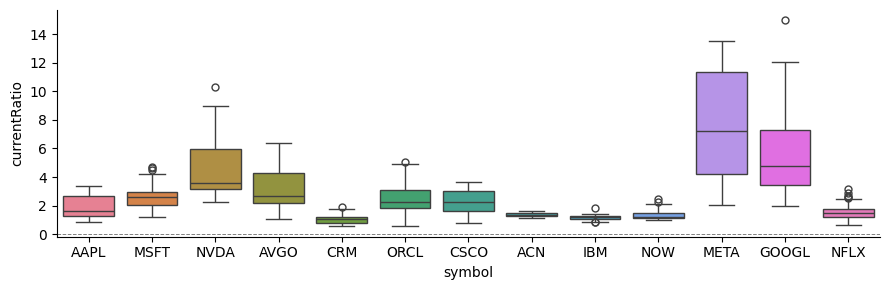

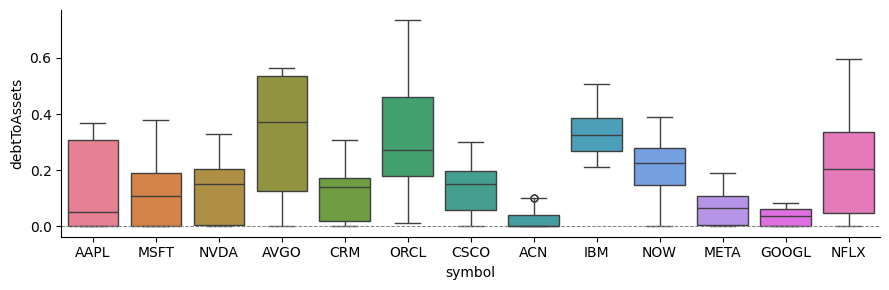

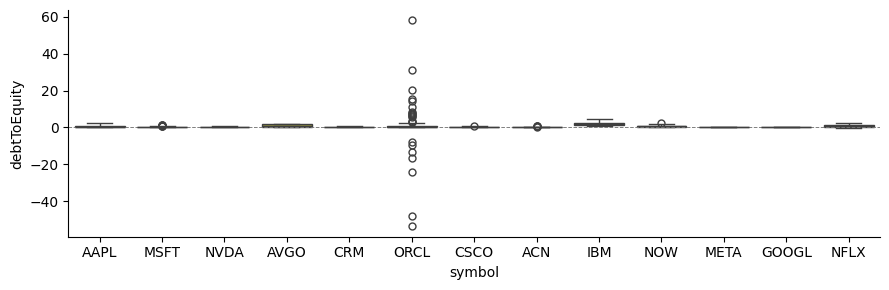

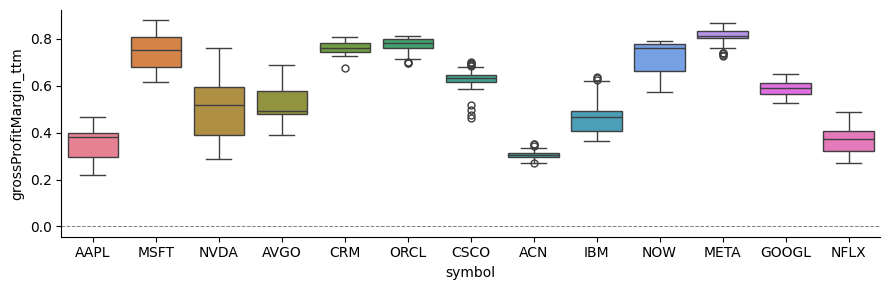

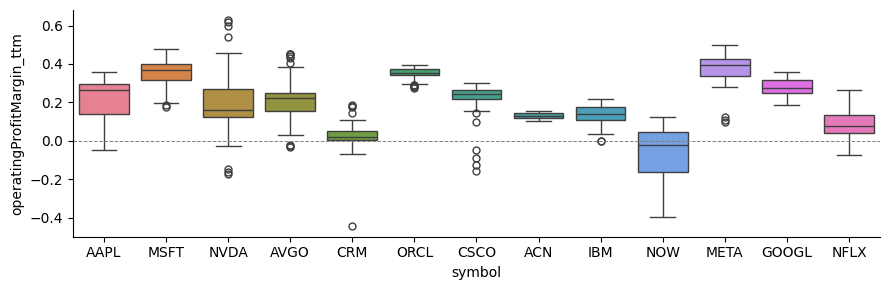

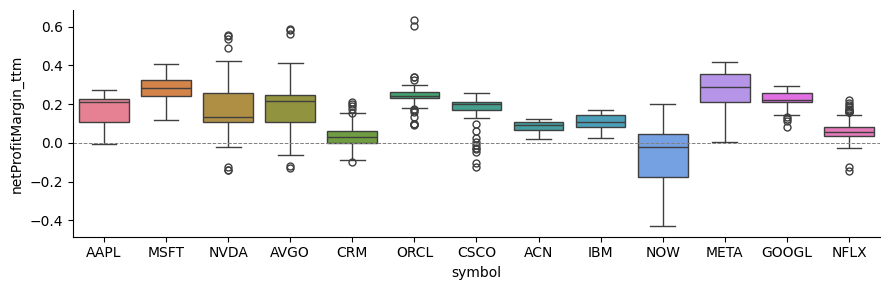

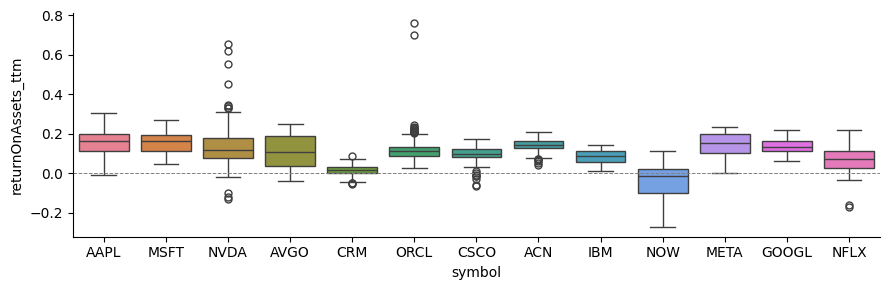

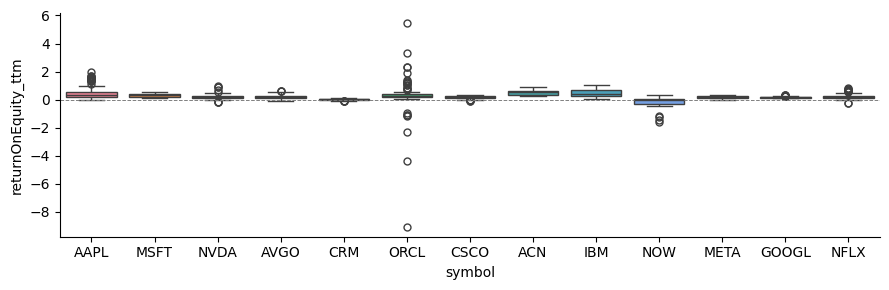

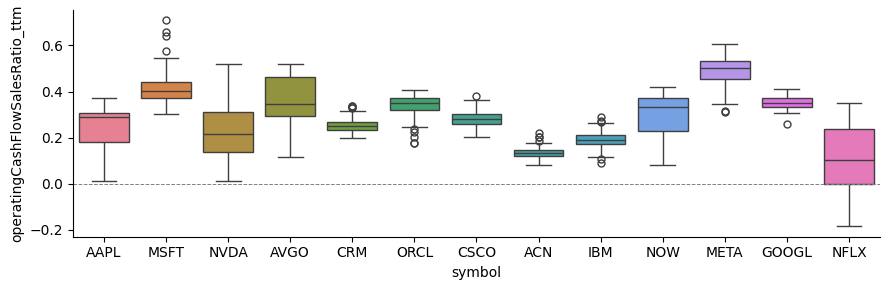

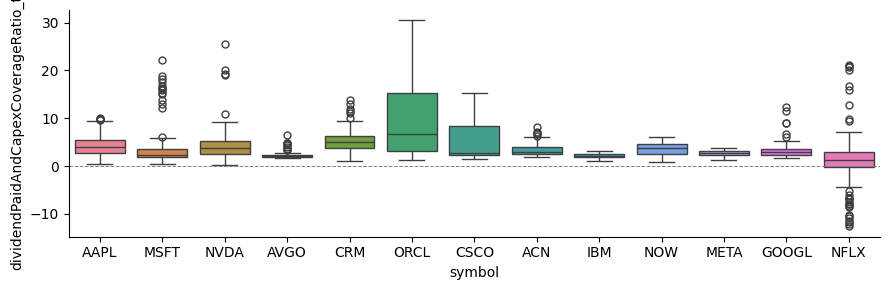

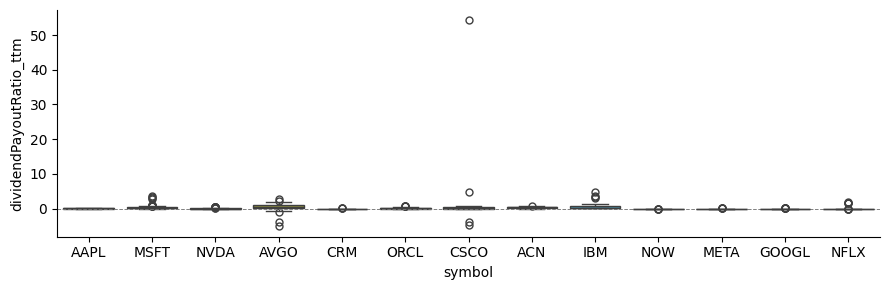

In [174]:
metrics_to_plot = ['currentRatio', 'debtToAssets', 'debtToEquity', \
                    'grossProfitMargin_ttm', 'operatingProfitMargin_ttm', 'netProfitMargin_ttm', \
                    'returnOnAssets_ttm', 'returnOnEquity_ttm', 'operatingCashFlowSalesRatio_ttm', \
                    'dividendPaidAndCapexCoverageRatio_ttm', 'dividendPayoutRatio_ttm']

for metric in metrics_to_plot:
    g = sns.catplot(
        data=financial_metrics_processed,
        y=metric,
        x='symbol',
        hue='symbol',
        kind='box',
        height=3,
        aspect=3
    )
    # Add a horizontal line at y = 0 for each subplot
    g.map(plt.axhline, y=0, color="grey", linestyle="--", linewidth=0.7)

In [175]:
financial_metrics_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype          
---  ------                                         --------------  -----          
 0   fiscalDateEnding                               1125 non-null   datetime64[ns] 
 1   symbol                                         1125 non-null   object         
 2   fillingDate                                    1125 non-null   datetime64[ns] 
 3   period                                         1125 non-null   object         
 4   daysInPeriod                                   1112 non-null   timedelta64[ns]
 5   currentRatio                                   1125 non-null   float64        
 6   debtToAssets                                   1125 non-null   float64        
 7   debtToEquity                                   1125 non-null   float64        
 8   grossProfitMargin_ttm                          1

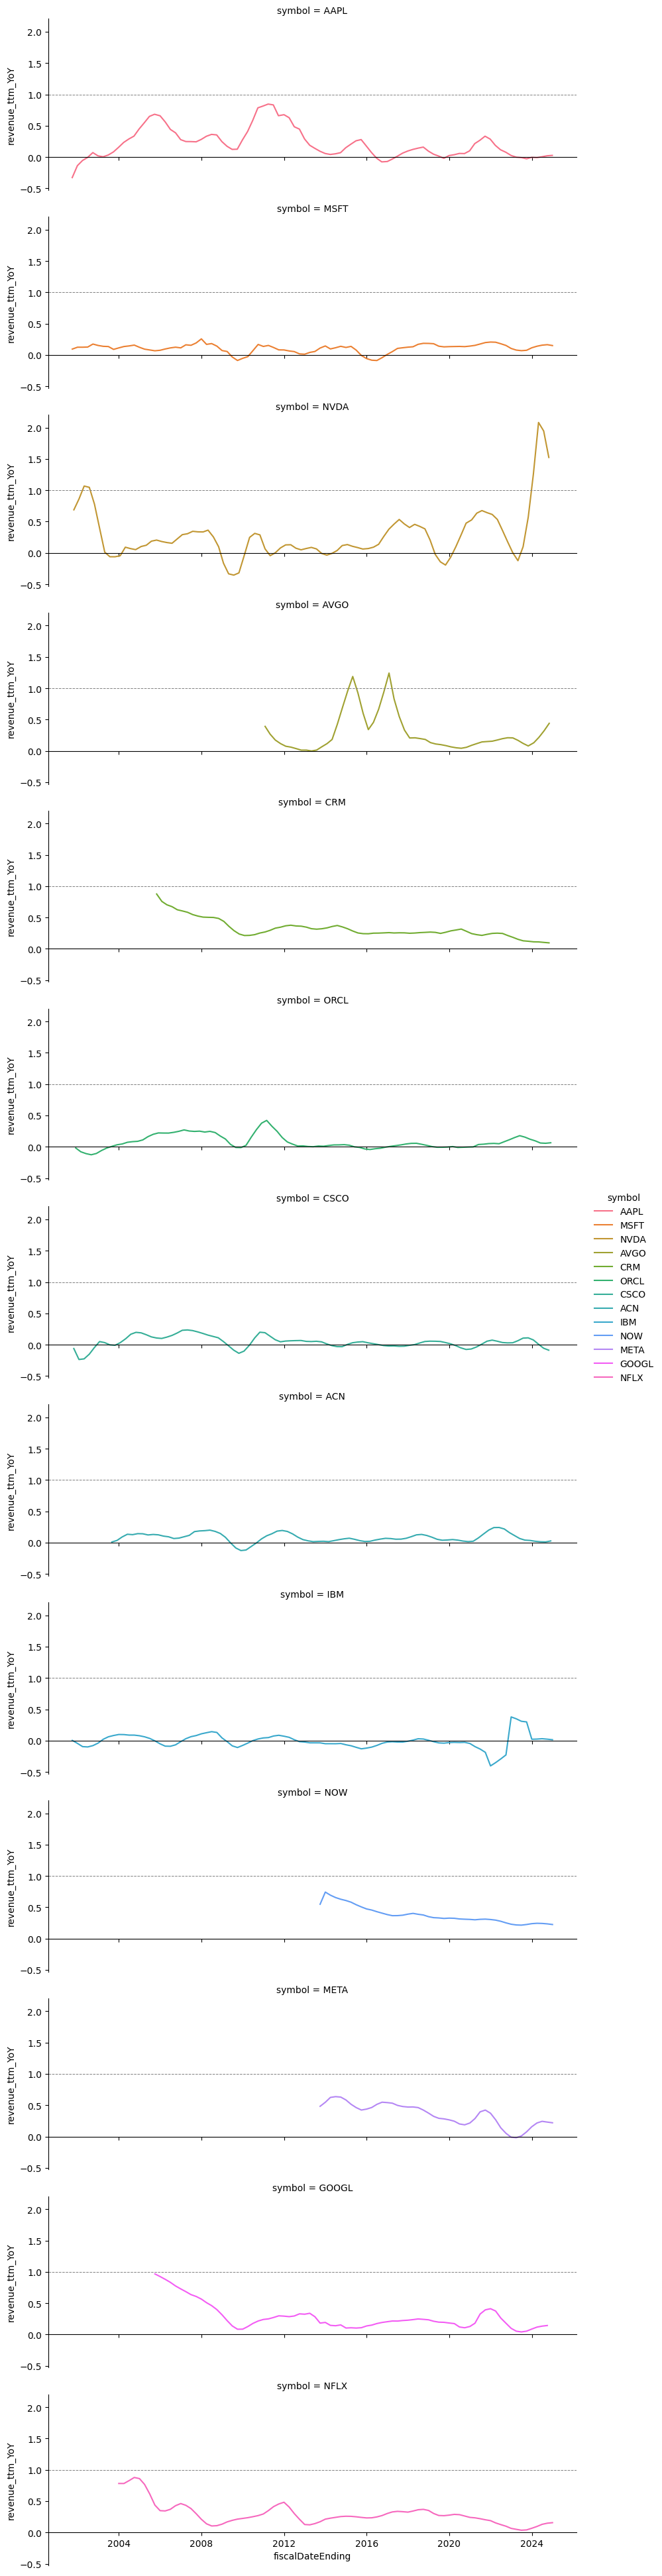

In [176]:
g = sns.relplot(
    data=financial_metrics_processed,
    y='revenue_ttm_YoY',
    x='fiscalDateEnding',
    row='symbol',
    hue='symbol',
    kind='line',
    height=3,
    aspect=3
)

# Apply formatting to each facet
for ax in g.axes.flat:
    ax.spines['bottom'].set_position(('data', 0))

# Add a horizontal line at y = 0 for each subplot
g.map(plt.axhline, y=1, color="grey", linestyle="--", linewidth=0.7)

**Notes:**

Highlevel analysis indicates a lot of opportunities for data clean up

1. remove outliers / reassess the number of features
2. check revenue growth rates
3. plot market caps


In [177]:
# drop redundant column
financial_metrics_processed.drop(columns=['daysInPeriod'], inplace=True)

In [178]:
display(financial_metrics_processed.isna().sum())

fiscalDateEnding                                  0
symbol                                            0
fillingDate                                       0
period                                            0
currentRatio                                      0
debtToAssets                                      0
debtToEquity                                      0
grossProfitMargin_ttm                            39
operatingProfitMargin_ttm                        39
netProfitMargin_ttm                              39
returnOnAssets_ttm                               39
returnOnEquity_ttm                               39
revenue_ttm                                      39
netIncome_ttm                                    39
operatingCashFlowSalesRatio_ttm                  41
dividendPaidAndCapexCoverageRatio_ttm            41
dividendPayoutRatio_ttm                          41
currentRatio_YoY_bps                             52
debtToAssets_YoY_bps                             52
debtToEquity_YoY_bps                             52
grossProfitMargin_ttm_YoY_bps                    91
operatingProfitMargin_ttm_YoY_bps                91
netProfitMargin_ttm_YoY_bps                      91
returnOnAssets_ttm_YoY_bps                       91
returnOnEquity_ttm_YoY_bps                       91
operatingCashFlowSalesRatio_ttm_YoY_bps          93
dividendPaidAndCapexCoverageRatio_ttm_YoY_bps    93
dividendPayoutRatio_ttm_YoY_bps                  93
totalAssets_YoY                                  52
revenue_qtly_YoY                                 52
operatingCashFlow_qtly_YoY                       54
revenue_ttm_YoY                                  91
operatingCashFlow_ttm_YoY                        93
eps_is                                            0
netProfitMargin                                   0
netProfitMargin_YoY_bps                          52
dtype: int64

#### Earnings history

In [179]:
# fetch earnings history for all tickers
all_data = []

for ticker in tickers:
    df = get_earnings_history(ticker)

    if not df.empty:
        all_data.append(df)
        print(f"Import completed for {ticker}.")
    else:
        print(f"Warning: No data retrieved for {ticker}.")

# Combine all DataFrames
earnings_history_raw = pd.concat(all_data, ignore_index=True)


# view
display(earnings_history_raw.info())
display(earnings_history_raw.head())

Import completed for AAPL.
Import completed for MSFT.
Import completed for NVDA.
Import completed for AVGO.
Import completed for CRM.
Import completed for ORCL.
Import completed for CSCO.
Import completed for ACN.
Import completed for IBM.
Import completed for NOW.
Import completed for META.
Import completed for GOOGL.
Import completed for NFLX.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1406 non-null   object 
 1   symbol            1406 non-null   object 
 2   eps               1367 non-null   float64
 3   epsEstimated      1170 non-null   float64
 4   time              1406 non-null   object 
 5   revenue           1366 non-null   float64
 6   revenueEstimated  1113 non-null   float64
 7   updatedFromDate   1406 non-null   object 
 8   fiscalDateEnding  1406 non-null   object 
dtypes: float64(4), object(5)

None

date symbol  eps  epsEstimated time         revenue  \
0  2025-10-29   AAPL  NaN           NaN  amc             NaN   
1  2025-07-30   AAPL  NaN           NaN  amc             NaN   
2  2025-05-01   AAPL  NaN          1.61  amc             NaN   
3  2025-01-30   AAPL 2.40          2.36  amc 124300000000.00   
4  2024-10-31   AAPL 1.64          1.60  amc  94930000000.00   

   revenueEstimated updatedFromDate fiscalDateEnding  
0               NaN      2025-02-23       2025-09-27  
1               NaN      2025-02-23       2025-06-27  
2    94076168920.00      2025-02-23       2025-03-27  
3   124257393152.00      2025-02-23       2024-12-28  
4    94511953345.00      2025-02-23       2024-09-28

In [180]:
# Drop unnecessary columns
earnings_history_raw.drop(columns=['updatedFromDate'], errors='ignore', inplace=True)

# Convert date column to datetime
earnings_history_raw['date'] = pd.to_datetime(earnings_history_raw['date'])
earnings_history_raw['fiscalDateEnding'] = pd.to_datetime(earnings_history_raw['fiscalDateEnding'])

# Filter data by date range
earnings_history_raw = earnings_history_raw[
    (earnings_history_raw['fiscalDateEnding'] >= start_date.strftime("%Y-%m-%d")) &
    (earnings_history_raw['fiscalDateEnding'] <= end_date.strftime("%Y-%m-%d")) &
    (earnings_history_raw['date'] <= end_date.strftime("%Y-%m-%d"))
]

# Sort data chronologically
earnings_history_raw.sort_values(by=['symbol', 'fiscalDateEnding'], ascending=True, inplace=True)
earnings_history_raw['daysInPeriod'] = earnings_history_raw.groupby('symbol')['fiscalDateEnding'].diff(periods=1)

# view
display(earnings_history_raw.info())
display(earnings_history_raw.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1083 entries, 103 to 528
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   date              1083 non-null   datetime64[ns] 
 1   symbol            1083 non-null   object         
 2   eps               1083 non-null   float64        
 3   epsEstimated      1036 non-null   float64        
 4   time              1083 non-null   object         
 5   revenue           1082 non-null   float64        
 6   revenueEstimated  1031 non-null   float64        
 7   fiscalDateEnding  1083 non-null   datetime64[ns] 
 8   daysInPeriod      1070 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(4), object(2), timedelta64[ns](1)
memory usage: 84.6+ KB


None

date     eps  epsEstimated         revenue  \
count                           1083 1083.00       1036.00         1082.00   
mean   2013-12-16 18:52:51.191135744    0.89          0.88  14007280825.32   
min              2000-01-18 00:00:00   -0.31         -0.10     16600000.00   
25%              2008-03-26 12:00:00    0.13          0.15   2499000000.00   
50%              2014-08-21 00:00:00    0.51          0.52   8201150500.00   
75%              2019-11-13 12:00:00    1.21          1.15  16879000000.00   
max              2025-01-30 00:00:00    8.02         10.37 124300000000.00   
std                              NaN    1.08          1.07  18661737627.00   

       revenueEstimated               fiscalDateEnding  \
count           1031.00                           1083   
mean     14136832992.26  2013-11-24 05:27:05.484764672   
min         52369475.00            1999-12-31 00:00:00   
25%       2885513887.50            2008-02-29 00:00:00   
50%       8410775320.00            2014-07-31 00:00:00   
75%      17313105072.00            2019-10-26 12:00:00   
max     124257393152.00            2024-12-31 00:00:00   
std      18501736827.41                            NaN   

                     daysInPeriod  
count                        1070  
mean   95 days 09:57:31.962616822  
min              62 days 00:00:00  
25%              91 days 00:00:00  
50%              91 days 00:00:00  
75%              92 days 00:00:00  
max            1463 days 00:00:00  
std    62 days 17:12:59.437138443

In [181]:
earnings_history_raw.daysInPeriod.value_counts()

daysInPeriod
91 days      479
92 days      422
90 days      129
89 days       18
98 days       11
185 days       1
95 days        1
183 days       1
546 days       1
1008 days      1
1463 days      1
1183 days      1
364 days       1
182 days       1
62 days        1
120 days       1
Name: count, dtype: int64

In [182]:
# view records with unexpected period length
display(
    earnings_history_raw[(earnings_history_raw['daysInPeriod'].dt.days > 100) ^
    (earnings_history_raw['daysInPeriod'].dt.days < 80)]
    .sort_values(by=['symbol', 'date'])
)


date symbol   eps  epsEstimated time        revenue  \
934  2002-01-09    ACN  0.25          0.24  bmo  3408510000.00   
1151 2012-08-01    NOW -0.06           NaN  amc    47431000.00   
373  2002-08-15   NVDA  0.00          0.00  bmo   427285000.00   
367  2006-11-09   NVDA  0.07          0.06  bmo   687519000.00   
366  2010-08-12   NVDA -0.01         -0.00  amc   811208000.00   
365  2013-11-07   NVDA  0.01          0.01  amc  1053967000.00   
364  2014-11-06   NVDA  0.01          0.01  amc  1225382000.00   
361  2015-11-05   NVDA  0.01          0.01  amc  1305000000.00   
571  2014-03-18   ORCL  0.68          0.70  amc  9307000000.00   
570  2014-06-19   ORCL  0.92          0.95  amc 11320000000.00   

      revenueEstimated fiscalDateEnding daysInPeriod  
934      3266488749.00       2001-11-30     185 days  
1151               NaN       2012-03-31     183 days  
373       427300000.00       2002-07-28     546 days  
367       820600000.00       2006-07-30    1008 days  
366      2974400000.00       2010-08-01    1463 days  
365      1054000000.00       2013-10-27    1183 days  
364      1106812903.00       2014-10-26     364 days  
361      1162755000.00       2015-10-25     182 days  
571      9581764705.00       2014-01-31      62 days  
570     11689130434.00       2014-05-31     120 days

In [183]:
# adjust the fiscal date ending from 2014-01-31 to 2014-02-28 for ORCL
earnings_history_raw.loc[
(earnings_history_raw['fiscalDateEnding'] == '2014-01-31') &
(earnings_history_raw['symbol'] == 'ORCL'), 'fiscalDateEnding'] = '2014-02-28'

In [184]:
# Sort data chronologically
earnings_history_raw.sort_values(by=['symbol', 'fiscalDateEnding'], ascending=True, inplace=True)
earnings_history_raw['daysInPeriod'] = earnings_history_raw.groupby('symbol')['fiscalDateEnding'].diff(periods=1)

In [185]:
# view records with unexpected period length
display(
    earnings_history_raw[(earnings_history_raw['daysInPeriod'].dt.days > 100) ^
    (earnings_history_raw['daysInPeriod'].dt.days < 80)]
    .sort_values(by=['symbol', 'date'])
)


date symbol   eps  epsEstimated time       revenue  \
934  2002-01-09    ACN  0.25          0.24  bmo 3408510000.00   
1151 2012-08-01    NOW -0.06           NaN  amc   47431000.00   
373  2002-08-15   NVDA  0.00          0.00  bmo  427285000.00   
367  2006-11-09   NVDA  0.07          0.06  bmo  687519000.00   
366  2010-08-12   NVDA -0.01         -0.00  amc  811208000.00   
365  2013-11-07   NVDA  0.01          0.01  amc 1053967000.00   
364  2014-11-06   NVDA  0.01          0.01  amc 1225382000.00   
361  2015-11-05   NVDA  0.01          0.01  amc 1305000000.00   

      revenueEstimated fiscalDateEnding daysInPeriod  
934      3266488749.00       2001-11-30     185 days  
1151               NaN       2012-03-31     183 days  
373       427300000.00       2002-07-28     546 days  
367       820600000.00       2006-07-30    1008 days  
366      2974400000.00       2010-08-01    1463 days  
365      1054000000.00       2013-10-27    1183 days  
364      1106812903.00       2014-10-26     364 days  
361      1162755000.00       2015-10-25     182 days

In [186]:
# drill down
display(
    earnings_history_raw[(earnings_history_raw['symbol'] == 'ACN') &
    (earnings_history_raw['date'] < '2002-12-31')]
    .sort_values(by=['date'])
)

display(
    earnings_history_raw[(earnings_history_raw['symbol'] == 'GOOGL') &
    (earnings_history_raw['date'] < '2005-12-31')]
    .sort_values(by=['date'])
)


display(
    earnings_history_raw[(earnings_history_raw['symbol'] == 'NFLX') &
    (earnings_history_raw['date'] < '2003-12-31')]
    .sort_values(by=['date'])
)

display(
    earnings_history_raw[(earnings_history_raw['symbol'] == 'NOW') &
    (earnings_history_raw['date'] < '2013-12-31')]
    .sort_values(by=['date'])
)


display(
    earnings_history_raw[(earnings_history_raw['symbol'] == 'NVDA') &
    (earnings_history_raw['date'] < '2015-12-31')]
    .sort_values(by=['date'])
)


date symbol  eps  epsEstimated time       revenue  revenueEstimated  \
935 2001-10-11    ACN 0.12          0.11  bmo           NaN               NaN   
934 2002-01-09    ACN 0.25          0.24  bmo 3408510000.00     3266488749.00   
933 2002-04-11    ACN 0.23          0.22  bmo 3410102000.00     3255097363.00   
932 2002-07-12    ACN 0.27          0.26  bmo 3350660000.00     3221788461.00   
931 2002-10-10    ACN 0.16          0.16  bmo 3084605000.00     3084605000.00   

    fiscalDateEnding daysInPeriod  
935       2001-05-29          NaT  
934       2001-11-30     185 days  
933       2002-02-28      90 days  
932       2002-05-31      92 days  
931       2002-08-31      92 days

date symbol  eps  epsEstimated time       revenue  \
1310 2002-03-30  GOOGL 0.00           NaN  amc   42000000.00   
1309 2002-06-29  GOOGL 0.00           NaN  amc   79000000.00   
1308 2002-09-29  GOOGL 0.00           NaN  amc  131000000.00   
1307 2002-12-30  GOOGL 0.00           NaN  amc  188000000.00   
1306 2003-03-30  GOOGL 0.00           NaN  amc  249000000.00   
1305 2003-06-29  GOOGL 0.00           NaN  amc  311199000.00   
1304 2003-09-29  GOOGL 0.00           NaN  amc  394000000.00   
1303 2003-12-30  GOOGL 0.00           NaN  amc  512000000.00   
1302 2004-03-30  GOOGL 0.00           NaN  amc  651623000.00   
1301 2004-09-29  GOOGL 0.00           NaN  amc  805887000.00   
1300 2004-10-21  GOOGL 0.02          0.02  bmo  700212000.00   
1299 2005-02-01  GOOGL 0.02          0.02  bmo 1031501000.00   
1298 2005-04-21  GOOGL 0.03          0.02  bmo 1256516000.00   
1297 2005-07-21  GOOGL 0.03          0.03  bmo 1384495000.00   
1296 2005-10-20  GOOGL 0.04          0.04  bmo 1578456000.00   

      revenueEstimated fiscalDateEnding daysInPeriod  
1310               NaN       2002-03-31          NaT  
1309               NaN       2002-06-30      91 days  
1308               NaN       2002-09-30      92 days  
1307               NaN       2002-12-31      92 days  
1306               NaN       2003-03-31      90 days  
1305               NaN       2003-06-30      91 days  
1304               NaN       2003-09-30      92 days  
1303               NaN       2003-12-31      92 days  
1302               NaN       2004-03-31      91 days  
1301               NaN       2004-09-30      92 days  
1300      604500000.00       2004-06-30      91 days  
1299      846769230.00       2004-12-31      92 days  
1298     1217377173.00       2005-03-31      90 days  
1297     1225180327.00       2005-06-30      91 days  
1296     1392352941.00       2005-09-30      92 days

date symbol   eps  epsEstimated time     revenue  revenueEstimated  \
1405 2002-03-30   NFLX -0.08           NaN  amc 30527000.00               NaN   
1404 2002-10-18   NFLX -0.09         -0.05  bmo 36360000.00       52369475.00   
1403 2002-11-14   NFLX -0.01           NaN  amc 40731000.00               NaN   
1402 2003-01-15   NFLX -0.01         -0.00  bmo 45188000.00       57512567.00   
1401 2003-04-17   NFLX -0.01         -0.01  bmo 55669000.00       52485289.00   
1400 2003-07-17   NFLX  0.01          0.01  bmo 63187000.00       63187000.00   
1399 2003-10-15   NFLX  0.01          0.00  bmo 72202000.00       72202000.00   

     fiscalDateEnding daysInPeriod  
1405       2002-03-31          NaT  
1404       2002-06-30      91 days  
1403       2002-09-30      92 days  
1402       2002-12-31      92 days  
1401       2003-03-31      90 days  
1400       2003-06-30      91 days  
1399       2003-09-30      92 days

date symbol   eps  epsEstimated time      revenue  \
1156 2010-09-29    NOW  0.02           NaN  amc  16600000.00   
1155 2010-12-30    NOW  0.02           NaN  amc  21400000.00   
1154 2011-03-30    NOW  0.02           NaN  amc  25200000.00   
1153 2011-06-29    NOW  0.02           NaN  amc  29500000.00   
1152 2011-12-30    NOW -0.06           NaN  amc  73375000.00   
1151 2012-08-01    NOW -0.06           NaN  amc  47431000.00   
1150 2012-08-10    NOW -0.31           NaN  amc  56774000.00   
1149 2012-10-24    NOW -0.06         -0.10  amc  64345000.00   
1148 2013-01-30    NOW -0.08         -0.05  amc  75162000.00   
1147 2013-04-24    NOW -0.01         -0.01  amc  85939000.00   
1146 2013-07-31    NOW -0.06         -0.05  amc 102222000.00   
1145 2013-10-23    NOW  0.01          0.00  amc 111259000.00   

      revenueEstimated fiscalDateEnding daysInPeriod  
1156               NaN       2010-09-30          NaT  
1155               NaN       2010-12-31      92 days  
1154               NaN       2011-03-31      90 days  
1153               NaN       2011-06-30      91 days  
1152               NaN       2011-09-30      92 days  
1151               NaN       2012-03-31     183 days  
1150               NaN       2012-06-30      91 days  
1149      107166666.00       2012-09-30      92 days  
1148       74410380.00       2012-12-31      92 days  
1147      257699999.00       2013-03-31      90 days  
1146       85166666.00       2013-06-30      91 days  
1145      222600000.00       2013-09-30      92 days

date symbol   eps  epsEstimated time       revenue  \
378 2000-02-15   NVDA  0.00          0.00  bmo  128400000.00   
377 2000-05-16   NVDA  0.00          0.00  bmo  148483000.00   
376 2000-08-21   NVDA  0.00          0.00  bmo  170398000.00   
375 2000-11-09   NVDA  0.00          0.05  bmo  198165000.00   
374 2001-02-15   NVDA  0.00          0.01  bmo  218218000.00   
373 2002-08-15   NVDA  0.00          0.00  bmo  427285000.00   
372 2002-11-07   NVDA -0.00         -0.00  bmo  430304000.00   
371 2003-02-13   NVDA  0.00          0.00  bmo  468953000.00   
370 2003-05-08   NVDA  0.00          0.00  bmo  404983000.00   
369 2003-08-07   NVDA  0.00          0.00  bmo  459774000.00   
368 2003-11-06   NVDA  0.00          0.00  bmo  486069000.00   
367 2006-11-09   NVDA  0.07          0.06  bmo  687519000.00   
366 2010-08-12   NVDA -0.01         -0.00  amc  811208000.00   
365 2013-11-07   NVDA  0.01          0.01  amc 1053967000.00   
364 2014-11-06   NVDA  0.01          0.01  amc 1225382000.00   
363 2015-02-11   NVDA  0.01          0.01  amc 1250514000.00   
362 2015-05-07   NVDA  0.01          0.01  amc 1151000000.00   
361 2015-11-05   NVDA  0.01          0.01  amc 1305000000.00   

     revenueEstimated fiscalDateEnding daysInPeriod  
378      128500000.00       2000-01-30          NaT  
377      111375000.00       2000-04-30      91 days  
376      136320000.00       2000-07-30      91 days  
375      165166666.00       2000-10-29      91 days  
374      360030000.00       2001-01-28      91 days  
373      427300000.00       2002-07-28     546 days  
372      645450000.00       2002-10-27      91 days  
371      386925000.00       2003-01-26      91 days  
370      405000000.00       2003-04-27      91 days  
369      613066666.00       2003-07-27      91 days  
368      388879999.00       2003-10-26      91 days  
367      820600000.00       2006-07-30    1008 days  
366     2974400000.00       2010-08-01    1463 days  
365     1054000000.00       2013-10-27    1183 days  
364     1106812903.00       2014-10-26     364 days  
363     1000400000.00       2015-01-25      91 days  
362     1246916666.00       2015-04-26      91 days  
361     1162755000.00       2015-10-25     182 days

**Decision:**

- NOW: Periods prior to 2012-10-24 have been removed due to the absence of estimates.
- NVDA: Periods before 2015-12-31 have been excluded due to the low frequency of observations.
- ACN: drop 2001-12-31
- GOOGL: Periods prior to 2004-12-31 have been removed due to the absence of estimates.
- NFLX: Periods prior to 2002-06-30 have been removed due to the absence of estimates.
  

In [187]:
# drop NOW records prior to '2012-10-24'
earnings_history_raw = earnings_history_raw.drop(
    earnings_history_raw[(earnings_history_raw['date'] < '2012-10-24') & (earnings_history_raw['symbol'] == 'NOW')].index
)

# drop NVDA records prior to '2015-12-31'
earnings_history_raw = earnings_history_raw.drop(
    earnings_history_raw[(earnings_history_raw['date'] < '2015-12-31') & (earnings_history_raw['symbol'] == 'NVDA')].index
)

# drop ACN records prior to '2015-12-31'
earnings_history_raw = earnings_history_raw.drop(
    earnings_history_raw[(earnings_history_raw['date'] < '2001-12-31') & (earnings_history_raw['symbol'] == 'ACN')].index
)

# drop GOOGL records prior to '2004-12-31'
earnings_history_raw = earnings_history_raw.drop(
    earnings_history_raw[(earnings_history_raw['date'] < '2004-12-31') & (earnings_history_raw['symbol'] == 'GOOGL')].index
)

# drop NFLX records prior to '2002-06-30'
earnings_history_raw = earnings_history_raw.drop(
    earnings_history_raw[(earnings_history_raw['date'] < '2002-06-30') & (earnings_history_raw['symbol'] == 'NFLX')].index
)

**Note**:

1. AMC: After Market Close (closing price as at the announcement day in in the pre-window)
2. BMO: Before Market Open

In [188]:
earnings_history_raw

date symbol   eps  epsEstimated time        revenue  \
103 2000-01-19   AAPL  0.01          0.01  amc  2343000000.00   
102 2000-04-19   AAPL  0.01          0.01  amc  1945000000.00   
101 2000-07-18   AAPL  0.01          0.01  amc  1825000000.00   
100 2000-10-18   AAPL  0.01           NaN  amc  1870000000.00   
99  2001-04-18   AAPL -0.01           NaN  amc  1007000000.00   
..         ...    ...   ...           ...  ...            ...   
532 2023-12-11   ORCL  1.34          1.32  amc 12941000000.00   
531 2024-03-11   ORCL  1.41          1.38  amc 13280000000.00   
530 2024-06-11   ORCL  1.63          1.65  amc 14287000000.00   
529 2024-09-09   ORCL  1.39          1.33  amc 13307000000.00   
528 2024-12-09   ORCL  1.47          1.48  amc 14059000000.00   

     revenueEstimated fiscalDateEnding daysInPeriod  
103               NaN       2000-01-01          NaT  
102     1945000000.00       2000-04-01      91 days  
101     1825000000.00       2000-07-01      91 days  
100               NaN       2000-09-30      91 days  
99                NaN       2000-12-30      91 days  
..                ...              ...          ...  
532    13048000000.00       2023-11-30      91 days  
531    13286481142.00       2024-02-29      91 days  
530    14562253539.00       2024-05-31      92 days  
529    13233301542.00       2024-08-31      92 days  
528    14117796631.00       2024-11-30      91 days  

[1045 rows x 9 columns]

In [189]:
# Sort data chronologically
earnings_history_raw.sort_values(by=['symbol', 'fiscalDateEnding'], ascending=True, inplace=True)
earnings_history_raw['daysInPeriod'] = earnings_history_raw.groupby('symbol')['fiscalDateEnding'].diff(periods=1)

In [190]:
# view records with unexpected period length
display(
    earnings_history_raw[(earnings_history_raw['daysInPeriod'].dt.days > 100) ^
    (earnings_history_raw['daysInPeriod'].dt.days < 80)]
    .sort_values(by=['symbol', 'date'])
)


Empty DataFrame
Columns: [date, symbol, eps, epsEstimated, time, revenue, revenueEstimated, fiscalDateEnding, daysInPeriod]
Index: []

In [191]:
# Convert earnings announcement date to AMC-equivalent convention for ease of data-manipulation
earnings_history_raw['amcEquivalentEarnReportedDate'] = np.where(
    earnings_history_raw['time'] == 'amc',
    earnings_history_raw['date'],  # If 'amc', keep the same date
    earnings_history_raw['date'] - pd.Timedelta(days=1)  # If 'bmo' or other, subtract 1 day
)

In [192]:
# if revenue estimate = to revenue actual most likely no estimate was provided = not meaningfull
earnings_history_raw.loc[earnings_history_raw['revenueEstimated'] == earnings_history_raw['revenue'], 'revenueEstimated'] = np.nan

In [193]:
earnings_history_raw

date symbol   eps  epsEstimated time        revenue  \
103 2000-01-19   AAPL  0.01          0.01  amc  2343000000.00   
102 2000-04-19   AAPL  0.01          0.01  amc  1945000000.00   
101 2000-07-18   AAPL  0.01          0.01  amc  1825000000.00   
100 2000-10-18   AAPL  0.01           NaN  amc  1870000000.00   
99  2001-04-18   AAPL -0.01           NaN  amc  1007000000.00   
..         ...    ...   ...           ...  ...            ...   
532 2023-12-11   ORCL  1.34          1.32  amc 12941000000.00   
531 2024-03-11   ORCL  1.41          1.38  amc 13280000000.00   
530 2024-06-11   ORCL  1.63          1.65  amc 14287000000.00   
529 2024-09-09   ORCL  1.39          1.33  amc 13307000000.00   
528 2024-12-09   ORCL  1.47          1.48  amc 14059000000.00   

     revenueEstimated fiscalDateEnding daysInPeriod  \
103               NaN       2000-01-01          NaT   
102               NaN       2000-04-01      91 days   
101               NaN       2000-07-01      91 days   
100               NaN       2000-09-30      91 days   
99                NaN       2000-12-30      91 days   
..                ...              ...          ...   
532    13048000000.00       2023-11-30      91 days   
531    13286481142.00       2024-02-29      91 days   
530    14562253539.00       2024-05-31      92 days   
529    13233301542.00       2024-08-31      92 days   
528    14117796631.00       2024-11-30      91 days   

    amcEquivalentEarnReportedDate  
103                    2000-01-19  
102                    2000-04-19  
101                    2000-07-18  
100                    2000-10-18  
99                     2001-04-18  
..                            ...  
532                    2023-12-11  
531                    2024-03-11  
530                    2024-06-11  
529                    2024-09-09  
528                    2024-12-09  

[1045 rows x 10 columns]

In [194]:
earnings_history_raw.loc[earnings_history_raw['epsEstimated'] <= 0]

date symbol   eps  epsEstimated time      revenue  \
1404 2002-10-18   NFLX -0.09         -0.05  bmo  36360000.00   
1402 2003-01-15   NFLX -0.01         -0.00  bmo  45188000.00   
1401 2003-04-17   NFLX -0.01         -0.01  bmo  55669000.00   
1393 2005-04-21   NFLX -0.02         -0.02  bmo 154140000.00   
1365 2012-04-23   NFLX -0.01         -0.01  amc 869791000.00   
1149 2012-10-24    NOW -0.06         -0.10  amc  64345000.00   
1148 2013-01-30    NOW -0.08         -0.05  amc  75162000.00   
1147 2013-04-24    NOW -0.01         -0.01  amc  85939000.00   
1146 2013-07-31    NOW -0.06         -0.05  amc 102222000.00   
1144 2014-01-29    NOW -0.02         -0.01  amc 125230000.00   
1143 2014-04-23    NOW -0.08         -0.08  amc 139090000.00   
1142 2014-07-30    NOW -0.07         -0.07  amc 166757000.00   

      revenueEstimated fiscalDateEnding daysInPeriod  \
1404       52369475.00       2002-06-30          NaT   
1402       57512567.00       2002-12-31      92 days   
1401       52485289.00       2003-03-31      90 days   
1393      462419999.00       2005-03-31      90 days   
1365     3479164000.00       2012-03-31      91 days   
1149      107166666.00       2012-09-30          NaT   
1148       74410380.00       2012-12-31      92 days   
1147      257699999.00       2013-03-31      90 days   
1146       85166666.00       2013-06-30      91 days   
1144       62600000.00       2013-12-31      92 days   
1143      139100000.00       2014-03-31      90 days   
1142      166800000.00       2014-06-30      91 days   

     amcEquivalentEarnReportedDate  
1404                    2002-10-17  
1402                    2003-01-14  
1401                    2003-04-16  
1393                    2005-04-20  
1365                    2012-04-23  
1149                    2012-10-24  
1148                    2013-01-30  
1147                    2013-04-24  
1146                    2013-07-31  
1144                    2014-01-29  
1143                    2014-04-23  
1142                    2014-07-30

In [195]:
earnings_history_raw = earnings_history_raw.drop(columns=['daysInPeriod'])

In [196]:
# Apply preprocessing function to each ticker group
earnings_history_processed = (
    earnings_history_raw.groupby('symbol', group_keys=False)
    .apply(preprocess_earnings_data)
    .reset_index(drop=True)
)

print("Preprocessing completed for all tickers.")

# view
display(earnings_history_processed.head())
display(earnings_history_processed.info())

Preprocessing completed for all tickers.


earnReportedDate symbol  epsAct  epsEst earnReportedTime    revenueAct  \
0       2000-01-19   AAPL    0.01    0.01              amc 2343000000.00   
1       2000-04-19   AAPL    0.01    0.01              amc 1945000000.00   
2       2000-07-18   AAPL    0.01    0.01              amc 1825000000.00   
3       2000-10-18   AAPL    0.01     NaN              amc 1870000000.00   
4       2001-04-18   AAPL   -0.01     NaN              amc 1007000000.00   

   revenueEst fiscalDateEnding_ea amcEquivalentEarnReportedDate  \
0         NaN          2000-01-01                    2000-01-19   
1         NaN          2000-04-01                    2000-04-19   
2         NaN          2000-07-01                    2000-07-18   
3         NaN          2000-09-30                    2000-10-18   
4         NaN          2000-12-30                    2001-04-18   

   epsSurpriseAbs  ...  revSurprise_pct  daysInPeriod  standEpsSurpriseScore  \
0            0.00  ...              NaN           NaT                    NaN   
1            0.00  ...              NaN       91 days                    NaN   
2            0.00  ...              NaN       91 days                    NaN   
3             NaN  ...              NaN       91 days                    NaN   
4             NaN  ...              NaN       91 days                    NaN   

  epsSurpriseChange_QoQ  epsEst_YoY  epsAct_YoY  standRevSurpriseScore  \
0                   NaN         NaN         NaN                    NaN   
1                 -0.02         NaN         NaN                    NaN   
2                 -0.07         NaN         NaN                    NaN   
3                   NaN         NaN         NaN                    NaN   
4                   NaN         NaN       -2.20                    NaN   

   revSurpriseChange_QoQ  revenueEst_YoY  revenueAct_YoY  
0                    NaN             NaN             NaN  
1                    NaN             NaN             NaN  
2                    NaN             NaN             NaN  
3                    NaN             NaN             NaN  
4                    NaN             NaN           -0.57  

[5 rows x 22 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   earnReportedDate               1045 non-null   datetime64[ns] 
 1   symbol                         1045 non-null   object         
 2   epsAct                         1045 non-null   float64        
 3   epsEst                         1016 non-null   float64        
 4   earnReportedTime               1045 non-null   object         
 5   revenueAct                     1045 non-null   float64        
 6   revenueEst                     944 non-null    float64        
 7   fiscalDateEnding_ea            1045 non-null   datetime64[ns] 
 8   amcEquivalentEarnReportedDate  1045 non-null   datetime64[ns] 
 9   epsSurpriseAbs                 1016 non-null   float64        
 10  epsSurprise_pct                1016 non-null   float64        
 11  revS

None

In [197]:
# drop non-informative records
earnings_history_processed = earnings_history_processed.dropna(
    subset=['epsEst', 'revenueEst'],
    how='all'
)

earnings_history_processed = earnings_history_processed.drop(columns=['daysInPeriod'])

In [198]:
display(earnings_history_processed.describe().T)
display(earnings_history_processed.isna().sum())

count                           mean  \
earnReportedDate                 1016  2014-06-29 05:42:59.527559168   
epsAct                        1016.00                           0.95   
epsEst                        1016.00                           0.90   
revenueAct                    1016.00                 14880118364.17   
revenueEst                     944.00                 15013188643.14   
fiscalDateEnding_ea              1016  2014-06-06 17:25:59.055118336   
amcEquivalentEarnReportedDate    1016  2014-06-28 23:25:59.055118080   
epsSurpriseAbs                1016.00                           0.05   
epsSurprise_pct               1016.00                           0.11   
revSurpriseAbs                 944.00                   569052361.10   
revSurprise_pct                944.00                           0.11   
standEpsSurpriseScore          962.00               1297374365331.75   
epsSurpriseChange_QoQ          994.00                          -0.00   
epsEst_YoY                     974.00                           0.24   
epsAct_YoY                     974.00                           0.36   
standRevSurpriseScore          889.00                           1.04   
revSurpriseChange_QoQ          872.00                           0.00   
revenueEst_YoY                 907.00                           0.12   
revenueAct_YoY                 974.00                           0.20   

                                               min                  25%  \
earnReportedDate               2000-01-18 00:00:00  2009-01-22 00:00:00   
epsAct                                       -0.09                 0.19   
epsEst                                       -0.10                 0.18   
revenueAct                             36360000.00        3416347250.00   
revenueEst                             52369475.00        3457059000.00   
fiscalDateEnding_ea            1999-12-31 00:00:00  2008-12-31 00:00:00   
amcEquivalentEarnReportedDate  2000-01-18 00:00:00  2009-01-21 18:00:00   
epsSurpriseAbs                               -9.27                 0.01   
epsSurprise_pct                              -1.20                 0.02   
revSurpriseAbs                     -36325517621.00          64202603.00   
revSurprise_pct                              -0.77                 0.01   
standEpsSurpriseScore                      -855.46                 0.30   
epsSurpriseChange_QoQ                        -2.06                -0.06   
epsEst_YoY                                  -10.20                -0.01   
epsAct_YoY                                  -11.07                 0.04   
standRevSurpriseScore                       -49.91                 0.17   
revSurpriseChange_QoQ                        -5.90                -0.05   
revenueEst_YoY                               -0.75                -0.03   
revenueAct_YoY                               -0.84                 0.04   

                                               50%                  75%  \
earnReportedDate               2015-04-17 12:00:00  2020-03-13 18:00:00   
epsAct                                        0.56                 1.29   
epsEst                                        0.53                 1.18   
revenueAct                           8849412500.00       18070000000.00   
revenueEst                           8896702106.50       18200749805.75   
fiscalDateEnding_ea            2015-03-29 12:00:00  2020-02-29 00:00:00   
amcEquivalentEarnReportedDate  2015-04-17 12:00:00  2020-03-13 12:00:00   
epsSurpriseAbs                                0.02                 0.06   
epsSurprise_pct                               0.06                 0.13   
revSurpriseAbs                        270105513.50         824115786.75   
revSurprise_pct                               0.04                 0.11   
standEpsSurpriseScore                         1.13                 2.08   
epsSurpriseChange_QoQ                        -0.00                 0.05   
epsEst_YoY                              

earnReportedDate                   0
symbol                             0
epsAct                             0
epsEst                             0
earnReportedTime                   0
revenueAct                         0
revenueEst                        72
fiscalDateEnding_ea                0
amcEquivalentEarnReportedDate      0
epsSurpriseAbs                     0
epsSurprise_pct                    0
revSurpriseAbs                    72
revSurprise_pct                   72
standEpsSurpriseScore             54
epsSurpriseChange_QoQ             22
epsEst_YoY                        42
epsAct_YoY                        42
standRevSurpriseScore            127
revSurpriseChange_QoQ            144
revenueEst_YoY                   109
revenueAct_YoY                    42
dtype: int64

In [199]:
tickers = list(earnings_history_processed['symbol'].unique())
display(tickers)

['AAPL',
 'ACN',
 'AVGO',
 'CRM',
 'CSCO',
 'GOOGL',
 'IBM',
 'META',
 'MSFT',
 'NFLX',
 'NOW',
 'NVDA',
 'ORCL']

In [200]:
for ticker in tickers:
    display(ticker)
    display(earnings_history_processed[earnings_history_processed['symbol'] == ticker].describe().T)

'AAPL'

count                 mean                  min  \
earnReportedDate                 90  2013-10-24 23:44:00  2000-01-19 00:00:00   
epsAct                        90.00                 0.55                 0.00   
epsEst                        90.00                 0.52                 0.00   
revenueAct                    90.00       44054766666.67        1450000000.00   
revenueEst                    82.00       46257490158.11        1375000000.00   
fiscalDateEnding_ea              90  2013-09-26 08:48:00  2000-01-01 00:00:00   
amcEquivalentEarnReportedDate    90  2013-10-24 23:44:00  2000-01-19 00:00:00   
epsSurpriseAbs                90.00                 0.04                -0.06   
epsSurprise_pct               90.00                 0.14                -0.11   
revSurpriseAbs                82.00        1825046427.26      -34626000000.00   
revSurprise_pct               82.00                 0.06                -0.37   
standEpsSurpriseScore         84.00                 1.80                -1.01   
epsSurpriseChange_QoQ         86.00                -0.00                -0.52   
epsEst_YoY                    87.00                 0.19               -10.20   
epsAct_YoY                    87.00                 0.39               -11.07   
standRevSurpriseScore         76.00                 0.82                -5.16   
revSurpriseChange_QoQ         77.00                 0.00                -0.62   
revenueEst_YoY                82.00                 0.17                -0.26   
revenueAct_YoY                87.00                 0.23                -0.22   

                                               25%                  50%  \
earnReportedDate               2008-05-15 06:00:00  2013-12-12 12:00:00   
epsAct                                        0.04                 0.39   
epsEst                                        0.04                 0.36   
revenueAct                           7607750000.00       42980500000.00   
revenueEst                           9942265624.75       44935825244.50   
fiscalDateEnding_ea            2008-04-20 18:00:00  2013-11-12 12:00:00   
amcEquivalentEarnReportedDate  2008-05-15 06:00:00  2013-12-12 12:00:00   
epsSurpriseAbs                                0.00                 0.02   
epsSurprise_pct                               0.03                 0.07   
revSurpriseAbs                        323822496.25        1293118644.50   
revSurprise_pct                               0.01                 0.04   
standEpsSurpriseScore                         0.39                 0.94   
epsSurpriseChange_QoQ                        -0.05                -0.00   
epsEst_YoY                                   -0.02                 0.12   
epsAct_YoY                                    0.05                 0.24   
standRevSurpriseScore                         0.10                 0.38   
revSurpriseChange_QoQ                        -0.05                -0.00   
revenueEst_YoY                               -0.01                 0.06   
revenueAct_YoY                                0.04                 0.17   

                                               75%                  max  \
earnReportedDate               2019-07-07 06:00:00  2025-01-30 00:00:00   
epsAct                                        0.77                 2.40   
epsEst                                        0.71                 2.36   
revenueAct                          72123750000.00      124300000000.00   
revenueEst                          74818744283.50      124257393152.00   
fiscalDateEnding_ea            2019-06-06 06:00:00  2024-12-28 00:00:00   
amcEquivalentEarnReportedDate  2019-07-07 06:00:00  2025-01-30 00:00:00   
epsSurpriseAbs                                0.04                 0.41   
epsSurprise_pct                               0.19                 1.20   
revSurpriseAbs                       3258337804.00       21339382979.00   
revSurprise_pct                               0.13                 0.45   
standEps

'ACN'

count                           mean  \
earnReportedDate                 93  2013-06-26 07:13:32.903225856   
epsAct                        93.00                           1.26   
epsEst                        93.00                           1.21   
revenueAct                    93.00                  8408252225.81   
revenueEst                    88.00                  8339714326.45   
fiscalDateEnding_ea              93  2013-05-30 23:13:32.903225856   
amcEquivalentEarnReportedDate    93  2013-06-25 11:36:46.451612928   
epsSurpriseAbs                93.00                           0.05   
epsSurprise_pct               93.00                           0.04   
revSurpriseAbs                88.00                   315381548.55   
revSurprise_pct               88.00                           0.04   
standEpsSurpriseScore         89.00                           1.41   
epsSurpriseChange_QoQ         92.00                           0.00   
epsEst_YoY                    89.00                           0.08   
epsAct_YoY                    89.00                           0.13   
standRevSurpriseScore         84.00                           1.70   
revSurpriseChange_QoQ         82.00                           0.00   
revenueEst_YoY                85.00                           0.03   
revenueAct_YoY                89.00                           0.08   

                                               min                  25%  \
earnReportedDate               2002-01-09 00:00:00  2007-09-27 00:00:00   
epsAct                                        0.16                 0.54   
epsEst                                        0.16                 0.55   
revenueAct                           3084605000.00        5537348000.00   
revenueEst                           3008217519.00        5567475722.75   
fiscalDateEnding_ea            2001-11-30 00:00:00  2007-08-31 00:00:00   
amcEquivalentEarnReportedDate  2002-01-08 00:00:00  2007-09-26 00:00:00   
epsSurpriseAbs                               -0.03                 0.01   
epsSurprise_pct                              -0.04                 0.01   
revSurpriseAbs                       -732342000.00          97370084.00   
revSurprise_pct                              -0.04                 0.01   
standEpsSurpriseScore                        -1.08                 0.40   
epsSurpriseChange_QoQ                        -0.16                -0.04   
epsEst_YoY                                   -0.14                 0.01   
epsAct_YoY                                   -0.09                 0.06   
standRevSurpriseScore                        -1.24                 0.27   
revSurpriseChange_QoQ                        -0.15                -0.04   
revenueEst_YoY                               -0.21                -0.00   
revenueAct_YoY                               -0.16                 0.03   

                                               50%                  75%  \
earnReportedDate               2013-06-27 00:00:00  2019-03-28 00:00:00   
epsAct                                        1.03                 1.79   
epsEst                                        1.04                 1.72   
revenueAct                           7640790000.00       10835271000.00   
revenueEst                           7582692982.00       10300329325.50   
fiscalDateEnding_ea            2013-05-31 00:00:00  2019-02-28 00:00:00   
amcEquivalentEarnReportedDate  2013-06-27 00:00:00  2019-03-27 00:00:00   
epsSurpriseAbs                                0.03                 0.07   
epsSurprise_pct                               0.04                 0.06   
revSurpriseAbs                        234660296.00         484599183.25   
revSurprise_pct                               0.04                 0.07   
standEpsSurpriseScore                         1.34                 2.00   
epsSurpriseChange_QoQ                        -0.00                 0.04   
epsEst_YoY                                    0.06                 0.14   
eps

'AVGO'

count                           mean  \
earnReportedDate                 49  2018-12-03 13:13:28.163265280   
epsAct                        49.00                           0.54   
epsEst                        49.00                           0.72   
revenueAct                    49.00                  5316040816.33   
revenueEst                    48.00                  5207406285.25   
fiscalDateEnding_ea              49  2018-10-31 20:04:53.877551104   
amcEquivalentEarnReportedDate    49  2018-12-03 13:13:28.163265280   
epsSurpriseAbs                49.00                          -0.18   
epsSurprise_pct               49.00                           0.03   
revSurpriseAbs                48.00                    99760381.42   
revSurprise_pct               48.00                           0.04   
standEpsSurpriseScore         45.00              27734980876618.84   
epsSurpriseChange_QoQ         48.00                          -0.00   
epsEst_YoY                    45.00                           0.47   
epsAct_YoY                    45.00                           0.32   
standRevSurpriseScore         44.00                           1.77   
revSurpriseChange_QoQ         46.00                          -0.00   
revenueEst_YoY                44.00                           0.31   
revenueAct_YoY                45.00                           0.36   

                                               min                  25%  \
earnReportedDate               2012-11-29 00:00:00  2015-12-02 00:00:00   
epsAct                                        0.06                 0.24   
epsEst                                        0.05                 0.23   
revenueAct                            562000000.00        1771000000.00   
revenueEst                            540384615.00        1678206307.50   
fiscalDateEnding_ea            2012-10-31 00:00:00  2015-10-31 00:00:00   
amcEquivalentEarnReportedDate  2012-11-29 00:00:00  2015-12-02 00:00:00   
epsSurpriseAbs                               -9.27                 0.01   
epsSurprise_pct                              -0.89                 0.01   
revSurpriseAbs                       -399250000.00          39890547.50   
revSurprise_pct                              -0.04                 0.01   
standEpsSurpriseScore                      -855.46                 0.80   
epsSurpriseChange_QoQ                        -0.90                -0.02   
epsEst_YoY                                   -0.08                 0.10   
epsAct_YoY                                   -0.08                 0.12   
standRevSurpriseScore                        -2.83                 0.41   
revSurpriseChange_QoQ                        -0.13                -0.02   
revenueEst_YoY                                0.02                 0.09   
revenueAct_YoY                                0.01                 0.12   

                                               50%                  75%  \
earnReportedDate               2018-12-06 00:00:00  2021-12-09 00:00:00   
epsAct                                        0.51                 0.78   
epsEst                                        0.51                 0.78   
revenueAct                           5444000000.00        7407000000.00   
revenueEst                           5222949428.50        7586226207.50   
fiscalDateEnding_ea            2018-11-04 00:00:00  2021-10-31 00:00:00   
amcEquivalentEarnReportedDate  2018-12-06 00:00:00  2021-12-09 00:00:00   
epsSurpriseAbs                                0.01                 0.02   
epsSurprise_pct                               0.03                 0.05   
revSurpriseAbs                         83856579.50         173956849.50   
revSurprise_pct                               0.03                 0.06   
standEpsSurpriseScore                         1.33                 1.73   
epsSurpriseChange_QoQ                        -0.00                 0.02   
epsEst_YoY                                    0.24                 0.36   
eps

'CRM'

count                           mean  \
earnReportedDate                 78  2015-03-29 17:32:18.461538560   
epsAct                        78.00                           0.54   
epsEst                        78.00                           0.45   
revenueAct                    78.00                  2885134384.62   
revenueEst                    77.00                  2642353247.87   
fiscalDateEnding_ea              78  2015-03-06 05:13:50.769230848   
amcEquivalentEarnReportedDate    78  2015-03-29 13:13:50.769230848   
epsSurpriseAbs                78.00                           0.09   
epsSurprise_pct               78.00                           0.19   
revSurpriseAbs                77.00                   278141167.71   
revSurprise_pct               77.00                           0.45   
standEpsSurpriseScore         74.00                           1.80   
epsSurpriseChange_QoQ         76.00                          -0.03   
epsEst_YoY                    78.00                           0.46   
epsAct_YoY                    78.00                           0.73   
standRevSurpriseScore         73.00                           1.22   
revSurpriseChange_QoQ         75.00                           0.00   
revenueEst_YoY                77.00                           0.10   
revenueAct_YoY                78.00                           0.39   

                                               min                  25%  \
earnReportedDate               2005-05-18 00:00:00  2010-06-11 18:00:00   
epsAct                                        0.00                 0.07   
epsEst                                        0.00                 0.06   
revenueAct                             64177000.00         555566500.00   
revenueEst                             59050000.00         376800000.00   
fiscalDateEnding_ea            2005-04-30 00:00:00  2010-05-23 00:00:00   
amcEquivalentEarnReportedDate  2005-05-17 00:00:00  2010-06-11 18:00:00   
epsSurpriseAbs                               -0.03                 0.00   
epsSurprise_pct                              -0.47                 0.03   
revSurpriseAbs                       -374500000.00             34000.00   
revSurprise_pct                              -0.05                 0.00   
standEpsSurpriseScore                        -1.04                 0.21   
epsSurpriseChange_QoQ                        -0.96                -0.13   
epsEst_YoY                                   -0.71                -0.04   
epsAct_YoY                                   -0.85                 0.10   
standRevSurpriseScore                        -0.89                 0.00   
revSurpriseChange_QoQ                        -5.90                -0.10   
revenueEst_YoY                               -0.74                 0.04   
revenueAct_YoY                               -0.69                 0.23   

                                               50%                  75%  \
earnReportedDate               2015-04-08 00:00:00  2020-02-04 00:00:00   
epsAct                                        0.15                 0.75   
epsEst                                        0.14                 0.65   
revenueAct                           1684553000.00        4766500000.00   
revenueEst                           1444600000.00        4116000000.00   
fiscalDateEnding_ea            2015-03-16 12:00:00  2020-01-08 00:00:00   
amcEquivalentEarnReportedDate  2015-04-08 00:00:00  2020-02-04 00:00:00   
epsSurpriseAbs                                0.01                 0.09   
epsSurprise_pct                               0.11                 0.25   
revSurpriseAbs                         76822231.00         218757000.00   
revSurprise_pct                               0.05                 0.20   
standEpsSurpriseScore                         1.05                 1.99   
epsSurpriseChange_QoQ                        -0.02                 0.07   
epsEst_YoY                                    0.25                 0.47   
eps

'CSCO'

count                 mean  \
earnReportedDate                 100  2012-06-26 03:21:36   
epsAct                        100.00                 0.49   
epsEst                        100.00                 0.47   
revenueAct                    100.00       10090420000.00   
revenueEst                     92.00        9773966483.90   
fiscalDateEnding_ea              100  2012-06-11 22:33:36   
amcEquivalentEarnReportedDate    100  2012-06-25 18:28:48   
epsSurpriseAbs                100.00                 0.02   
epsSurprise_pct               100.00                 0.08   
revSurpriseAbs                 92.00         515826994.36   
revSurprise_pct                92.00                 0.09   
standEpsSurpriseScore          96.00                 1.67   
epsSurpriseChange_QoQ          99.00                 0.00   
epsEst_YoY                     96.00                 0.12   
epsAct_YoY                     96.00                 0.19   
standRevSurpriseScore          88.00                 1.74   
revSurpriseChange_QoQ          84.00                 0.01   
revenueEst_YoY                 88.00                -0.02   
revenueAct_YoY                 96.00                 0.05   

                                               min                  25%  \
earnReportedDate               2000-02-08 00:00:00  2006-04-16 06:00:00   
epsAct                                        0.02                 0.28   
epsEst                                        0.01                 0.25   
revenueAct                           4298000000.00        7178500000.00   
revenueEst                           1576000000.00        7604933333.25   
fiscalDateEnding_ea            2000-01-29 00:00:00  2006-04-06 06:00:00   
amcEquivalentEarnReportedDate  2000-02-07 00:00:00  2006-04-15 06:00:00   
epsSurpriseAbs                               -0.01                 0.01   
epsSurprise_pct                              -0.15                 0.02   
revSurpriseAbs                       -532326943.00         234695134.50   
revSurprise_pct                              -0.05                 0.02   
standEpsSurpriseScore                        -2.00                 0.86   
epsSurpriseChange_QoQ                        -1.19                -0.03   
epsEst_YoY                                   -0.90                -0.02   
epsAct_YoY                                   -0.88                 0.02   
standRevSurpriseScore                        -1.92                 0.61   
revSurpriseChange_QoQ                        -0.65                -0.03   
revenueEst_YoY                               -0.68                -0.06   
revenueAct_YoY                               -0.32                -0.02   

                                               50%                  75%  \
earnReportedDate               2012-06-27 00:00:00  2018-09-06 18:00:00   
epsAct                                        0.47                 0.71   
epsEst                                        0.46                 0.69   
revenueAct                          11536000000.00       12424250000.00   
revenueEst                          10912086929.50       12072417291.00   
fiscalDateEnding_ea            2012-06-12 12:00:00  2018-08-19 18:00:00   
amcEquivalentEarnReportedDate  2012-06-27 00:00:00  2018-09-06 18:00:00   
epsSurpriseAbs                                0.02                 0.03   
epsSurprise_pct                               0.04                 0.07   
revSurpriseAbs                        435199043.50         646894068.25   
revSurprise_pct                               0.04                 0.07   
standEpsSurpriseScore                         1.26                 2.24   
epsSurpriseChange_QoQ                        -0.00                 0.02   
epsEst_YoY                                    0.05                 0.15   
epsAct_YoY                                    0.10                 0.20   
standRevSurpriseScore                         1.30                 2.36   
revSurpriseChange_QoQ             

'GOOGL'

count                 mean                  min  \
earnReportedDate                 80  2014-12-07 18:36:00  2005-02-01 00:00:00   
epsAct                        80.00                 0.52                 0.02   
epsEst                        80.00                 0.48                 0.02   
revenueAct                    80.00       27270025950.00        1031501000.00   
revenueEst                    80.00       26662074488.56         846769230.00   
fiscalDateEnding_ea              80  2014-11-14 16:30:00  2004-12-31 00:00:00   
amcEquivalentEarnReportedDate    80  2014-12-07 07:30:00  2005-01-31 00:00:00   
epsSurpriseAbs                80.00                 0.04                -0.19   
epsSurprise_pct               80.00                 0.08                -0.15   
revSurpriseAbs                80.00         607951461.44      -36325517621.00   
revSurprise_pct               80.00                 0.05                -0.53   
standEpsSurpriseScore         76.00                 0.92                -3.35   
epsSurpriseChange_QoQ         79.00                -0.00                -0.40   
epsEst_YoY                    76.00                 0.20                -0.48   
epsAct_YoY                    76.00                 0.29                -0.40   
standRevSurpriseScore         76.00                 0.54               -12.65   
revSurpriseChange_QoQ         79.00                -0.00                -0.96   
revenueEst_YoY                76.00                 0.22                -0.22   
revenueAct_YoY                76.00                 0.26                -0.02   

                                               25%                  50%  \
earnReportedDate               2009-12-27 12:00:00  2014-12-07 12:00:00   
epsAct                                        0.16                 0.32   
epsEst                                        0.15                 0.32   
revenueAct                           6491581500.00       17058000000.00   
revenueEst                           6082859974.75       16969084913.00   
fiscalDateEnding_ea            2009-12-08 00:00:00  2014-11-15 00:00:00   
amcEquivalentEarnReportedDate  2009-12-26 12:00:00  2014-12-07 12:00:00   
epsSurpriseAbs                                0.00                 0.01   
epsSurprise_pct                               0.00                 0.06   
revSurpriseAbs                       -113222193.50         319581006.50   
revSurprise_pct                              -0.01                 0.04   
standEpsSurpriseScore                         0.00                 0.88   
epsSurpriseChange_QoQ                        -0.08                -0.00   
epsEst_YoY                                    0.08                 0.16   
epsAct_YoY                                    0.09                 0.21   
standRevSurpriseScore                        -0.17                 0.59   
revSurpriseChange_QoQ                        -0.07                 0.00   
revenueEst_YoY                                0.10                 0.16   
revenueAct_YoY                                0.13                 0.22   

                                               75%                  max  \
earnReportedDate               2019-11-21 12:00:00  2024-10-29 00:00:00   
epsAct                                        0.64                 2.12   
epsEst                                        0.55                 1.84   
revenueAct                          39581750000.00       88268000000.00   
revenueEst                          38354036690.25       86311700000.00   
fiscalDateEnding_ea            2019-10-23 00:00:00  2024-09-30 00:00:00   
amcEquivalentEarnReportedDate  2019-11-21 12:00:00  2024-10-29 00:00:00   
epsSurpriseAbs                                0.05                 0.52   
epsSurprise_pct                               0.13                 0.66   
revSurpriseAbs                       1088933233.25       14386831098.00   
revSurprise_pct                               0.12                 0.45   
standEps

'IBM'

count                           mean  \
earnReportedDate                 101  2012-07-18 11:52:52.277227776   
epsAct                        101.00                           2.49   
epsEst                        101.00                           2.42   
revenueAct                    101.00                 21254881188.12   
revenueEst                     97.00                 20925787648.98   
fiscalDateEnding_ea              101  2012-06-30 05:42:10.693069312   
amcEquivalentEarnReportedDate    101  2012-07-18 02:36:49.900990208   
epsSurpriseAbs                101.00                           0.06   
epsSurprise_pct               101.00                           0.03   
revSurpriseAbs                 97.00                   344676268.55   
revSurprise_pct                97.00                           0.01   
standEpsSurpriseScore          97.00                           1.10   
epsSurpriseChange_QoQ         100.00                          -0.00   
epsEst_YoY                     97.00                           0.02   
epsAct_YoY                     97.00                           0.05   
standRevSurpriseScore          93.00                           0.57   
revSurpriseChange_QoQ          92.00                          -0.00   
revenueEst_YoY                 94.00                           0.01   
revenueAct_YoY                 97.00                           0.03   

                                               min                  25%  \
earnReportedDate               2000-01-19 00:00:00  2006-04-18 00:00:00   
epsAct                                        0.68                 1.40   
epsEst                                        0.68                 1.34   
revenueAct                           3259000000.00       19071000000.00   
revenueEst                          13516538653.00       18182457831.00   
fiscalDateEnding_ea            1999-12-31 00:00:00  2006-03-31 00:00:00   
amcEquivalentEarnReportedDate  2000-01-18 00:00:00  2006-04-17 00:00:00   
epsSurpriseAbs                               -0.62                 0.03   
epsSurprise_pct                              -0.14                 0.01   
revSurpriseAbs                     -10627500000.00         116078788.00   
revSurprise_pct                              -0.77                 0.01   
standEpsSurpriseScore                        -7.39                 0.28   
epsSurpriseChange_QoQ                        -0.15                -0.03   
epsEst_YoY                                   -0.62                -0.05   
epsAct_YoY                                   -0.56                -0.04   
standRevSurpriseScore                        -5.69                 0.09   
revSurpriseChange_QoQ                        -0.51                -0.03   
revenueEst_YoY                               -0.32                -0.08   
revenueAct_YoY                               -0.84                -0.05   

                                               50%                  75%  \
earnReportedDate               2012-07-08 00:00:00  2018-10-16 00:00:00   
epsAct                                        2.32                 3.29   
epsEst                                        2.22                 3.23   
revenueAct                          21711000000.00       24113000000.00   
revenueEst                          21200152941.00       23483858921.00   
fiscalDateEnding_ea            2012-06-30 00:00:00  2018-09-30 00:00:00   
amcEquivalentEarnReportedDate  2012-07-08 00:00:00  2018-10-16 00:00:00   
epsSurpriseAbs                                0.05                 0.09   
epsSurprise_pct                               0.02                 0.04   
revSurpriseAbs                        451434752.00         908261839.00   
revSurprise_pct                               0.02                 0.05   
standEpsSurpriseScore                         0.75                 1.66   
epsSurpriseChange_QoQ                        -0.00                 0.02   
epsEst_YoY                                    0.05         

'META'

count                           mean  \
earnReportedDate                 51  2018-10-28 02:21:10.588235264   
epsAct                        51.00                           2.05   
epsEst                        51.00                           1.82   
revenueAct                    51.00                 16801980392.16   
revenueEst                    51.00                 16556763396.10   
fiscalDateEnding_ea              51  2018-09-28 06:35:17.647058944   
amcEquivalentEarnReportedDate    51  2018-10-28 02:21:10.588235264   
epsSurpriseAbs                51.00                           0.22   
epsSurprise_pct               51.00                           0.14   
revSurpriseAbs                51.00                   245216996.06   
revSurprise_pct               51.00                           0.08   
standEpsSurpriseScore         47.00                           2.04   
epsSurpriseChange_QoQ         49.00                           0.00   
epsEst_YoY                    51.00                           0.21   
epsAct_YoY                    51.00                           0.37   
standRevSurpriseScore         47.00                           0.65   
revSurpriseChange_QoQ         49.00                          -0.00   
revenueEst_YoY                51.00                           0.30   
revenueAct_YoY                51.00                           0.35   

                                               min                  25%  \
earnReportedDate               2012-07-26 00:00:00  2015-09-16 00:00:00   
epsAct                                        0.12                 0.55   
epsEst                                        0.11                 0.51   
revenueAct                           1058000000.00        4271500000.00   
revenueEst                           1156833333.00        3952827719.00   
fiscalDateEnding_ea            2012-03-31 00:00:00  2015-08-15 00:00:00   
amcEquivalentEarnReportedDate  2012-07-26 00:00:00  2015-09-16 00:00:00   
epsSurpriseAbs                               -0.25                 0.03   
epsSurprise_pct                              -0.13                 0.06   
revSurpriseAbs                     -17999362637.00         160397373.00   
revSurprise_pct                              -0.52                 0.01   
standEpsSurpriseScore                        -0.72                 0.80   
epsSurpriseChange_QoQ                        -0.33                -0.10   
epsEst_YoY                                   -2.68                 0.01   
epsAct_YoY                                   -3.27                 0.11   
standRevSurpriseScore                        -7.43                 0.10   
revSurpriseChange_QoQ                        -0.57                -0.10   
revenueEst_YoY                               -0.15                 0.17   
revenueAct_YoY                               -0.04                 0.23   

                                               50%                  75%  \
earnReportedDate               2018-10-30 00:00:00  2021-12-14 00:00:00   
epsAct                                        1.74                 2.85   
epsEst                                        1.63                 2.54   
revenueAct                          13727000000.00       28358500000.00   
revenueEst                          14430516666.00       28593691100.50   
fiscalDateEnding_ea            2018-09-30 00:00:00  2021-11-15 00:00:00   
amcEquivalentEarnReportedDate  2018-10-30 00:00:00  2021-12-14 00:00:00   
epsSurpriseAbs                                0.12                 0.32   
epsSurprise_pct                               0.12                 0.20   
revSurpriseAbs                        477105264.00        1195050325.00   
revSurprise_pct                               0.08                 0.16   
standEpsSurpriseScore                         2.09                 3.39   
epsSurpriseChange_QoQ                        -0.03                 0.07   
epsEst_YoY                                    0.24                 0.58   
eps

'MSFT'

count                           mean  \
earnReportedDate                 101  2012-07-23 07:21:58.811881216   
epsAct                        101.00                           0.93   
epsEst                        101.00                           0.86   
revenueAct                    101.00                 23525019801.98   
revenueEst                     92.00                 23039937339.20   
fiscalDateEnding_ea              101  2012-06-30 05:42:10.693069312   
amcEquivalentEarnReportedDate    101  2012-07-23 07:07:43.366336512   
epsSurpriseAbs                101.00                           0.07   
epsSurprise_pct               101.00                           0.09   
revSurpriseAbs                 92.00                  1483019182.54   
revSurprise_pct                92.00                           0.08   
standEpsSurpriseScore          97.00                           1.27   
epsSurpriseChange_QoQ         100.00                          -0.00   
epsEst_YoY                     97.00                           0.04   
epsAct_YoY                     97.00                           0.13   
standRevSurpriseScore          88.00                           1.30   
revSurpriseChange_QoQ          84.00                          -0.01   
revenueEst_YoY                 88.00                           0.04   
revenueAct_YoY                 97.00                           0.11   

                                               min                  25%  \
earnReportedDate               2000-01-18 00:00:00  2006-04-27 00:00:00   
epsAct                                        0.21                 0.34   
epsEst                                        0.20                 0.31   
revenueAct                           5656000000.00       10900000000.00   
revenueEst                           5141818181.00       10905134614.75   
fiscalDateEnding_ea            1999-12-31 00:00:00  2006-03-31 00:00:00   
amcEquivalentEarnReportedDate  2000-01-18 00:00:00  2006-04-27 00:00:00   
epsSurpriseAbs                               -0.09                 0.01   
epsSurprise_pct                              -0.12                 0.03   
revSurpriseAbs                      -2713090909.00         342932641.50   
revSurprise_pct                              -0.12                 0.03   
standEpsSurpriseScore                        -2.32                 0.39   
epsSurpriseChange_QoQ                        -0.86                -0.06   
epsEst_YoY                                   -0.44                -0.05   
epsAct_YoY                                   -0.22                 0.00   
standRevSurpriseScore                        -2.69                 0.43   
revSurpriseChange_QoQ                        -0.21                -0.06   
revenueEst_YoY                               -0.31                -0.03   
revenueAct_YoY                               -0.17                 0.06   

                                               50%                  75%  \
earnReportedDate               2012-07-19 00:00:00  2018-10-24 00:00:00   
epsAct                                        0.62                 1.13   
epsEst                                        0.58                 1.00   
revenueAct                          19022000000.00       30085000000.00   
revenueEst                          17783258867.50       29819716928.25   
fiscalDateEnding_ea            2012-06-30 00:00:00  2018-09-30 00:00:00   
amcEquivalentEarnReportedDate  2012-07-19 00:00:00  2018-10-24 00:00:00   
epsSurpriseAbs                                0.04                 0.10   
epsSurprise_pct                               0.07                 0.13   
revSurpriseAbs                       1250438096.00        2401457390.75   
revSurprise_pct                               0.08                 0.13   
standEpsSurpriseScore                         1.07                 1.83   
epsSurpriseChange_QoQ                        -0.00                 0.05   
epsEst_YoY                                    0.04         

'NFLX'

count                           mean  \
earnReportedDate                 88  2014-02-17 02:27:16.363636480   
epsAct                        88.00                           0.80   
epsEst                        88.00                           0.73   
revenueAct                    88.00                  2814037852.27   
revenueEst                    68.00                  3263142025.75   
fiscalDateEnding_ea              88  2014-01-27 02:43:38.181818112   
amcEquivalentEarnReportedDate    88  2014-02-16 19:38:10.909090816   
epsSurpriseAbs                88.00                           0.07   
epsSurprise_pct               88.00                           0.24   
revSurpriseAbs                68.00                   134432356.60   
revSurprise_pct               68.00                           0.26   
standEpsSurpriseScore         84.00                           1.12   
epsSurpriseChange_QoQ         84.00                           0.01   
epsEst_YoY                    85.00                           0.61   
epsAct_YoY                    85.00                           0.85   
standRevSurpriseScore         63.00                          -0.28   
revSurpriseChange_QoQ         53.00                           0.01   
revenueEst_YoY                65.00                           0.19   
revenueAct_YoY                85.00                           0.29   

                                               min                  25%  \
earnReportedDate               2002-10-18 00:00:00  2008-09-28 06:00:00   
epsAct                                       -0.09                 0.03   
epsEst                                       -0.05                 0.02   
revenueAct                             36360000.00         340355250.00   
revenueEst                             52369475.00         450553750.00   
fiscalDateEnding_ea            2002-06-30 00:00:00  2008-09-07 00:00:00   
amcEquivalentEarnReportedDate  2002-10-17 00:00:00  2008-09-27 06:00:00   
epsSurpriseAbs                               -0.40                 0.00   
epsSurprise_pct                              -1.20                 0.00   
revSurpriseAbs                      -2609373000.00         -12840750.25   
revSurprise_pct                              -0.75                -0.01   
standEpsSurpriseScore                        -1.53                 0.00   
epsSurpriseChange_QoQ                        -1.76                -0.15   
epsEst_YoY                                   -3.12                -0.33   
epsAct_YoY                                   -4.39                -0.08   
standRevSurpriseScore                       -49.91                -0.02   
revSurpriseChange_QoQ                        -3.00                -0.07   
revenueEst_YoY                               -0.75                -0.03   
revenueAct_YoY                                0.02                 0.16   

                                               50%                  75%  \
earnReportedDate               2014-03-07 12:00:00  2019-08-08 18:00:00   
epsAct                                        0.11                 0.86   
epsEst                                        0.08                 0.65   
revenueAct                           1222659500.00        5003563250.00   
revenueEst                           1366470361.00        7220777500.00   
fiscalDateEnding_ea            2014-02-14 00:00:00  2019-07-23 00:00:00   
amcEquivalentEarnReportedDate  2014-03-07 12:00:00  2019-08-08 18:00:00   
epsSurpriseAbs                                0.01                 0.04   
epsSurprise_pct                               0.13                 0.35   
revSurpriseAbs                         82068133.50         224256199.00   
revSurprise_pct                               0.08                 0.31   
standEpsSurpriseScore                         0.83                 1.68   
epsSurpriseChange_QoQ                        -0.02                 0.20   
epsEst_YoY                                    0.20                 0.88   
eps

'NOW'

count                           mean  \
earnReportedDate                 49  2019-01-06 20:34:17.142857216   
epsAct                        49.00                           1.03   
epsEst                        49.00                           0.93   
revenueAct                    49.00                  1000969632.65   
revenueEst                    49.00                   947992128.47   
fiscalDateEnding_ea              49  2018-12-11 18:07:20.816326656   
amcEquivalentEarnReportedDate    49  2019-01-06 20:34:17.142857216   
epsSurpriseAbs                49.00                           0.11   
epsSurprise_pct               49.00                           0.27   
revSurpriseAbs                49.00                    52977504.18   
revSurprise_pct               49.00                           0.18   
standEpsSurpriseScore         45.00                           1.98   
epsSurpriseChange_QoQ         47.00                          -0.05   
epsEst_YoY                    45.00                           0.52   
epsAct_YoY                    45.00                           0.89   
standRevSurpriseScore         45.00                           1.12   
revSurpriseChange_QoQ         47.00                          -0.00   
revenueEst_YoY                45.00                           0.20   
revenueAct_YoY                45.00                           0.36   

                                               min                  25%  \
earnReportedDate               2012-10-24 00:00:00  2016-01-27 00:00:00   
epsAct                                       -0.08                 0.15   
epsEst                                       -0.10                 0.08   
revenueAct                             64345000.00         285650000.00   
revenueEst                             59566666.00         227533333.00   
fiscalDateEnding_ea            2012-09-30 00:00:00  2015-12-31 00:00:00   
amcEquivalentEarnReportedDate  2012-10-24 00:00:00  2016-01-27 00:00:00   
epsSurpriseAbs                               -0.03                 0.02   
epsSurprise_pct                              -0.71                 0.06   
revSurpriseAbs                       -171760999.00          14290000.00   
revSurprise_pct                              -0.67                 0.01   
standEpsSurpriseScore                        -0.22                 0.67   
epsSurpriseChange_QoQ                        -2.06                -0.10   
epsEst_YoY                                   -1.94                 0.14   
epsAct_YoY                                   -2.50                 0.22   
standRevSurpriseScore                        -1.30                 0.30   
revSurpriseChange_QoQ                        -1.50                -0.08   
revenueEst_YoY                               -0.46                 0.09   
revenueAct_YoY                                0.20                 0.27   

                                               50%                  75%  \
earnReportedDate               2019-01-30 00:00:00  2022-01-26 00:00:00   
epsAct                                        0.68                 1.55   
epsEst                                        0.60                 1.43   
revenueAct                            715441000.00        1614000000.00   
revenueEst                            594618181.00        1599710000.00   
fiscalDateEnding_ea            2018-12-31 00:00:00  2021-12-31 00:00:00   
amcEquivalentEarnReportedDate  2019-01-30 00:00:00  2022-01-26 00:00:00   
epsSurpriseAbs                                0.07                 0.18   
epsSurprise_pct                               0.13                 0.21   
revSurpriseAbs                         49090000.00          93961015.00   
revSurprise_pct                               0.10                 0.20   
standEpsSurpriseScore                         1.77                 3.02   
epsSurpriseChange_QoQ                        -0.01                 0.06   
epsEst_YoY                                    0.27                 0.44   
eps

'NVDA'

count                 mean                  min  \
earnReportedDate                 36  2020-07-02 08:40:00  2016-02-17 00:00:00   
epsAct                        36.00                 0.14                 0.01   
epsEst                        36.00                 0.12                 0.01   
revenueAct                    36.00        7314166666.67        1305000000.00   
revenueEst                    36.00        6756579341.97        1265454545.00   
fiscalDateEnding_ea              36  2020-06-13 14:40:00  2016-01-31 00:00:00   
amcEquivalentEarnReportedDate    36  2020-07-02 08:40:00  2016-02-17 00:00:00   
epsSurpriseAbs                36.00                 0.01                -0.01   
epsSurprise_pct               36.00                 0.13                -0.17   
revSurpriseAbs                36.00         557587324.69        -310390000.00   
revSurprise_pct               36.00                 0.12                -0.05   
standEpsSurpriseScore         32.00                 1.63                -2.40   
epsSurpriseChange_QoQ         35.00                -0.00                -0.29   
epsEst_YoY                    32.00                 0.86                -0.63   
epsAct_YoY                    32.00                 1.12                -0.60   
standRevSurpriseScore         32.00                 1.39                -1.85   
revSurpriseChange_QoQ         35.00                -0.00                -0.26   
revenueEst_YoY                32.00                 0.42                -0.36   
revenueAct_YoY                32.00                 0.57                -0.31   

                                               25%                  50%  \
earnReportedDate               2018-04-17 06:00:00  2020-07-05 00:00:00   
epsAct                                        0.03                 0.05   
epsEst                                        0.02                 0.05   
revenueAct                           2491750000.00        3536500000.00   
revenueEst                           2010909345.50        3363225642.50   
fiscalDateEnding_ea            2018-04-06 06:00:00  2020-06-10 12:00:00   
amcEquivalentEarnReportedDate  2018-04-17 06:00:00  2020-07-05 00:00:00   
epsSurpriseAbs                                0.00                 0.01   
epsSurprise_pct                               0.07                 0.10   
revSurpriseAbs                        147124152.00         330658418.00   
revSurprise_pct                               0.04                 0.08   
standEpsSurpriseScore                         0.52                 1.70   
epsSurpriseChange_QoQ                        -0.06                -0.00   
epsEst_YoY                                   -0.02                 0.63   
epsAct_YoY                                    0.32                 0.73   
standRevSurpriseScore                         0.58                 1.17   
revSurpriseChange_QoQ                        -0.05                 0.00   
revenueEst_YoY                               -0.08                 0.29   
revenueAct_YoY                                0.16                 0.49   

                                               75%                  max  \
earnReportedDate               2022-09-14 00:00:00  2024-11-20 00:00:00   
epsAct                                        0.11                 0.81   
epsEst                                        0.10                 0.75   
revenueAct                           7125250000.00       35082000000.00   
revenueEst                           6965872500.00       33171592429.00   
fiscalDateEnding_ea            2022-08-22 18:00:00  2024-10-27 00:00:00   
amcEquivalentEarnReportedDate  2022-09-14 00:00:00  2024-11-20 00:00:00   
epsSurpriseAbs                                0.01                 0.06   
epsSurprise_pct                               0.18                 0.47   
revSurpriseAbs                        686282378.25        2925400000.00   
revSurprise_pct                               0.16                 0.52   
standEps

'ORCL'

count                 mean  \
earnReportedDate                 100  2012-07-31 20:38:24   
epsAct                        100.00                 0.61   
epsEst                        100.00                 0.59   
revenueAct                    100.00        7554694000.00   
revenueEst                     84.00        7790485111.07   
fiscalDateEnding_ea              100  2012-07-15 09:21:36   
amcEquivalentEarnReportedDate    100  2012-07-31 11:45:36   
epsSurpriseAbs                100.00                 0.02   
epsSurprise_pct               100.00                 0.06   
revSurpriseAbs                 84.00         277292924.64   
revSurprise_pct                84.00                 0.06   
standEpsSurpriseScore          96.00                 0.99   
epsSurpriseChange_QoQ          99.00                -0.00   
epsEst_YoY                     96.00                 0.07   
epsAct_YoY                     96.00                 0.12   
standRevSurpriseScore          80.00                 1.09   
revSurpriseChange_QoQ          69.00                -0.00   
revenueEst_YoY                 80.00                 0.03   
revenueAct_YoY                 96.00                 0.08   

                                               min                  25%  \
earnReportedDate               2000-03-14 00:00:00  2006-05-29 12:00:00   
epsAct                                        0.07                 0.21   
epsEst                                        0.06                 0.20   
revenueAct                           2028000000.00        3806250000.00   
revenueEst                           1731750000.00        4668931868.00   
fiscalDateEnding_ea            2000-02-29 00:00:00  2006-05-08 00:00:00   
amcEquivalentEarnReportedDate  2000-03-13 00:00:00  2006-05-28 12:00:00   
epsSurpriseAbs                               -0.08                 0.00   
epsSurprise_pct                              -0.09                 0.00   
revSurpriseAbs                      -1358200000.00         112843957.25   
revSurprise_pct                              -0.10                 0.01   
standEpsSurpriseScore                        -3.58                 0.00   
epsSurpriseChange_QoQ                        -0.40                -0.05   
epsEst_YoY                                   -0.22                 0.02   
epsAct_YoY                                   -0.22                 0.04   
standRevSurpriseScore                        -5.59                 0.23   
revSurpriseChange_QoQ                        -0.22                -0.04   
revenueEst_YoY                               -0.27                -0.04   
revenueAct_YoY                               -0.17                 0.00   

                                               50%                  75%  \
earnReportedDate               2012-08-04 00:00:00  2018-10-09 18:00:00   
epsAct                                        0.59                 0.88   
epsEst                                        0.56                 0.86   
revenueAct                           8778000000.00        9871250000.00   
revenueEst                           8699046875.00       10100933333.25   
fiscalDateEnding_ea            2012-07-16 00:00:00  2018-09-22 18:00:00   
amcEquivalentEarnReportedDate  2012-08-04 00:00:00  2018-10-09 18:00:00   
epsSurpriseAbs                                0.02                 0.03   
epsSurprise_pct                               0.05                 0.09   
revSurpriseAbs                        274062595.50         453477496.25   
revSurprise_pct                               0.05                 0.10   
standEpsSurpriseScore                         0.85                 1.73   
epsSurpriseChange_QoQ                        -0.00                 0.05   
epsEst_YoY                                    0.09                 0.13   
epsAct_YoY                                    0.12                 0.19   
standRevSurpriseScore                         1.07                 2.08   
revSurpriseChange_QoQ             

earnings_history_processed = pd.merge(
    earnings_history_processed,
    financial_metrics_long[['fiscalDateEnding', 'symbol', 'netProfitMargin']],
    left_on=['fiscalDateEnding_ea', 'symbol'],
    right_on=['fiscalDateEnding', 'symbol'],
    how='left'
)

earnings_history_processed.info()

In [201]:
financial_metrics_processed.columns

Index(['fiscalDateEnding', 'symbol', 'fillingDate', 'period', 'currentRatio',
       'debtToAssets', 'debtToEquity', 'grossProfitMargin_ttm',
       'operatingProfitMargin_ttm', 'netProfitMargin_ttm',
       'returnOnAssets_ttm', 'returnOnEquity_ttm', 'revenue_ttm',
       'netIncome_ttm', 'operatingCashFlowSalesRatio_ttm',
       'dividendPaidAndCapexCoverageRatio_ttm', 'dividendPayoutRatio_ttm',
       'currentRatio_YoY_bps', 'debtToAssets_YoY_bps', 'debtToEquity_YoY_bps',
       'grossProfitMargin_ttm_YoY_bps', 'operatingProfitMargin_ttm_YoY_bps',
       'netProfitMargin_ttm_YoY_bps', 'returnOnAssets_ttm_YoY_bps',
       'returnOnEquity_ttm_YoY_bps', 'operatingCashFlowSalesRatio_ttm_YoY_bps',
       'dividendPaidAndCapexCoverageRatio_ttm_YoY_bps',
       'dividendPayoutRatio_ttm_YoY_bps', 'totalAssets_YoY',
       'revenue_qtly_YoY', 'operatingCashFlow_qtly_YoY', 'revenue_ttm_YoY',
       'operatingCashFlow_ttm_YoY', 'eps_is', 'netProfitMargin',
       'netProfitMargin_YoY_bps'],
  

In [202]:
earnings_history_processed = pd.merge(
    earnings_history_processed,
    financial_metrics_processed[['fiscalDateEnding', 'symbol', 'netProfitMargin', 'netProfitMargin_ttm']],
    left_on=['fiscalDateEnding_ea', 'symbol'],
    right_on=['fiscalDateEnding', 'symbol'],
    how='left'
)

earnings_history_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   earnReportedDate               1016 non-null   datetime64[ns]
 1   symbol                         1016 non-null   object        
 2   epsAct                         1016 non-null   float64       
 3   epsEst                         1016 non-null   float64       
 4   earnReportedTime               1016 non-null   object        
 5   revenueAct                     1016 non-null   float64       
 6   revenueEst                     944 non-null    float64       
 7   fiscalDateEnding_ea            1016 non-null   datetime64[ns]
 8   amcEquivalentEarnReportedDate  1016 non-null   datetime64[ns]
 9   epsSurpriseAbs                 1016 non-null   float64       
 10  epsSurprise_pct                1016 non-null   float64       
 11  revSurpriseAbs   

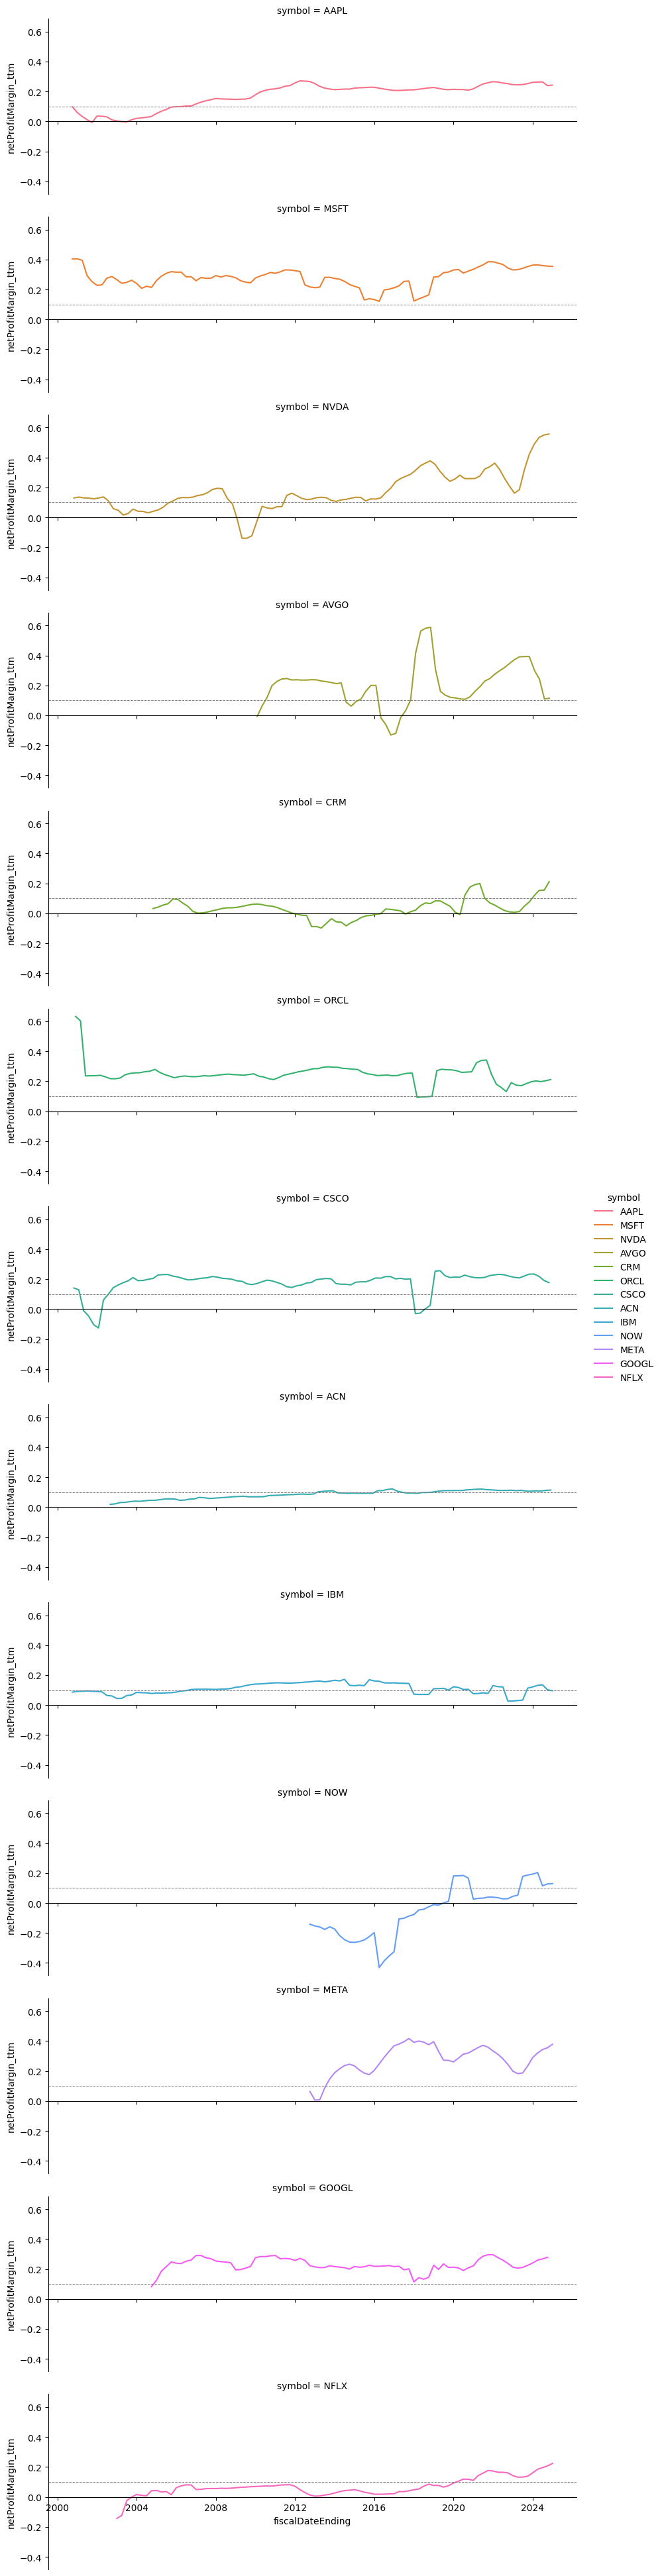

In [203]:
g = sns.relplot(
    data=financial_metrics_processed,
    y='netProfitMargin_ttm',
    x='fiscalDateEnding',
    row='symbol',
    hue='symbol',
    kind='line',
    height=3,
    aspect=3
)

# Apply formatting to each facet
for ax in g.axes.flat:
    ax.spines['bottom'].set_position(('data', 0))

# Add a horizontal line at y = 0 for each subplot
g.map(plt.axhline, y=0.1, color="grey", linestyle="--", linewidth=0.7)

### Data consolidation

In [204]:
macro_data.rename(columns={'periodEnd': 'date'}, inplace=True)

In [205]:
# initiate a dataframe records to store calendar days in the period for each ticker
data = []

for ticker in tickers:
    data.append(pd.DataFrame({'date': date_range, 'symbol': ticker}))
cons_data = pd.concat(data, ignore_index=True)

# Populate with stock data & marketCap
cons_data = pd.merge(cons_data, stock_df, left_on=['date', 'symbol'], right_on=['date', 'symbol'], how='outer')
cons_data = pd.merge(cons_data, marketcap_df, left_on=['date', 'symbol'], right_on=['date', 'symbol'], how='outer')
cons_data = pd.merge(cons_data, macro_data, left_on=['date'], right_on=['date'], how='left')
cons_data.sort_values(by=['symbol', 'date'], ascending=True, inplace=True)

# populate NaN within each symbol group with the latest available data
cons_data = cons_data.groupby('symbol').apply(lambda group: group.ffill()).reset_index(drop=True)

# view
display(cons_data.head())
display(cons_data.info())

date symbol  close  high  low  open       volume  dailyReturn   BOP  \
0 1999-12-31   AAPL   0.77  0.77 0.75  0.76 163811200.00          NaN  0.56   
1 2000-01-01   AAPL   0.77  0.77 0.75  0.76 163811200.00          NaN  0.56   
2 2000-01-02   AAPL   0.77  0.77 0.75  0.76 163811200.00          NaN  0.56   
3 2000-01-03   AAPL   0.84  0.85 0.77  0.79 535796800.00         0.09  0.65   
4 2000-01-04   AAPL   0.77  0.83 0.76  0.81 512377600.00        -0.08 -0.61   

   returnPre_1d  ...  Unemployment_bps_YoY  USTYield_10y_bps_YoY  \
0           NaN  ...                   NaN                   NaN   
1           NaN  ...                   NaN                   NaN   
2           NaN  ...                   NaN                   NaN   
3          0.09  ...                   NaN                   NaN   
4         -0.08  ...                   NaN                   NaN   

   USTYield_5y_bps_YoY  USTYield_2y_bps_YoY  USTYield_3m_bps_YoY  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   Unemployment_bps_QoQ  USTYield_10y_bps_QoQ  USTYield_5y_bps_QoQ  \
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   NaN                   NaN                  NaN   

   USTYield_2y_bps_QoQ  USTYield_3m_bps_QoQ  
0                  NaN                  NaN  
1                  NaN                  NaN  
2                  NaN                  NaN  
3                  NaN                  NaN  
4                  NaN                  NaN  

[5 rows x 60 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119132 entries, 0 to 119131
Data columns (total 60 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  119132 non-null  datetime64[ns]
 1   symbol                119132 non-null  object        
 2   close                 101771 non-null  float64       
 3   high                  101771 non-null  float64       
 4   low                   101771 non-null  float64       
 5   open                  101771 non-null  float64       
 6   volume                101771 non-null  float64       
 7   dailyReturn           101742 non-null  float64       
 8   BOP                   101771 non-null  float64       
 9   returnPre_1d          101742 non-null  float64       
 10  closeCV_1d            0 non-null       float64       
 11  BOP_SMA_1d            101771 non-null  float64       
 12  returnPre_2d          101720 non-null  float64       
 13 

None

In [206]:
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  104 non-null    datetime64[ns]
 1   RealGDP_pct_QoQ       103 non-null    float64       
 2   RealGDP_pct_YoY       100 non-null    float64       
 3   FedDebt_pct_QoQ       102 non-null    float64       
 4   FedDebt_pct_YoY       99 non-null     float64       
 5   CPI_pct_QoQ           103 non-null    float64       
 6   CPI_pct_YoY           100 non-null    float64       
 7   UnemploymentRate_pct  100 non-null    float64       
 8   USTYield_3m           101 non-null    float64       
 9   USTYield_2y           101 non-null    float64       
 10  USTYield_5y           101 non-null    float64       
 11  USTYield_10y          101 non-null    float64       
 12  Unemployment_bps_YoY  96 non-null     float64       
 13  USTYield_10y_bps_YoY

In [207]:
cons_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119132 entries, 0 to 119131
Data columns (total 60 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  119132 non-null  datetime64[ns]
 1   symbol                119132 non-null  object        
 2   close                 101771 non-null  float64       
 3   high                  101771 non-null  float64       
 4   low                   101771 non-null  float64       
 5   open                  101771 non-null  float64       
 6   volume                101771 non-null  float64       
 7   dailyReturn           101742 non-null  float64       
 8   BOP                   101771 non-null  float64       
 9   returnPre_1d          101742 non-null  float64       
 10  closeCV_1d            0 non-null       float64       
 11  BOP_SMA_1d            101771 non-null  float64       
 12  returnPre_2d          101720 non-null  float64       
 13 

In [208]:
financial_metrics_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   fiscalDateEnding                               1125 non-null   datetime64[ns]
 1   symbol                                         1125 non-null   object        
 2   fillingDate                                    1125 non-null   datetime64[ns]
 3   period                                         1125 non-null   object        
 4   currentRatio                                   1125 non-null   float64       
 5   debtToAssets                                   1125 non-null   float64       
 6   debtToEquity                                   1125 non-null   float64       
 7   grossProfitMargin_ttm                          1086 non-null   float64       
 8   operatingProfitMargin_ttm                      1086 non-nu

In [209]:
# Populate with financial metrics - merge on fiscalDateEnding
cons_data = pd.merge(
    cons_data, financial_metrics_processed,
    left_on=['date', 'symbol'],
    right_on=['fiscalDateEnding', 'symbol'],
    how='left'
#    indicator=True
)

# populate NaN in newly added financial metrics columns within each symbol group with the latest available data
cons_data.sort_values(by=['symbol', 'date', 'fiscalDateEnding'], ascending=True, inplace=True)
cons_data[financial_metrics_processed.columns] = cons_data.groupby('symbol')[financial_metrics_processed.columns].fillna(method='ffill')

cons_data.columns

Index(['date', 'symbol', 'close', 'high', 'low', 'open', 'volume',
       'dailyReturn', 'BOP', 'returnPre_1d', 'closeCV_1d', 'BOP_SMA_1d',
       'returnPre_2d', 'closeCV_2d', 'BOP_SMA_2d', 'returnPre_3d',
       'closeCV_3d', 'BOP_SMA_3d', 'returnPre_4d', 'closeCV_4d', 'BOP_SMA_4d',
       'returnPre_5d', 'closeCV_5d', 'BOP_SMA_5d', 'returnPre_10d',
       'closeCV_10d', 'BOP_SMA_10d', 'returnPre_15d', 'closeCV_15d',
       'BOP_SMA_15d', 'returnPost_1d', 'returnPost_2d', 'returnPost_3d',
       'returnPost_4d', 'returnPost_5d', 'returnPost_10d', 'returnPost_15d',
       'returnPost_20d', 'marketCap', 'RealGDP_pct_QoQ', 'RealGDP_pct_YoY',
       'FedDebt_pct_QoQ', 'FedDebt_pct_YoY', 'CPI_pct_QoQ', 'CPI_pct_YoY',
       'UnemploymentRate_pct', 'USTYield_3m', 'USTYield_2y', 'USTYield_5y',
       'USTYield_10y', 'Unemployment_bps_YoY', 'USTYield_10y_bps_YoY',
       'USTYield_5y_bps_YoY', 'USTYield_2y_bps_YoY', 'USTYield_3m_bps_YoY',
       'Unemployment_bps_QoQ', 'USTYield_10y_bps_QoQ'

In [210]:
cons_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119132 entries, 0 to 119131
Data columns (total 95 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   date                                           119132 non-null  datetime64[ns]
 1   symbol                                         119132 non-null  object        
 2   close                                          101771 non-null  float64       
 3   high                                           101771 non-null  float64       
 4   low                                            101771 non-null  float64       
 5   open                                           101771 non-null  float64       
 6   volume                                         101771 non-null  float64       
 7   dailyReturn                                    101742 non-null  float64       
 8   BOP                                         

**Note**:

Due to delayed quarterly reporting filings, where MSFT in 2021 and AAPL in 2026 submitted two consecutive quarter reports on the same date, the merged DataFrame contains two extra rows.

In [211]:
# derive PE and Price-to-Sales
cons_data['peRatio'] = cons_data['marketCap'] / cons_data['netIncome_ttm']
cons_data['pSalesRatio'] = cons_data['marketCap'] / cons_data['revenue_ttm']
# drop redundant columns
#cons_data.drop(columns=['netIncome_ttm', 'revenue_ttm'], inplace=True)

In [212]:
# Extract weekday and month
cons_data['weekday'] = cons_data['date'].dt.day_name()
cons_data['month'] = cons_data['date'].dt.month_name()

In [213]:
earnings_history_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   earnReportedDate               1016 non-null   datetime64[ns]
 1   symbol                         1016 non-null   object        
 2   epsAct                         1016 non-null   float64       
 3   epsEst                         1016 non-null   float64       
 4   earnReportedTime               1016 non-null   object        
 5   revenueAct                     1016 non-null   float64       
 6   revenueEst                     944 non-null    float64       
 7   fiscalDateEnding_ea            1016 non-null   datetime64[ns]
 8   amcEquivalentEarnReportedDate  1016 non-null   datetime64[ns]
 9   epsSurpriseAbs                 1016 non-null   float64       
 10  epsSurprise_pct                1016 non-null   float64       
 11  revSurpriseAbs   

In [214]:
cons_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119132 entries, 0 to 119131
Data columns (total 99 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   date                                           119132 non-null  datetime64[ns]
 1   symbol                                         119132 non-null  object        
 2   close                                          101771 non-null  float64       
 3   high                                           101771 non-null  float64       
 4   low                                            101771 non-null  float64       
 5   open                                           101771 non-null  float64       
 6   volume                                         101771 non-null  float64       
 7   dailyReturn                                    101742 non-null  float64       
 8   BOP                                         

In [215]:
# Populate with earnings data - merge on amcEquivalentReportedDate
cons_data = pd.merge(
    cons_data, earnings_history_processed,
    left_on=['date', 'symbol'],
    right_on=['amcEquivalentEarnReportedDate', 'symbol'],
    how='outer',
    indicator=True
)

cons_data['ea_flag'] = (cons_data['_merge'] == 'both').astype(int)
cons_data = cons_data.drop(columns=['_merge'])
cons_data.sort_values(by=['symbol', 'date', 'fiscalDateEnding_x'], ascending=True, inplace=True)

# populate NaN within each symbol group with the latest available data
cons_data = cons_data.groupby('symbol').apply(lambda group: group.ffill()).reset_index(drop=True)


# view
display(cons_data[cons_data.columns[0:10]].iloc[30:35])
display(cons_data.info())

date symbol  close  high  low  open       volume  dailyReturn   BOP  \
30 2000-01-30   AAPL   0.76  0.83 0.76  0.81 423348800.00        -0.08 -0.64   
31 2000-01-31   AAPL   0.78  0.78 0.71  0.76 701680000.00         0.02  0.29   
32 2000-02-01   AAPL   0.75  0.79 0.75  0.78 318035200.00        -0.03 -0.75   
33 2000-02-02   AAPL   0.74  0.77 0.73  0.76 464195200.00        -0.01 -0.38   
34 2000-02-03   AAPL   0.78  0.78 0.75  0.75 475193600.00         0.05  0.75   

    returnPre_1d  
30         -0.08  
31          0.02  
32         -0.03  
33         -0.01  
34          0.05

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119132 entries, 0 to 119131
Columns: 123 entries, date to ea_flag
dtypes: datetime64[ns](7), float64(110), int64(1), object(5)
memory usage: 111.8+ MB


None

In [216]:
cons_data = cons_data.drop(columns=['fiscalDateEnding_y', 'netProfitMargin_ttm_y', 'netProfitMargin_y'])

In [217]:
cons_data.rename(columns={'fiscalDateEnding_x': 'fiscalDateEnding', \
                          'netProfitMargin_ttm_x': 'netProfitMargin_ttm', 'netProfitMargin_x': 'netProfitMargin'}, inplace=True)


### Data Extraction

#### Subset features for trading strategy around earnings announcement dates analysis

In [218]:
strategy_dataset = cons_data[cons_data['ea_flag'] == 1].reset_index(drop=True)
display(strategy_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Columns: 120 entries, date to ea_flag
dtypes: datetime64[ns](6), float64(108), int64(1), object(5)
memory usage: 952.6+ KB


None

In [219]:
strategy_dataset.isna().sum()

date                      0
symbol                    0
close                     0
high                      0
low                       0
                         ..
standRevSurpriseScore    68
revSurpriseChange_QoQ    23
revenueEst_YoY           48
revenueAct_YoY           42
ea_flag                   0
Length: 120, dtype: int64

In [220]:
strategy_dataset = strategy_dataset.drop(columns=['ea_flag', 'closeCV_1d'])

#### Merge with Sentiment Scores

In [221]:
### Merging Sentiment with Earnings data
df_sent = strategy_dataset.copy()
df_sent.head()
df_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Columns: 118 entries, date to revenueAct_YoY
dtypes: datetime64[ns](6), float64(107), object(5)
memory usage: 936.8+ KB


In [222]:
#Reading in Sentiment data
sentiment = pd.read_csv('earnings_sentiment.csv')
sentiment['date'] = pd.to_datetime(sentiment['date'], format='%Y-%m-%d')

#Rename date as sent_date
sentiment.rename(columns={'date': 'sent_date'}, inplace=True)

sentiment.info()
sentiment.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   sent_date             72 non-null     datetime64[ns]
 1   pre_sentiment         33 non-null     float64       
 2   post_sentiment        41 non-null     float64       
 3   pre_macro_sentiment   51 non-null     float64       
 4   post_macro_sentiment  51 non-null     float64       
 5   symbol                72 non-null     object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 3.5+ KB


sent_date  pre_sentiment  post_sentiment  pre_macro_sentiment  \
0 2019-02-04            NaN             NaN                 0.86   
1 2019-04-29           0.84            0.43                 0.65   
2 2019-07-25            NaN             NaN                  NaN   
3 2019-10-28           0.47            0.58                  NaN   
4 2020-02-03            NaN            0.86                 0.36   

   post_macro_sentiment symbol  
0                  0.87  GOOGL  
1                  0.53  GOOGL  
2                   NaN  GOOGL  
3                  0.86  GOOGL  
4                  0.39  GOOGL

In [223]:
# Left Merge on symbol and date
df2_sent = pd.merge(df_sent, sentiment, left_on=['symbol', 'earnReportedDate'], right_on=['symbol', 'sent_date'], how='left')
df2_sent.info()
df2_sent
df2_sent.to_csv('strategy_dataset_export_wsenti.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Columns: 123 entries, date to post_macro_sentiment
dtypes: datetime64[ns](7), float64(111), object(5)
memory usage: 976.4+ KB
